# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='5'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

# fig, ax = plt.subplots(6,5, figsize=(15,12))
# fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax[i].imshow(img)
    
#     plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
#     ax[i].set_title(title_txt)
    i+=1

In [9]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [10]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights=None, input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [11]:
model = ResNet50Model()

C:\Users\Admin\anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

# for layer in model.layers[:num_feerezed_layer]:
    
#     if not isinstance(layer, K.layers.BatchNormalization):
#         layer.trainable = False
        
# Check if the trainable layers are set Correctly
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  True
conv1_pad   trainable =  True
conv1   trainable =  True
bn_conv1   trainable =  True
activation_1   trainable =  True
pool1_pad   trainable =  True
max_pooling2d_1   trainable =  True
res2a_branch2a   trainable =  True
bn2a_branch2a   trainable =  True
activation_2   trainable =  True
res2a_branch2b   trainable =  True
bn2a_branch2b   trainable =  True
activation_3   trainable =  True
res2a_branch2c   trainable =  True
res2a_branch1   trainable =  True
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  True
activation_4   trainable =  True
res2b_branch2a   trainable =  True
bn2b_branch2a   trainable =  True
activation_5   trainable =  True
res2b_branch2b   trainable =  True
bn2b_branch2b   trainable =  True
activation_6   trainable =  True
res2b_branch2c   trainable =  True
bn2b_branch2c   trainable =  True
add_2   trainable =  True
activation_7   trainable =  True
res2c_branch2a   trainable =  True
bn2c_branch2a   traina

In [13]:
batch_size = 32 # Tesla 上占用9013MB
model_root = 'models/notfreeze-nopretrained-models_'+str(batch_size)
checkpoint = ModelCheckpoint(os.path.join(model_root,'Best_Model.h5'),
                             verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [15]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0

time_begin = time.time()
for epoch in range(20):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/20epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
#             bar.moveto(0)
            break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/20epochs: 100%|██████████████| 412/412.0 [11:23<00:00,  1.05it/s, loss:3.09, acc:25.00%]
1/20epochs: 100%|██████████████| 412/412.0 [11:23<00:00,  1.66s/it, loss:3.09, acc:25.00%]

2/20epochs:   0%|                                               | 0/412.0 [00:00<?, ?it/s]
2/20epochs:   0%|                        | 0/412.0 [00:00<?, ?it/s, loss:3.31, acc:12.50%]
2/20epochs:   0%|                | 1/412.0 [00:00<01:52,  3.66it/s, loss:3.31, acc:12.50%]
2/20epochs:   0%|                | 1/412.0 [00:00<01:52,  3.66it/s, loss:3.31, acc:12.50%]
2/20epochs:   0%|                 | 1/412.0 [00:00<01:52,  3.66it/s, loss:3.63, acc:9.38%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:52,  3.64it/s, loss:3.63, acc:9.38%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:52,  3.64it/s, loss:3.63, acc:9.38%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:52,  3.64it/s, loss:3.69, acc:9.38%]
2/20epochs:   1%|                 | 3/412.0 [00:00<01:52,  3.63it/s, loss:3.69, acc:9.38%

2/20epochs:   5%|▋              | 19/412.0 [00:15<02:26,  2.68it/s, loss:3.43, acc:15.62%]
2/20epochs:   5%|▋              | 20/412.0 [00:15<02:14,  2.92it/s, loss:3.43, acc:15.62%]
2/20epochs:   5%|▋              | 20/412.0 [00:15<02:14,  2.92it/s, loss:3.43, acc:15.62%]
2/20epochs:   5%|▋              | 20/412.0 [00:16<02:14,  2.92it/s, loss:3.36, acc:12.50%]
2/20epochs:   5%|▊              | 21/412.0 [00:16<02:05,  3.12it/s, loss:3.36, acc:12.50%]
2/20epochs:   5%|▊              | 21/412.0 [00:16<02:05,  3.12it/s, loss:3.36, acc:12.50%]
2/20epochs:   5%|▊              | 21/412.0 [00:16<02:05,  3.12it/s, loss:3.63, acc:12.50%]
2/20epochs:   5%|▊              | 22/412.0 [00:16<01:59,  3.27it/s, loss:3.63, acc:12.50%]
2/20epochs:   5%|▊              | 22/412.0 [00:16<01:59,  3.27it/s, loss:3.63, acc:12.50%]
2/20epochs:   5%|▊               | 22/412.0 [00:16<01:59,  3.27it/s, loss:4.01, acc:6.25%]
2/20epochs:   6%|▉               | 23/412.0 [00:16<02:00,  3.22it/s, loss:4.01, acc:6.25%]

2/20epochs:   9%|█▍             | 39/412.0 [00:31<20:54,  3.36s/it, loss:3.41, acc:15.62%]
2/20epochs:  10%|█▍             | 40/412.0 [00:31<15:05,  2.43s/it, loss:3.41, acc:15.62%]
2/20epochs:  10%|█▍             | 40/412.0 [00:31<15:05,  2.43s/it, loss:3.41, acc:15.62%]
2/20epochs:  10%|█▍             | 40/412.0 [00:32<15:05,  2.43s/it, loss:3.66, acc:15.62%]
2/20epochs:  10%|█▍             | 41/412.0 [00:32<11:02,  1.79s/it, loss:3.66, acc:15.62%]
2/20epochs:  10%|█▍             | 41/412.0 [00:32<11:02,  1.79s/it, loss:3.66, acc:15.62%]
2/20epochs:  10%|█▍             | 41/412.0 [00:32<11:02,  1.79s/it, loss:3.53, acc:15.62%]
2/20epochs:  10%|█▌             | 42/412.0 [00:32<08:13,  1.33s/it, loss:3.53, acc:15.62%]
2/20epochs:  10%|█▌             | 42/412.0 [00:32<08:13,  1.33s/it, loss:3.53, acc:15.62%]
2/20epochs:  10%|█▌             | 42/412.0 [00:32<08:13,  1.33s/it, loss:3.60, acc:18.75%]
2/20epochs:  10%|█▌             | 43/412.0 [00:32<06:16,  1.02s/it, loss:3.60, acc:18.75%]

val:  17%|███▊                   | 68/412.0 [00:39<01:34,  3.65it/s, loss:3.52, acc:6.25%]
val:  17%|███▋                  | 68/412.0 [00:40<01:34,  3.65it/s, loss:3.34, acc:15.62%]
val:  17%|███▋                  | 68/412.0 [00:40<01:34,  3.65it/s, loss:3.35, acc:17.19%]
val:  17%|███▋                  | 68/412.0 [00:41<01:34,  3.65it/s, loss:3.38, acc:17.97%]
val:  17%|███▋                  | 68/412.0 [00:41<01:34,  3.65it/s, loss:3.42, acc:16.41%]
val:  17%|███▋                  | 68/412.0 [00:41<01:34,  3.65it/s, loss:3.40, acc:17.19%]
val:  17%|███▋                  | 68/412.0 [00:42<01:34,  3.65it/s, loss:3.49, acc:18.75%]
val:  17%|███▋                  | 68/412.0 [00:42<01:34,  3.65it/s, loss:3.61, acc:12.50%]
val:  17%|███▋                  | 68/412.0 [00:43<01:34,  3.65it/s, loss:3.58, acc:17.19%]
val:  17%|███▊                   | 68/412.0 [00:43<01:34,  3.65it/s, loss:3.65, acc:8.59%]
val:  17%|███▋                  | 68/412.0 [00:43<01:34,  3.65it/s, loss:3.62, acc:14.84%]

2/20epochs:  21%|███▏           | 88/412.0 [00:55<01:30,  3.57it/s, loss:3.33, acc:21.88%]
2/20epochs:  22%|███▏           | 89/412.0 [00:55<01:29,  3.59it/s, loss:3.33, acc:21.88%]
2/20epochs:  22%|███▏           | 89/412.0 [00:56<01:29,  3.59it/s, loss:3.33, acc:21.88%]
2/20epochs:  22%|███▏           | 89/412.0 [00:56<01:29,  3.59it/s, loss:3.32, acc:18.75%]
2/20epochs:  22%|███▎           | 90/412.0 [00:56<01:30,  3.56it/s, loss:3.32, acc:18.75%]
2/20epochs:  22%|███▎           | 90/412.0 [00:56<01:30,  3.56it/s, loss:3.32, acc:18.75%]
2/20epochs:  22%|███▎           | 90/412.0 [00:56<01:30,  3.56it/s, loss:3.44, acc:12.50%]
2/20epochs:  22%|███▎           | 91/412.0 [00:56<01:31,  3.51it/s, loss:3.44, acc:12.50%]
2/20epochs:  22%|███▎           | 91/412.0 [00:56<01:31,  3.51it/s, loss:3.44, acc:12.50%]
2/20epochs:  22%|███▌            | 91/412.0 [00:56<01:31,  3.51it/s, loss:3.29, acc:0.00%]
2/20epochs:  22%|███▌            | 92/412.0 [00:56<01:32,  3.46it/s, loss:3.29, acc:0.00%]

2/20epochs:  26%|███▉           | 108/412.0 [01:12<02:02,  2.47it/s, loss:3.40, acc:9.38%]
2/20epochs:  26%|███▉           | 109/412.0 [01:12<01:50,  2.73it/s, loss:3.40, acc:9.38%]
2/20epochs:  26%|███▉           | 109/412.0 [01:12<01:50,  2.73it/s, loss:3.40, acc:9.38%]
2/20epochs:  26%|███▋          | 109/412.0 [01:12<01:50,  2.73it/s, loss:3.10, acc:18.75%]
2/20epochs:  27%|███▋          | 110/412.0 [01:12<01:42,  2.95it/s, loss:3.10, acc:18.75%]
2/20epochs:  27%|███▋          | 110/412.0 [01:12<01:42,  2.95it/s, loss:3.10, acc:18.75%]
2/20epochs:  27%|███▋          | 110/412.0 [01:12<01:42,  2.95it/s, loss:3.36, acc:18.75%]
2/20epochs:  27%|███▊          | 111/412.0 [01:12<01:36,  3.12it/s, loss:3.36, acc:18.75%]
2/20epochs:  27%|███▊          | 111/412.0 [01:12<01:36,  3.12it/s, loss:3.36, acc:18.75%]
2/20epochs:  27%|███▊          | 111/412.0 [01:12<01:36,  3.12it/s, loss:3.16, acc:18.75%]
2/20epochs:  27%|███▊          | 112/412.0 [01:12<01:31,  3.27it/s, loss:3.16, acc:18.75%]

val:  31%|██████▌              | 128/412.0 [01:28<01:18,  3.64it/s, loss:3.13, acc:21.88%]
val:  31%|██████▌              | 129/412.0 [01:28<16:19,  3.46s/it, loss:3.13, acc:21.88%]
2/20epochs:  31%|████▍         | 129/412.0 [01:28<16:19,  3.46s/it, loss:3.13, acc:21.88%]
2/20epochs:  31%|████▍         | 129/412.0 [01:28<16:19,  3.46s/it, loss:3.18, acc:21.88%]
2/20epochs:  32%|████▍         | 130/412.0 [01:28<11:46,  2.51s/it, loss:3.18, acc:21.88%]
2/20epochs:  32%|████▍         | 130/412.0 [01:28<11:46,  2.51s/it, loss:3.18, acc:21.88%]
2/20epochs:  32%|████▍         | 130/412.0 [01:28<11:46,  2.51s/it, loss:3.76, acc:15.62%]
2/20epochs:  32%|████▍         | 131/412.0 [01:28<08:36,  1.84s/it, loss:3.76, acc:15.62%]
2/20epochs:  32%|████▍         | 131/412.0 [01:28<08:36,  1.84s/it, loss:3.76, acc:15.62%]
2/20epochs:  32%|████▍         | 131/412.0 [01:29<08:36,  1.84s/it, loss:3.41, acc:25.00%]
2/20epochs:  32%|████▍         | 132/412.0 [01:29<06:23,  1.37s/it, loss:3.41, acc:25.00%]

2/20epochs:  38%|█████▎        | 157/412.0 [01:36<01:10,  3.64it/s, loss:2.92, acc:21.88%]
2/20epochs:  38%|█████▎        | 158/412.0 [01:36<01:09,  3.66it/s, loss:2.92, acc:21.88%]
2/20epochs:  38%|█████▎        | 158/412.0 [01:36<01:09,  3.66it/s, loss:2.92, acc:21.88%]
val:  38%|████████             | 158/412.0 [01:36<01:09,  3.66it/s, loss:2.92, acc:21.88%]
val:  38%|████████             | 158/412.0 [01:37<01:09,  3.66it/s, loss:3.30, acc:20.31%]
val:  38%|████████             | 158/412.0 [01:37<01:09,  3.66it/s, loss:3.03, acc:24.22%]
val:  38%|████████             | 158/412.0 [01:37<01:09,  3.66it/s, loss:3.19, acc:21.88%]
val:  38%|████████             | 158/412.0 [01:38<01:09,  3.66it/s, loss:3.32, acc:20.31%]
val:  38%|████████             | 158/412.0 [01:38<01:09,  3.66it/s, loss:3.36, acc:21.88%]
val:  38%|████████             | 158/412.0 [01:39<01:09,  3.66it/s, loss:3.27, acc:21.09%]
val:  38%|████████             | 158/412.0 [01:39<01:09,  3.66it/s, loss:3.25, acc:14.84%]

2/20epochs:  43%|██████        | 177/412.0 [01:52<01:07,  3.50it/s, loss:3.20, acc:18.75%]
2/20epochs:  43%|██████        | 178/412.0 [01:52<01:06,  3.53it/s, loss:3.20, acc:18.75%]
2/20epochs:  43%|██████        | 178/412.0 [01:52<01:06,  3.53it/s, loss:3.20, acc:18.75%]
2/20epochs:  43%|██████        | 178/412.0 [01:52<01:06,  3.53it/s, loss:3.54, acc:15.62%]
2/20epochs:  43%|██████        | 179/412.0 [01:52<01:04,  3.59it/s, loss:3.54, acc:15.62%]
2/20epochs:  43%|██████        | 179/412.0 [01:52<01:04,  3.59it/s, loss:3.54, acc:15.62%]
2/20epochs:  43%|██████▌        | 179/412.0 [01:53<01:04,  3.59it/s, loss:3.98, acc:3.12%]
2/20epochs:  44%|██████▌        | 180/412.0 [01:53<01:04,  3.62it/s, loss:3.98, acc:3.12%]
2/20epochs:  44%|██████▌        | 180/412.0 [01:53<01:04,  3.62it/s, loss:3.98, acc:3.12%]
2/20epochs:  44%|██████        | 180/412.0 [01:53<01:04,  3.62it/s, loss:2.75, acc:28.12%]
2/20epochs:  44%|██████▏       | 181/412.0 [01:53<01:03,  3.62it/s, loss:2.75, acc:28.12%]

2/20epochs:  48%|██████▋       | 197/412.0 [02:08<01:38,  2.18it/s, loss:3.14, acc:15.62%]
2/20epochs:  48%|██████▋       | 198/412.0 [02:08<01:27,  2.45it/s, loss:3.14, acc:15.62%]
2/20epochs:  48%|██████▋       | 198/412.0 [02:08<01:27,  2.45it/s, loss:3.14, acc:15.62%]
2/20epochs:  48%|██████▋       | 198/412.0 [02:09<01:27,  2.45it/s, loss:3.31, acc:25.00%]
2/20epochs:  48%|██████▊       | 199/412.0 [02:09<01:18,  2.72it/s, loss:3.31, acc:25.00%]
2/20epochs:  48%|██████▊       | 199/412.0 [02:09<01:18,  2.72it/s, loss:3.31, acc:25.00%]
2/20epochs:  48%|██████▊       | 199/412.0 [02:09<01:18,  2.72it/s, loss:3.32, acc:25.00%]
2/20epochs:  49%|██████▊       | 200/412.0 [02:09<01:12,  2.94it/s, loss:3.32, acc:25.00%]
2/20epochs:  49%|██████▊       | 200/412.0 [02:09<01:12,  2.94it/s, loss:3.32, acc:25.00%]
2/20epochs:  49%|██████▊       | 200/412.0 [02:09<01:12,  2.94it/s, loss:3.08, acc:15.62%]
2/20epochs:  49%|██████▊       | 201/412.0 [02:09<01:08,  3.06it/s, loss:3.08, acc:15.62%]

val:  53%|███████████          | 218/412.0 [02:24<00:57,  3.37it/s, loss:3.36, acc:17.97%]
val:  53%|███████████          | 218/412.0 [02:24<00:57,  3.37it/s, loss:3.03, acc:23.44%]
val:  53%|███████████          | 218/412.0 [02:25<00:57,  3.37it/s, loss:3.18, acc:20.31%]
val:  53%|███████████          | 218/412.0 [02:25<00:57,  3.37it/s, loss:3.08, acc:25.00%]
val:  53%|███████████▏         | 219/412.0 [02:25<11:10,  3.47s/it, loss:3.08, acc:25.00%]
2/20epochs:  53%|███████▍      | 219/412.0 [02:25<11:10,  3.47s/it, loss:3.08, acc:25.00%]
2/20epochs:  53%|███████▍      | 219/412.0 [02:25<11:10,  3.47s/it, loss:3.51, acc:15.62%]
2/20epochs:  53%|███████▍      | 220/412.0 [02:25<08:02,  2.51s/it, loss:3.51, acc:15.62%]
2/20epochs:  53%|███████▍      | 220/412.0 [02:25<08:02,  2.51s/it, loss:3.51, acc:15.62%]
2/20epochs:  53%|███████▍      | 220/412.0 [02:25<08:02,  2.51s/it, loss:3.60, acc:18.75%]
2/20epochs:  54%|███████▌      | 221/412.0 [02:25<05:52,  1.85s/it, loss:3.60, acc:18.75%]

2/20epochs:  60%|████████▉      | 246/412.0 [02:33<00:47,  3.52it/s, loss:3.01, acc:9.38%]
2/20epochs:  60%|████████▉      | 247/412.0 [02:33<00:46,  3.54it/s, loss:3.01, acc:9.38%]
2/20epochs:  60%|████████▉      | 247/412.0 [02:33<00:46,  3.54it/s, loss:3.01, acc:9.38%]
2/20epochs:  60%|████████▉      | 247/412.0 [02:33<00:46,  3.54it/s, loss:3.58, acc:9.38%]
2/20epochs:  60%|█████████      | 248/412.0 [02:33<00:45,  3.58it/s, loss:3.58, acc:9.38%]
2/20epochs:  60%|█████████      | 248/412.0 [02:33<00:45,  3.58it/s, loss:3.58, acc:9.38%]
val:  60%|█████████████▏        | 248/412.0 [02:33<00:45,  3.58it/s, loss:3.58, acc:9.38%]
val:  60%|████████████▋        | 248/412.0 [02:34<00:45,  3.58it/s, loss:3.39, acc:20.31%]
val:  60%|████████████▋        | 248/412.0 [02:34<00:45,  3.58it/s, loss:3.42, acc:17.97%]
val:  60%|████████████▋        | 248/412.0 [02:35<00:45,  3.58it/s, loss:3.22, acc:17.97%]
val:  60%|████████████▋        | 248/412.0 [02:35<00:45,  3.58it/s, loss:3.06, acc:15.62%]

2/20epochs:  65%|█████████     | 266/412.0 [02:49<00:42,  3.48it/s, loss:3.36, acc:28.12%]
2/20epochs:  65%|█████████     | 267/412.0 [02:49<00:41,  3.53it/s, loss:3.36, acc:28.12%]
2/20epochs:  65%|█████████     | 267/412.0 [02:49<00:41,  3.53it/s, loss:3.36, acc:28.12%]
2/20epochs:  65%|█████████▋     | 267/412.0 [02:49<00:41,  3.53it/s, loss:3.35, acc:9.38%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:49<00:41,  3.50it/s, loss:3.35, acc:9.38%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:49<00:41,  3.50it/s, loss:3.35, acc:9.38%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:49<00:41,  3.50it/s, loss:3.42, acc:9.38%]
2/20epochs:  65%|█████████▊     | 269/412.0 [02:49<00:41,  3.46it/s, loss:3.42, acc:9.38%]
2/20epochs:  65%|█████████▊     | 269/412.0 [02:49<00:41,  3.46it/s, loss:3.42, acc:9.38%]
2/20epochs:  65%|█████████▏    | 269/412.0 [02:50<00:41,  3.46it/s, loss:3.19, acc:15.62%]
2/20epochs:  66%|█████████▏    | 270/412.0 [02:50<00:40,  3.48it/s, loss:3.19, acc:15.62%]

2/20epochs:  69%|█████████▋    | 286/412.0 [03:05<01:07,  1.88it/s, loss:3.56, acc:15.62%]
2/20epochs:  70%|█████████▊    | 287/412.0 [03:05<00:57,  2.17it/s, loss:3.56, acc:15.62%]
2/20epochs:  70%|█████████▊    | 287/412.0 [03:05<00:57,  2.17it/s, loss:3.56, acc:15.62%]
2/20epochs:  70%|██████████▍    | 287/412.0 [03:05<00:57,  2.17it/s, loss:3.51, acc:9.38%]
2/20epochs:  70%|██████████▍    | 288/412.0 [03:05<00:50,  2.44it/s, loss:3.51, acc:9.38%]
2/20epochs:  70%|██████████▍    | 288/412.0 [03:05<00:50,  2.44it/s, loss:3.51, acc:9.38%]
2/20epochs:  70%|█████████▊    | 288/412.0 [03:05<00:50,  2.44it/s, loss:3.38, acc:18.75%]
2/20epochs:  70%|█████████▊    | 289/412.0 [03:05<00:45,  2.69it/s, loss:3.38, acc:18.75%]
2/20epochs:  70%|█████████▊    | 289/412.0 [03:05<00:45,  2.69it/s, loss:3.38, acc:18.75%]
2/20epochs:  70%|█████████▊    | 289/412.0 [03:06<00:45,  2.69it/s, loss:3.69, acc:18.75%]
2/20epochs:  70%|█████████▊    | 290/412.0 [03:06<00:42,  2.87it/s, loss:3.69, acc:18.75%]

val:  75%|███████████████▋     | 308/412.0 [03:19<00:28,  3.64it/s, loss:3.29, acc:18.75%]
val:  75%|███████████████▋     | 308/412.0 [03:20<00:28,  3.64it/s, loss:3.02, acc:17.19%]
val:  75%|███████████████▋     | 308/412.0 [03:20<00:28,  3.64it/s, loss:3.14, acc:23.44%]
val:  75%|███████████████▋     | 308/412.0 [03:20<00:28,  3.64it/s, loss:3.26, acc:17.97%]
val:  75%|███████████████▋     | 308/412.0 [03:21<00:28,  3.64it/s, loss:3.21, acc:22.66%]
val:  75%|███████████████▋     | 308/412.0 [03:21<00:28,  3.64it/s, loss:3.16, acc:20.31%]
val:  75%|███████████████▋     | 308/412.0 [03:21<00:28,  3.64it/s, loss:3.05, acc:18.75%]
val:  75%|███████████████▊     | 309/412.0 [03:21<05:49,  3.40s/it, loss:3.05, acc:18.75%]
2/20epochs:  75%|██████████▌   | 309/412.0 [03:21<05:49,  3.40s/it, loss:3.05, acc:18.75%]
2/20epochs:  75%|██████████▌   | 309/412.0 [03:22<05:49,  3.40s/it, loss:2.91, acc:15.62%]
2/20epochs:  75%|██████████▌   | 310/412.0 [03:22<04:10,  2.46s/it, loss:2.91, acc:15.62%]

2/20epochs:  81%|███████████▍  | 335/412.0 [03:29<00:20,  3.76it/s, loss:3.03, acc:25.00%]
2/20epochs:  82%|███████████▍  | 336/412.0 [03:29<00:20,  3.78it/s, loss:3.03, acc:25.00%]
2/20epochs:  82%|███████████▍  | 336/412.0 [03:29<00:20,  3.78it/s, loss:3.03, acc:25.00%]
2/20epochs:  82%|████████████▏  | 336/412.0 [03:29<00:20,  3.78it/s, loss:3.44, acc:9.38%]
2/20epochs:  82%|████████████▎  | 337/412.0 [03:29<00:19,  3.76it/s, loss:3.44, acc:9.38%]
2/20epochs:  82%|████████████▎  | 337/412.0 [03:29<00:19,  3.76it/s, loss:3.44, acc:9.38%]
2/20epochs:  82%|███████████▍  | 337/412.0 [03:29<00:19,  3.76it/s, loss:2.90, acc:15.62%]
2/20epochs:  82%|███████████▍  | 338/412.0 [03:29<00:19,  3.77it/s, loss:2.90, acc:15.62%]
2/20epochs:  82%|███████████▍  | 338/412.0 [03:29<00:19,  3.77it/s, loss:2.90, acc:15.62%]
val:  82%|█████████████████▏   | 338/412.0 [03:29<00:19,  3.77it/s, loss:2.90, acc:15.62%]
val:  82%|█████████████████▏   | 338/412.0 [03:30<00:19,  3.77it/s, loss:3.24, acc:14.84%]

2/20epochs:  86%|████████████  | 355/412.0 [03:44<00:15,  3.65it/s, loss:3.38, acc:12.50%]
2/20epochs:  86%|████████████  | 356/412.0 [03:44<00:15,  3.70it/s, loss:3.38, acc:12.50%]
2/20epochs:  86%|████████████  | 356/412.0 [03:44<00:15,  3.70it/s, loss:3.38, acc:12.50%]
2/20epochs:  86%|████████████  | 356/412.0 [03:44<00:15,  3.70it/s, loss:3.17, acc:21.88%]
2/20epochs:  87%|████████████▏ | 357/412.0 [03:44<00:14,  3.73it/s, loss:3.17, acc:21.88%]
2/20epochs:  87%|████████████▏ | 357/412.0 [03:44<00:14,  3.73it/s, loss:3.17, acc:21.88%]
2/20epochs:  87%|████████████▏ | 357/412.0 [03:45<00:14,  3.73it/s, loss:3.28, acc:15.62%]
2/20epochs:  87%|████████████▏ | 358/412.0 [03:45<00:14,  3.75it/s, loss:3.28, acc:15.62%]
2/20epochs:  87%|████████████▏ | 358/412.0 [03:45<00:14,  3.75it/s, loss:3.28, acc:15.62%]
2/20epochs:  87%|█████████████  | 358/412.0 [03:45<00:14,  3.75it/s, loss:3.86, acc:3.12%]
2/20epochs:  87%|█████████████  | 359/412.0 [03:45<00:14,  3.76it/s, loss:3.86, acc:3.12%]

2/20epochs:  91%|████████████▋ | 375/412.0 [04:00<00:24,  1.52it/s, loss:2.91, acc:31.25%]
2/20epochs:  91%|████████████▊ | 376/412.0 [04:00<00:19,  1.82it/s, loss:2.91, acc:31.25%]
2/20epochs:  91%|████████████▊ | 376/412.0 [04:00<00:19,  1.82it/s, loss:2.91, acc:31.25%]
2/20epochs:  91%|████████████▊ | 376/412.0 [04:01<00:19,  1.82it/s, loss:3.47, acc:12.50%]
2/20epochs:  92%|████████████▊ | 377/412.0 [04:01<00:16,  2.14it/s, loss:3.47, acc:12.50%]
2/20epochs:  92%|████████████▊ | 377/412.0 [04:01<00:16,  2.14it/s, loss:3.47, acc:12.50%]
2/20epochs:  92%|████████████▊ | 377/412.0 [04:01<00:16,  2.14it/s, loss:2.55, acc:31.25%]
2/20epochs:  92%|████████████▊ | 378/412.0 [04:01<00:14,  2.43it/s, loss:2.55, acc:31.25%]
2/20epochs:  92%|████████████▊ | 378/412.0 [04:01<00:14,  2.43it/s, loss:2.55, acc:31.25%]
2/20epochs:  92%|████████████▊ | 378/412.0 [04:01<00:14,  2.43it/s, loss:2.99, acc:21.88%]
2/20epochs:  92%|████████████▉ | 379/412.0 [04:01<00:12,  2.71it/s, loss:2.99, acc:21.88%]

val:  97%|████████████████████▎| 398/412.0 [04:14<00:03,  3.62it/s, loss:3.33, acc:17.19%]
val:  97%|████████████████████▎| 398/412.0 [04:14<00:03,  3.62it/s, loss:2.93, acc:23.44%]
val:  97%|████████████████████▎| 398/412.0 [04:15<00:03,  3.62it/s, loss:3.17, acc:21.88%]
val:  97%|████████████████████▎| 398/412.0 [04:15<00:03,  3.62it/s, loss:3.26, acc:19.53%]
val:  97%|████████████████████▎| 398/412.0 [04:16<00:03,  3.62it/s, loss:3.36, acc:21.09%]
val:  97%|████████████████████▎| 398/412.0 [04:16<00:03,  3.62it/s, loss:3.31, acc:21.09%]
val:  97%|████████████████████▎| 398/412.0 [04:17<00:03,  3.62it/s, loss:3.10, acc:21.09%]
val:  97%|████████████████████▎| 398/412.0 [04:17<00:03,  3.62it/s, loss:3.02, acc:23.44%]
val:  97%|████████████████████▎| 398/412.0 [04:17<00:03,  3.62it/s, loss:3.21, acc:19.53%]
val:  97%|█████████████████████▎| 398/412.0 [04:17<00:03,  3.62it/s, loss:3.59, acc:6.25%]
val:  97%|█████████████████████▎| 399/412.0 [04:17<00:45,  3.48s/it, loss:3.59, acc:6.25%]

4/20epochs:   3%|▍              | 12/412.0 [00:03<01:49,  3.65it/s, loss:3.13, acc:15.62%]
4/20epochs:   3%|▍              | 12/412.0 [00:03<01:49,  3.65it/s, loss:3.13, acc:15.62%]
4/20epochs:   3%|▍              | 12/412.0 [00:03<01:49,  3.65it/s, loss:3.10, acc:21.88%]
4/20epochs:   3%|▍              | 13/412.0 [00:03<01:52,  3.56it/s, loss:3.10, acc:21.88%]
4/20epochs:   3%|▍              | 13/412.0 [00:03<01:52,  3.56it/s, loss:3.10, acc:21.88%]
4/20epochs:   3%|▍              | 13/412.0 [00:03<01:52,  3.56it/s, loss:2.75, acc:34.38%]
4/20epochs:   3%|▌              | 14/412.0 [00:03<01:53,  3.51it/s, loss:2.75, acc:34.38%]
4/20epochs:   3%|▌              | 14/412.0 [00:03<01:53,  3.51it/s, loss:2.75, acc:34.38%]
4/20epochs:   3%|▌              | 14/412.0 [00:04<01:53,  3.51it/s, loss:2.59, acc:18.75%]
4/20epochs:   4%|▌              | 15/412.0 [00:04<01:52,  3.54it/s, loss:2.59, acc:18.75%]
4/20epochs:   4%|▌              | 15/412.0 [00:04<01:52,  3.54it/s, loss:2.59, acc:18.75%]

4/20epochs:   8%|█▏             | 32/412.0 [00:19<03:26,  1.84it/s, loss:2.46, acc:31.25%]
4/20epochs:   8%|█▏             | 32/412.0 [00:19<03:26,  1.84it/s, loss:2.46, acc:31.25%]
4/20epochs:   8%|█▏             | 32/412.0 [00:19<03:26,  1.84it/s, loss:2.69, acc:28.12%]
4/20epochs:   8%|█▏             | 33/412.0 [00:19<02:57,  2.14it/s, loss:2.69, acc:28.12%]
4/20epochs:   8%|█▏             | 33/412.0 [00:19<02:57,  2.14it/s, loss:2.69, acc:28.12%]
4/20epochs:   8%|█▏             | 33/412.0 [00:20<02:57,  2.14it/s, loss:3.13, acc:15.62%]
4/20epochs:   8%|█▏             | 34/412.0 [00:20<02:35,  2.43it/s, loss:3.13, acc:15.62%]
4/20epochs:   8%|█▏             | 34/412.0 [00:20<02:35,  2.43it/s, loss:3.13, acc:15.62%]
4/20epochs:   8%|█▏             | 34/412.0 [00:20<02:35,  2.43it/s, loss:2.99, acc:21.88%]
4/20epochs:   8%|█▎             | 35/412.0 [00:20<02:21,  2.67it/s, loss:2.99, acc:21.88%]
4/20epochs:   8%|█▎             | 35/412.0 [00:20<02:21,  2.67it/s, loss:2.99, acc:21.88%]

val:  13%|██▉                   | 54/412.0 [00:33<01:38,  3.62it/s, loss:2.97, acc:26.56%]
val:  13%|██▉                   | 54/412.0 [00:34<01:38,  3.62it/s, loss:2.90, acc:25.78%]
val:  13%|██▉                   | 54/412.0 [00:34<01:38,  3.62it/s, loss:2.74, acc:30.47%]
val:  13%|██▉                   | 54/412.0 [00:34<01:38,  3.62it/s, loss:3.18, acc:16.41%]
val:  13%|██▉                   | 54/412.0 [00:35<01:38,  3.62it/s, loss:2.98, acc:21.88%]
val:  13%|██▉                   | 54/412.0 [00:35<01:38,  3.62it/s, loss:3.08, acc:21.88%]
val:  13%|██▉                   | 54/412.0 [00:36<01:38,  3.62it/s, loss:3.03, acc:27.96%]
val:  13%|██▉                   | 54/412.0 [00:36<01:38,  3.62it/s, loss:3.12, acc:23.44%]
val:  13%|██▉                   | 54/412.0 [00:36<01:38,  3.62it/s, loss:2.93, acc:31.25%]
val:  13%|██▉                   | 55/412.0 [00:36<20:22,  3.42s/it, loss:2.93, acc:31.25%]
4/20epochs:  13%|██             | 55/412.0 [00:36<20:22,  3.42s/it, loss:2.93, acc:31.25%]

4/20epochs:  20%|██▉            | 81/412.0 [00:43<01:34,  3.48it/s, loss:3.27, acc:18.75%]
4/20epochs:  20%|██▉            | 81/412.0 [00:43<01:34,  3.48it/s, loss:3.27, acc:18.75%]
4/20epochs:  20%|██▉            | 81/412.0 [00:43<01:34,  3.48it/s, loss:2.67, acc:31.25%]
4/20epochs:  20%|██▉            | 82/412.0 [00:43<01:34,  3.49it/s, loss:2.67, acc:31.25%]
4/20epochs:  20%|██▉            | 82/412.0 [00:44<01:34,  3.49it/s, loss:2.67, acc:31.25%]
4/20epochs:  20%|██▉            | 82/412.0 [00:44<01:34,  3.49it/s, loss:2.49, acc:34.38%]
4/20epochs:  20%|███            | 83/412.0 [00:44<01:34,  3.49it/s, loss:2.49, acc:34.38%]
4/20epochs:  20%|███            | 83/412.0 [00:44<01:34,  3.49it/s, loss:2.49, acc:34.38%]
4/20epochs:  20%|███            | 83/412.0 [00:44<01:34,  3.49it/s, loss:2.63, acc:25.00%]
4/20epochs:  20%|███            | 84/412.0 [00:44<01:33,  3.52it/s, loss:2.63, acc:25.00%]
4/20epochs:  20%|███            | 84/412.0 [00:44<01:33,  3.52it/s, loss:2.63, acc:25.00%]

4/20epochs:  25%|███▍          | 101/412.0 [00:59<01:29,  3.49it/s, loss:2.51, acc:34.38%]
4/20epochs:  25%|███▍          | 101/412.0 [00:59<01:29,  3.49it/s, loss:2.51, acc:34.38%]
4/20epochs:  25%|███▍          | 101/412.0 [01:00<01:29,  3.49it/s, loss:2.81, acc:21.88%]
4/20epochs:  25%|███▍          | 102/412.0 [01:00<01:27,  3.56it/s, loss:2.81, acc:21.88%]
4/20epochs:  25%|███▍          | 102/412.0 [01:00<01:27,  3.56it/s, loss:2.81, acc:21.88%]
4/20epochs:  25%|███▍          | 102/412.0 [01:00<01:27,  3.56it/s, loss:3.32, acc:18.75%]
4/20epochs:  25%|███▌          | 103/412.0 [01:00<01:26,  3.57it/s, loss:3.32, acc:18.75%]
4/20epochs:  25%|███▌          | 103/412.0 [01:00<01:26,  3.57it/s, loss:3.32, acc:18.75%]
4/20epochs:  25%|███▌          | 103/412.0 [01:00<01:26,  3.57it/s, loss:2.65, acc:31.25%]
4/20epochs:  25%|███▌          | 104/412.0 [01:00<01:25,  3.62it/s, loss:2.65, acc:31.25%]
4/20epochs:  25%|███▌          | 104/412.0 [01:00<01:25,  3.62it/s, loss:2.65, acc:31.25%]

4/20epochs:  29%|████          | 121/412.0 [01:16<03:11,  1.52it/s, loss:2.51, acc:25.00%]
4/20epochs:  29%|████          | 121/412.0 [01:16<03:11,  1.52it/s, loss:2.51, acc:25.00%]
4/20epochs:  29%|████          | 121/412.0 [01:16<03:11,  1.52it/s, loss:2.60, acc:18.75%]
4/20epochs:  30%|████▏         | 122/412.0 [01:16<02:37,  1.84it/s, loss:2.60, acc:18.75%]
4/20epochs:  30%|████▏         | 122/412.0 [01:16<02:37,  1.84it/s, loss:2.60, acc:18.75%]
4/20epochs:  30%|████▏         | 122/412.0 [01:16<02:37,  1.84it/s, loss:3.01, acc:18.75%]
4/20epochs:  30%|████▏         | 123/412.0 [01:16<02:15,  2.13it/s, loss:3.01, acc:18.75%]
4/20epochs:  30%|████▏         | 123/412.0 [01:16<02:15,  2.13it/s, loss:3.01, acc:18.75%]
4/20epochs:  30%|████▏         | 123/412.0 [01:16<02:15,  2.13it/s, loss:3.28, acc:25.00%]
4/20epochs:  30%|████▏         | 124/412.0 [01:16<01:58,  2.43it/s, loss:3.28, acc:25.00%]
4/20epochs:  30%|████▏         | 124/412.0 [01:16<01:58,  2.43it/s, loss:3.28, acc:25.00%]

val:  35%|███████▎             | 144/412.0 [01:29<01:14,  3.58it/s, loss:2.84, acc:32.03%]
val:  35%|███████▎             | 144/412.0 [01:29<01:14,  3.58it/s, loss:2.65, acc:31.25%]
val:  35%|███████▎             | 144/412.0 [01:30<01:14,  3.58it/s, loss:2.61, acc:32.03%]
val:  35%|███████▎             | 144/412.0 [01:30<01:14,  3.58it/s, loss:2.88, acc:22.66%]
val:  35%|███████▎             | 144/412.0 [01:31<01:14,  3.58it/s, loss:2.81, acc:21.88%]
val:  35%|███████▎             | 144/412.0 [01:31<01:14,  3.58it/s, loss:2.95, acc:27.34%]
val:  35%|███████▎             | 144/412.0 [01:31<01:14,  3.58it/s, loss:3.00, acc:23.66%]
val:  35%|███████▎             | 144/412.0 [01:32<01:14,  3.58it/s, loss:2.99, acc:27.34%]
val:  35%|███████▎             | 144/412.0 [01:32<01:14,  3.58it/s, loss:2.69, acc:26.56%]
val:  35%|███████▎             | 144/412.0 [01:32<01:14,  3.58it/s, loss:2.77, acc:27.34%]
val:  35%|███████▎             | 144/412.0 [01:33<01:14,  3.58it/s, loss:2.55, acc:33.59%]

4/20epochs:  41%|█████▊        | 170/412.0 [01:40<01:08,  3.55it/s, loss:2.71, acc:34.38%]
4/20epochs:  41%|█████▊        | 170/412.0 [01:40<01:08,  3.55it/s, loss:2.71, acc:34.38%]
4/20epochs:  41%|█████▊        | 170/412.0 [01:40<01:08,  3.55it/s, loss:2.82, acc:28.12%]
4/20epochs:  42%|█████▊        | 171/412.0 [01:40<01:07,  3.56it/s, loss:2.82, acc:28.12%]
4/20epochs:  42%|█████▊        | 171/412.0 [01:40<01:07,  3.56it/s, loss:2.82, acc:28.12%]
4/20epochs:  42%|█████▊        | 171/412.0 [01:40<01:07,  3.56it/s, loss:3.20, acc:12.50%]
4/20epochs:  42%|█████▊        | 172/412.0 [01:40<01:06,  3.60it/s, loss:3.20, acc:12.50%]
4/20epochs:  42%|█████▊        | 172/412.0 [01:40<01:06,  3.60it/s, loss:3.20, acc:12.50%]
4/20epochs:  42%|█████▊        | 172/412.0 [01:41<01:06,  3.60it/s, loss:2.97, acc:25.00%]
4/20epochs:  42%|█████▉        | 173/412.0 [01:41<01:06,  3.61it/s, loss:2.97, acc:25.00%]
4/20epochs:  42%|█████▉        | 173/412.0 [01:41<01:06,  3.61it/s, loss:2.97, acc:25.00%]

4/20epochs:  46%|██████▍       | 190/412.0 [01:56<01:07,  3.27it/s, loss:2.73, acc:34.38%]
4/20epochs:  46%|██████▍       | 190/412.0 [01:56<01:07,  3.27it/s, loss:2.73, acc:34.38%]
4/20epochs:  46%|██████▍       | 190/412.0 [01:56<01:07,  3.27it/s, loss:2.21, acc:53.12%]
4/20epochs:  46%|██████▍       | 191/412.0 [01:56<01:05,  3.37it/s, loss:2.21, acc:53.12%]
4/20epochs:  46%|██████▍       | 191/412.0 [01:56<01:05,  3.37it/s, loss:2.21, acc:53.12%]
4/20epochs:  46%|██████▍       | 191/412.0 [01:57<01:05,  3.37it/s, loss:3.05, acc:12.50%]
4/20epochs:  47%|██████▌       | 192/412.0 [01:57<01:04,  3.44it/s, loss:3.05, acc:12.50%]
4/20epochs:  47%|██████▌       | 192/412.0 [01:57<01:04,  3.44it/s, loss:3.05, acc:12.50%]
4/20epochs:  47%|██████▌       | 192/412.0 [01:57<01:04,  3.44it/s, loss:2.77, acc:37.50%]
4/20epochs:  47%|██████▌       | 193/412.0 [01:57<01:02,  3.51it/s, loss:2.77, acc:37.50%]
4/20epochs:  47%|██████▌       | 193/412.0 [01:57<01:02,  3.51it/s, loss:2.77, acc:37.50%]

4/20epochs:  51%|███████▏      | 210/412.0 [02:12<02:44,  1.23it/s, loss:2.60, acc:31.25%]
4/20epochs:  51%|███████▏      | 210/412.0 [02:12<02:44,  1.23it/s, loss:2.60, acc:31.25%]
4/20epochs:  51%|███████▏      | 210/412.0 [02:13<02:44,  1.23it/s, loss:2.26, acc:31.25%]
4/20epochs:  51%|███████▏      | 211/412.0 [02:13<02:12,  1.52it/s, loss:2.26, acc:31.25%]
4/20epochs:  51%|███████▏      | 211/412.0 [02:13<02:12,  1.52it/s, loss:2.26, acc:31.25%]
4/20epochs:  51%|███████▏      | 211/412.0 [02:13<02:12,  1.52it/s, loss:3.00, acc:18.75%]
4/20epochs:  51%|███████▏      | 212/412.0 [02:13<01:48,  1.84it/s, loss:3.00, acc:18.75%]
4/20epochs:  51%|███████▏      | 212/412.0 [02:13<01:48,  1.84it/s, loss:3.00, acc:18.75%]
4/20epochs:  51%|███████▏      | 212/412.0 [02:13<01:48,  1.84it/s, loss:2.94, acc:12.50%]
4/20epochs:  52%|███████▏      | 213/412.0 [02:13<01:31,  2.17it/s, loss:2.94, acc:12.50%]
4/20epochs:  52%|███████▏      | 213/412.0 [02:13<01:31,  2.17it/s, loss:2.94, acc:12.50%]

val:  57%|███████████▉         | 234/412.0 [02:25<00:49,  3.57it/s, loss:3.07, acc:27.34%]
val:  57%|███████████▉         | 234/412.0 [02:25<00:49,  3.57it/s, loss:3.24, acc:22.66%]
val:  57%|███████████▉         | 234/412.0 [02:25<00:49,  3.57it/s, loss:2.72, acc:26.56%]
val:  57%|███████████▉         | 234/412.0 [02:26<00:49,  3.57it/s, loss:3.12, acc:24.22%]
val:  57%|███████████▉         | 234/412.0 [02:26<00:49,  3.57it/s, loss:2.89, acc:23.44%]
val:  57%|███████████▉         | 234/412.0 [02:27<00:49,  3.57it/s, loss:3.14, acc:25.00%]
val:  57%|███████████▉         | 234/412.0 [02:27<00:49,  3.57it/s, loss:2.91, acc:25.81%]
val:  57%|███████████▉         | 234/412.0 [02:27<00:49,  3.57it/s, loss:3.14, acc:19.53%]
val:  57%|███████████▉         | 234/412.0 [02:28<00:49,  3.57it/s, loss:2.93, acc:28.12%]
val:  57%|███████████▉         | 234/412.0 [02:28<00:49,  3.57it/s, loss:2.97, acc:22.66%]
val:  57%|███████████▉         | 234/412.0 [02:28<00:49,  3.57it/s, loss:3.08, acc:25.78%]

4/20epochs:  63%|████████▊     | 259/412.0 [02:36<00:41,  3.72it/s, loss:3.10, acc:18.75%]
4/20epochs:  63%|████████▊     | 259/412.0 [02:36<00:41,  3.72it/s, loss:3.10, acc:18.75%]
4/20epochs:  63%|████████▊     | 259/412.0 [02:36<00:41,  3.72it/s, loss:2.62, acc:28.12%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:36<00:40,  3.72it/s, loss:2.62, acc:28.12%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:37<00:40,  3.72it/s, loss:2.62, acc:28.12%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:37<00:40,  3.72it/s, loss:2.35, acc:28.12%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:37<00:41,  3.67it/s, loss:2.35, acc:28.12%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:37<00:41,  3.67it/s, loss:2.35, acc:28.12%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:37<00:41,  3.67it/s, loss:2.28, acc:40.62%]
4/20epochs:  64%|████████▉     | 262/412.0 [02:37<00:40,  3.68it/s, loss:2.28, acc:40.62%]
4/20epochs:  64%|████████▉     | 262/412.0 [02:37<00:40,  3.68it/s, loss:2.28, acc:40.62%]

4/20epochs:  68%|█████████▍    | 279/412.0 [02:52<00:39,  3.33it/s, loss:2.57, acc:46.88%]
4/20epochs:  68%|█████████▍    | 279/412.0 [02:52<00:39,  3.33it/s, loss:2.57, acc:46.88%]
4/20epochs:  68%|█████████▍    | 279/412.0 [02:52<00:39,  3.33it/s, loss:2.99, acc:21.88%]
4/20epochs:  68%|█████████▌    | 280/412.0 [02:52<00:38,  3.43it/s, loss:2.99, acc:21.88%]
4/20epochs:  68%|█████████▌    | 280/412.0 [02:52<00:38,  3.43it/s, loss:2.99, acc:21.88%]
4/20epochs:  68%|█████████▌    | 280/412.0 [02:53<00:38,  3.43it/s, loss:3.00, acc:21.88%]
4/20epochs:  68%|█████████▌    | 281/412.0 [02:53<00:38,  3.44it/s, loss:3.00, acc:21.88%]
4/20epochs:  68%|█████████▌    | 281/412.0 [02:53<00:38,  3.44it/s, loss:3.00, acc:21.88%]
4/20epochs:  68%|█████████▌    | 281/412.0 [02:53<00:38,  3.44it/s, loss:3.00, acc:15.62%]
4/20epochs:  68%|█████████▌    | 282/412.0 [02:53<00:37,  3.51it/s, loss:3.00, acc:15.62%]
4/20epochs:  68%|█████████▌    | 282/412.0 [02:53<00:37,  3.51it/s, loss:3.00, acc:15.62%]

4/20epochs:  73%|██████████▏   | 299/412.0 [03:08<01:54,  1.02s/it, loss:2.39, acc:53.12%]
4/20epochs:  73%|██████████▏   | 299/412.0 [03:08<01:54,  1.02s/it, loss:2.39, acc:53.12%]
4/20epochs:  73%|██████████▏   | 299/412.0 [03:08<01:54,  1.02s/it, loss:2.35, acc:28.12%]
4/20epochs:  73%|██████████▏   | 300/412.0 [03:08<01:28,  1.26it/s, loss:2.35, acc:28.12%]
4/20epochs:  73%|██████████▏   | 300/412.0 [03:08<01:28,  1.26it/s, loss:2.35, acc:28.12%]
4/20epochs:  73%|██████████▏   | 300/412.0 [03:08<01:28,  1.26it/s, loss:2.66, acc:37.50%]
4/20epochs:  73%|██████████▏   | 301/412.0 [03:08<01:11,  1.56it/s, loss:2.66, acc:37.50%]
4/20epochs:  73%|██████████▏   | 301/412.0 [03:08<01:11,  1.56it/s, loss:2.66, acc:37.50%]
4/20epochs:  73%|██████████▏   | 301/412.0 [03:09<01:11,  1.56it/s, loss:2.72, acc:37.50%]
4/20epochs:  73%|██████████▎   | 302/412.0 [03:09<00:58,  1.88it/s, loss:2.72, acc:37.50%]
4/20epochs:  73%|██████████▎   | 302/412.0 [03:09<00:58,  1.88it/s, loss:2.72, acc:37.50%]

val:  79%|████████████████▌    | 324/412.0 [03:19<00:24,  3.54it/s, loss:2.83, acc:28.12%]
val:  79%|████████████████▌    | 324/412.0 [03:20<00:24,  3.54it/s, loss:2.68, acc:28.91%]
val:  79%|████████████████▌    | 324/412.0 [03:20<00:24,  3.54it/s, loss:2.59, acc:25.00%]
val:  79%|████████████████▌    | 324/412.0 [03:20<00:24,  3.54it/s, loss:2.87, acc:22.66%]
val:  79%|████████████████▌    | 324/412.0 [03:21<00:24,  3.54it/s, loss:2.79, acc:26.56%]
val:  79%|████████████████▌    | 324/412.0 [03:21<00:24,  3.54it/s, loss:2.95, acc:27.34%]
val:  79%|████████████████▌    | 324/412.0 [03:22<00:24,  3.54it/s, loss:2.87, acc:26.88%]
val:  79%|████████████████▌    | 324/412.0 [03:22<00:24,  3.54it/s, loss:2.89, acc:32.03%]
val:  79%|████████████████▌    | 324/412.0 [03:22<00:24,  3.54it/s, loss:2.57, acc:34.38%]
val:  79%|████████████████▌    | 324/412.0 [03:23<00:24,  3.54it/s, loss:2.59, acc:25.78%]
val:  79%|████████████████▌    | 324/412.0 [03:23<00:24,  3.54it/s, loss:2.53, acc:28.12%]

4/20epochs:  84%|███████████▊  | 348/412.0 [03:32<00:17,  3.58it/s, loss:2.59, acc:31.25%]
4/20epochs:  84%|███████████▊  | 348/412.0 [03:32<00:17,  3.58it/s, loss:2.59, acc:31.25%]
4/20epochs:  84%|███████████▊  | 348/412.0 [03:32<00:17,  3.58it/s, loss:2.14, acc:28.12%]
4/20epochs:  85%|███████████▊  | 349/412.0 [03:32<00:17,  3.62it/s, loss:2.14, acc:28.12%]
4/20epochs:  85%|███████████▊  | 349/412.0 [03:32<00:17,  3.62it/s, loss:2.14, acc:28.12%]
4/20epochs:  85%|███████████▊  | 349/412.0 [03:33<00:17,  3.62it/s, loss:2.84, acc:25.00%]
4/20epochs:  85%|███████████▉  | 350/412.0 [03:33<00:17,  3.63it/s, loss:2.84, acc:25.00%]
4/20epochs:  85%|███████████▉  | 350/412.0 [03:33<00:17,  3.63it/s, loss:2.84, acc:25.00%]
4/20epochs:  85%|███████████▉  | 350/412.0 [03:33<00:17,  3.63it/s, loss:2.59, acc:28.12%]
4/20epochs:  85%|███████████▉  | 351/412.0 [03:33<00:16,  3.66it/s, loss:2.59, acc:28.12%]
4/20epochs:  85%|███████████▉  | 351/412.0 [03:33<00:16,  3.66it/s, loss:2.59, acc:28.12%]

4/20epochs:  89%|████████████▌ | 368/412.0 [03:48<00:13,  3.15it/s, loss:2.80, acc:28.12%]
4/20epochs:  89%|████████████▌ | 368/412.0 [03:48<00:13,  3.15it/s, loss:2.80, acc:28.12%]
4/20epochs:  89%|████████████▌ | 368/412.0 [03:48<00:13,  3.15it/s, loss:2.61, acc:15.62%]
4/20epochs:  90%|████████████▌ | 369/412.0 [03:48<00:13,  3.28it/s, loss:2.61, acc:15.62%]
4/20epochs:  90%|████████████▌ | 369/412.0 [03:48<00:13,  3.28it/s, loss:2.61, acc:15.62%]
4/20epochs:  90%|████████████▌ | 369/412.0 [03:49<00:13,  3.28it/s, loss:2.58, acc:37.50%]
4/20epochs:  90%|████████████▌ | 370/412.0 [03:49<00:12,  3.37it/s, loss:2.58, acc:37.50%]
4/20epochs:  90%|████████████▌ | 370/412.0 [03:49<00:12,  3.37it/s, loss:2.58, acc:37.50%]
4/20epochs:  90%|████████████▌ | 370/412.0 [03:49<00:12,  3.37it/s, loss:2.76, acc:37.50%]
4/20epochs:  90%|████████████▌ | 371/412.0 [03:49<00:11,  3.44it/s, loss:2.76, acc:37.50%]
4/20epochs:  90%|████████████▌ | 371/412.0 [03:49<00:11,  3.44it/s, loss:2.76, acc:37.50%]

4/20epochs:  94%|█████████████▏| 388/412.0 [04:04<00:32,  1.36s/it, loss:2.11, acc:34.38%]
4/20epochs:  94%|█████████████▏| 388/412.0 [04:04<00:32,  1.36s/it, loss:2.11, acc:34.38%]
4/20epochs:  94%|█████████████▏| 388/412.0 [04:04<00:32,  1.36s/it, loss:2.85, acc:28.12%]
4/20epochs:  94%|█████████████▏| 389/412.0 [04:04<00:23,  1.03s/it, loss:2.85, acc:28.12%]
4/20epochs:  94%|█████████████▏| 389/412.0 [04:04<00:23,  1.03s/it, loss:2.85, acc:28.12%]
4/20epochs:  94%|█████████████▏| 389/412.0 [04:05<00:23,  1.03s/it, loss:2.77, acc:21.88%]
4/20epochs:  95%|█████████████▎| 390/412.0 [04:05<00:17,  1.24it/s, loss:2.77, acc:21.88%]
4/20epochs:  95%|█████████████▎| 390/412.0 [04:05<00:17,  1.24it/s, loss:2.77, acc:21.88%]
4/20epochs:  95%|█████████████▎| 390/412.0 [04:05<00:17,  1.24it/s, loss:2.65, acc:25.00%]
4/20epochs:  95%|█████████████▎| 391/412.0 [04:05<00:13,  1.55it/s, loss:2.65, acc:25.00%]
4/20epochs:  95%|█████████████▎| 391/412.0 [04:05<00:13,  1.55it/s, loss:2.65, acc:25.00%]

6/20epochs:   1%|▏               | 4/412.0 [00:01<01:55,  3.53it/s, loss:2.21, acc:31.25%]
6/20epochs:   1%|▏               | 4/412.0 [00:01<01:55,  3.53it/s, loss:2.38, acc:31.25%]
6/20epochs:   1%|▏               | 5/412.0 [00:01<01:58,  3.44it/s, loss:2.38, acc:31.25%]
6/20epochs:   1%|▏               | 5/412.0 [00:01<01:58,  3.44it/s, loss:2.38, acc:31.25%]
6/20epochs:   1%|▏               | 5/412.0 [00:01<01:58,  3.44it/s, loss:2.78, acc:37.50%]
6/20epochs:   1%|▏               | 6/412.0 [00:01<01:59,  3.40it/s, loss:2.78, acc:37.50%]
6/20epochs:   1%|▏               | 6/412.0 [00:01<01:59,  3.40it/s, loss:2.78, acc:37.50%]
6/20epochs:   1%|▏               | 6/412.0 [00:02<01:59,  3.40it/s, loss:2.85, acc:31.25%]
6/20epochs:   2%|▎               | 7/412.0 [00:02<01:59,  3.38it/s, loss:2.85, acc:31.25%]
6/20epochs:   2%|▎               | 7/412.0 [00:02<01:59,  3.38it/s, loss:2.85, acc:31.25%]
6/20epochs:   2%|▎               | 7/412.0 [00:02<01:59,  3.38it/s, loss:2.84, acc:25.00%]

6/20epochs:   6%|▊              | 24/412.0 [00:17<02:00,  3.22it/s, loss:2.43, acc:25.00%]
6/20epochs:   6%|▊              | 24/412.0 [00:17<02:00,  3.22it/s, loss:2.28, acc:34.38%]
6/20epochs:   6%|▉              | 25/412.0 [00:17<01:55,  3.35it/s, loss:2.28, acc:34.38%]
6/20epochs:   6%|▉              | 25/412.0 [00:17<01:55,  3.35it/s, loss:2.28, acc:34.38%]
6/20epochs:   6%|▉              | 25/412.0 [00:17<01:55,  3.35it/s, loss:2.54, acc:34.38%]
6/20epochs:   6%|▉              | 26/412.0 [00:17<01:52,  3.43it/s, loss:2.54, acc:34.38%]
6/20epochs:   6%|▉              | 26/412.0 [00:17<01:52,  3.43it/s, loss:2.54, acc:34.38%]
6/20epochs:   6%|▉              | 26/412.0 [00:18<01:52,  3.43it/s, loss:2.26, acc:37.50%]
6/20epochs:   7%|▉              | 27/412.0 [00:18<01:49,  3.51it/s, loss:2.26, acc:37.50%]
6/20epochs:   7%|▉              | 27/412.0 [00:18<01:49,  3.51it/s, loss:2.26, acc:37.50%]
6/20epochs:   7%|▉              | 27/412.0 [00:18<01:49,  3.51it/s, loss:2.22, acc:43.75%]

6/20epochs:  11%|█▌             | 44/412.0 [00:33<08:19,  1.36s/it, loss:1.69, acc:62.50%]
6/20epochs:  11%|█▌             | 44/412.0 [00:33<08:19,  1.36s/it, loss:2.24, acc:37.50%]
6/20epochs:  11%|█▋             | 45/412.0 [00:33<06:18,  1.03s/it, loss:2.24, acc:37.50%]
6/20epochs:  11%|█▋             | 45/412.0 [00:33<06:18,  1.03s/it, loss:2.24, acc:37.50%]
6/20epochs:  11%|█▋             | 45/412.0 [00:33<06:18,  1.03s/it, loss:2.51, acc:28.12%]
6/20epochs:  11%|█▋             | 46/412.0 [00:33<04:55,  1.24it/s, loss:2.51, acc:28.12%]
6/20epochs:  11%|█▋             | 46/412.0 [00:33<04:55,  1.24it/s, loss:2.51, acc:28.12%]
6/20epochs:  11%|█▋             | 46/412.0 [00:34<04:55,  1.24it/s, loss:2.86, acc:25.00%]
6/20epochs:  11%|█▋             | 47/412.0 [00:34<03:55,  1.55it/s, loss:2.86, acc:25.00%]
6/20epochs:  11%|█▋             | 47/412.0 [00:34<03:55,  1.55it/s, loss:2.86, acc:25.00%]
6/20epochs:  11%|█▋             | 47/412.0 [00:34<03:55,  1.55it/s, loss:2.54, acc:34.38%]

val:  17%|███▋                  | 70/412.0 [00:44<01:35,  3.59it/s, loss:2.71, acc:33.59%]
val:  17%|███▋                  | 70/412.0 [00:44<01:35,  3.59it/s, loss:2.84, acc:22.66%]
val:  17%|███▋                  | 70/412.0 [00:45<01:35,  3.59it/s, loss:2.63, acc:28.91%]
val:  17%|███▋                  | 70/412.0 [00:45<01:35,  3.59it/s, loss:2.44, acc:31.25%]
val:  17%|███▋                  | 70/412.0 [00:45<01:35,  3.59it/s, loss:2.62, acc:32.81%]
val:  17%|███▋                  | 70/412.0 [00:46<01:35,  3.59it/s, loss:2.76, acc:31.25%]
val:  17%|███▋                  | 70/412.0 [00:46<01:35,  3.59it/s, loss:2.55, acc:23.44%]
val:  17%|███▋                  | 70/412.0 [00:47<01:35,  3.59it/s, loss:2.53, acc:34.38%]
val:  17%|███▋                  | 70/412.0 [00:47<01:35,  3.59it/s, loss:2.63, acc:26.56%]
val:  17%|███▋                  | 70/412.0 [00:47<01:35,  3.59it/s, loss:2.75, acc:32.03%]
val:  17%|███▋                  | 70/412.0 [00:48<01:35,  3.59it/s, loss:2.64, acc:31.25%]

6/20epochs:  23%|███▍           | 93/412.0 [00:57<01:29,  3.55it/s, loss:2.57, acc:28.12%]
6/20epochs:  23%|███▍           | 93/412.0 [00:57<01:29,  3.55it/s, loss:2.74, acc:25.00%]
6/20epochs:  23%|███▍           | 94/412.0 [00:57<01:28,  3.59it/s, loss:2.74, acc:25.00%]
6/20epochs:  23%|███▍           | 94/412.0 [00:57<01:28,  3.59it/s, loss:2.74, acc:25.00%]
6/20epochs:  23%|███▍           | 94/412.0 [00:58<01:28,  3.59it/s, loss:2.15, acc:53.12%]
6/20epochs:  23%|███▍           | 95/412.0 [00:58<01:28,  3.58it/s, loss:2.15, acc:53.12%]
6/20epochs:  23%|███▍           | 95/412.0 [00:58<01:28,  3.58it/s, loss:2.15, acc:53.12%]
6/20epochs:  23%|███▍           | 95/412.0 [00:58<01:28,  3.58it/s, loss:2.52, acc:25.00%]
6/20epochs:  23%|███▍           | 96/412.0 [00:58<01:27,  3.61it/s, loss:2.52, acc:25.00%]
6/20epochs:  23%|███▍           | 96/412.0 [00:58<01:27,  3.61it/s, loss:2.52, acc:25.00%]
6/20epochs:  23%|███▍           | 96/412.0 [00:58<01:27,  3.61it/s, loss:2.99, acc:18.75%]

6/20epochs:  27%|███▊          | 113/412.0 [01:13<01:35,  3.14it/s, loss:2.64, acc:21.88%]
6/20epochs:  27%|███▊          | 113/412.0 [01:13<01:35,  3.14it/s, loss:2.59, acc:34.38%]
6/20epochs:  28%|███▊          | 114/412.0 [01:13<01:30,  3.29it/s, loss:2.59, acc:34.38%]
6/20epochs:  28%|███▊          | 114/412.0 [01:13<01:30,  3.29it/s, loss:2.59, acc:34.38%]
6/20epochs:  28%|███▊          | 114/412.0 [01:14<01:30,  3.29it/s, loss:2.21, acc:50.00%]
6/20epochs:  28%|███▉          | 115/412.0 [01:14<01:29,  3.32it/s, loss:2.21, acc:50.00%]
6/20epochs:  28%|███▉          | 115/412.0 [01:14<01:29,  3.32it/s, loss:2.21, acc:50.00%]
6/20epochs:  28%|███▉          | 115/412.0 [01:14<01:29,  3.32it/s, loss:2.20, acc:40.62%]
6/20epochs:  28%|███▉          | 116/412.0 [01:14<01:28,  3.33it/s, loss:2.20, acc:40.62%]
6/20epochs:  28%|███▉          | 116/412.0 [01:14<01:28,  3.33it/s, loss:2.20, acc:40.62%]
6/20epochs:  28%|███▉          | 116/412.0 [01:14<01:28,  3.33it/s, loss:2.47, acc:37.50%]

6/20epochs:  32%|████▌         | 133/412.0 [01:29<08:22,  1.80s/it, loss:2.31, acc:31.25%]
6/20epochs:  32%|████▌         | 133/412.0 [01:29<08:22,  1.80s/it, loss:2.46, acc:28.12%]
6/20epochs:  33%|████▌         | 134/412.0 [01:29<06:12,  1.34s/it, loss:2.46, acc:28.12%]
6/20epochs:  33%|████▌         | 134/412.0 [01:29<06:12,  1.34s/it, loss:2.46, acc:28.12%]
6/20epochs:  33%|████▌         | 134/412.0 [01:30<06:12,  1.34s/it, loss:2.89, acc:34.38%]
6/20epochs:  33%|████▌         | 135/412.0 [01:30<04:42,  1.02s/it, loss:2.89, acc:34.38%]
6/20epochs:  33%|████▌         | 135/412.0 [01:30<04:42,  1.02s/it, loss:2.89, acc:34.38%]
6/20epochs:  33%|████▌         | 135/412.0 [01:30<04:42,  1.02s/it, loss:2.39, acc:34.38%]
6/20epochs:  33%|████▌         | 136/412.0 [01:30<03:39,  1.26it/s, loss:2.39, acc:34.38%]
6/20epochs:  33%|████▌         | 136/412.0 [01:30<03:39,  1.26it/s, loss:2.39, acc:34.38%]
6/20epochs:  33%|████▌         | 136/412.0 [01:30<03:39,  1.26it/s, loss:1.86, acc:56.25%]

val:  39%|████████▏            | 160/412.0 [01:39<01:11,  3.50it/s, loss:2.67, acc:31.25%]
val:  39%|████████▏            | 160/412.0 [01:39<01:11,  3.50it/s, loss:2.78, acc:30.47%]
val:  39%|████████▏            | 160/412.0 [01:40<01:11,  3.50it/s, loss:2.58, acc:28.91%]
val:  39%|████████▏            | 160/412.0 [01:40<01:11,  3.50it/s, loss:2.33, acc:33.59%]
val:  39%|████████▏            | 160/412.0 [01:40<01:11,  3.50it/s, loss:2.45, acc:35.94%]
val:  39%|████████▏            | 160/412.0 [01:41<01:11,  3.50it/s, loss:2.58, acc:32.03%]
val:  39%|████████▏            | 160/412.0 [01:41<01:11,  3.50it/s, loss:2.51, acc:27.34%]
val:  39%|████████▏            | 160/412.0 [01:42<01:11,  3.50it/s, loss:2.47, acc:30.47%]
val:  39%|████████▏            | 160/412.0 [01:42<01:11,  3.50it/s, loss:2.53, acc:28.91%]
val:  39%|████████▏            | 160/412.0 [01:43<01:11,  3.50it/s, loss:2.77, acc:27.34%]
val:  39%|████████▏            | 160/412.0 [01:43<01:11,  3.50it/s, loss:2.61, acc:30.47%]

6/20epochs:  44%|██████▏       | 182/412.0 [01:53<01:04,  3.57it/s, loss:2.91, acc:21.88%]
6/20epochs:  44%|██████▏       | 182/412.0 [01:53<01:04,  3.57it/s, loss:2.71, acc:21.88%]
6/20epochs:  44%|██████▏       | 183/412.0 [01:53<01:04,  3.58it/s, loss:2.71, acc:21.88%]
6/20epochs:  44%|██████▏       | 183/412.0 [01:53<01:04,  3.58it/s, loss:2.71, acc:21.88%]
6/20epochs:  44%|██████▏       | 183/412.0 [01:54<01:04,  3.58it/s, loss:2.51, acc:43.75%]
6/20epochs:  45%|██████▎       | 184/412.0 [01:54<01:04,  3.56it/s, loss:2.51, acc:43.75%]
6/20epochs:  45%|██████▎       | 184/412.0 [01:54<01:04,  3.56it/s, loss:2.51, acc:43.75%]
6/20epochs:  45%|██████▎       | 184/412.0 [01:54<01:04,  3.56it/s, loss:2.31, acc:37.50%]
6/20epochs:  45%|██████▎       | 185/412.0 [01:54<01:03,  3.60it/s, loss:2.31, acc:37.50%]
6/20epochs:  45%|██████▎       | 185/412.0 [01:54<01:03,  3.60it/s, loss:2.31, acc:37.50%]
6/20epochs:  45%|██████▎       | 185/412.0 [01:54<01:03,  3.60it/s, loss:2.63, acc:31.25%]

6/20epochs:  49%|██████▊       | 202/412.0 [02:09<01:11,  2.96it/s, loss:2.88, acc:25.00%]
6/20epochs:  49%|██████▊       | 202/412.0 [02:10<01:11,  2.96it/s, loss:2.54, acc:25.00%]
6/20epochs:  49%|██████▉       | 203/412.0 [02:10<01:07,  3.10it/s, loss:2.54, acc:25.00%]
6/20epochs:  49%|██████▉       | 203/412.0 [02:10<01:07,  3.10it/s, loss:2.54, acc:25.00%]
6/20epochs:  49%|██████▉       | 203/412.0 [02:10<01:07,  3.10it/s, loss:2.50, acc:31.25%]
6/20epochs:  50%|██████▉       | 204/412.0 [02:10<01:03,  3.25it/s, loss:2.50, acc:31.25%]
6/20epochs:  50%|██████▉       | 204/412.0 [02:10<01:03,  3.25it/s, loss:2.50, acc:31.25%]
6/20epochs:  50%|██████▉       | 204/412.0 [02:10<01:03,  3.25it/s, loss:2.11, acc:34.38%]
6/20epochs:  50%|██████▉       | 205/412.0 [02:10<01:03,  3.28it/s, loss:2.11, acc:34.38%]
6/20epochs:  50%|██████▉       | 205/412.0 [02:10<01:03,  3.28it/s, loss:2.11, acc:34.38%]
6/20epochs:  50%|██████▉       | 205/412.0 [02:10<01:03,  3.28it/s, loss:2.72, acc:28.12%]

6/20epochs:  54%|███████▌      | 222/412.0 [02:25<07:53,  2.49s/it, loss:2.29, acc:43.75%]
6/20epochs:  54%|███████▌      | 222/412.0 [02:26<07:53,  2.49s/it, loss:2.51, acc:37.50%]
6/20epochs:  54%|███████▌      | 223/412.0 [02:26<05:44,  1.82s/it, loss:2.51, acc:37.50%]
6/20epochs:  54%|███████▌      | 223/412.0 [02:26<05:44,  1.82s/it, loss:2.51, acc:37.50%]
6/20epochs:  54%|███████▌      | 223/412.0 [02:26<05:44,  1.82s/it, loss:2.72, acc:25.00%]
6/20epochs:  54%|███████▌      | 224/412.0 [02:26<04:16,  1.36s/it, loss:2.72, acc:25.00%]
6/20epochs:  54%|███████▌      | 224/412.0 [02:26<04:16,  1.36s/it, loss:2.72, acc:25.00%]
6/20epochs:  54%|███████▌      | 224/412.0 [02:26<04:16,  1.36s/it, loss:2.74, acc:34.38%]
6/20epochs:  55%|███████▋      | 225/412.0 [02:26<03:13,  1.03s/it, loss:2.74, acc:34.38%]
6/20epochs:  55%|███████▋      | 225/412.0 [02:26<03:13,  1.03s/it, loss:2.74, acc:34.38%]
6/20epochs:  55%|███████▋      | 225/412.0 [02:27<03:13,  1.03s/it, loss:2.08, acc:40.62%]

val:  61%|████████████▋        | 250/412.0 [02:34<00:44,  3.67it/s, loss:3.10, acc:31.25%]
val:  61%|████████████▋        | 250/412.0 [02:35<00:44,  3.67it/s, loss:2.85, acc:27.34%]
val:  61%|████████████▋        | 250/412.0 [02:35<00:44,  3.67it/s, loss:2.88, acc:31.25%]
val:  61%|████████████▋        | 250/412.0 [02:35<00:44,  3.67it/s, loss:2.57, acc:36.72%]
val:  61%|████████████▋        | 250/412.0 [02:36<00:44,  3.67it/s, loss:2.82, acc:34.38%]
val:  61%|████████████▋        | 250/412.0 [02:36<00:44,  3.67it/s, loss:2.86, acc:24.22%]
val:  61%|████████████▋        | 250/412.0 [02:37<00:44,  3.67it/s, loss:3.02, acc:25.00%]
val:  61%|████████████▋        | 250/412.0 [02:37<00:44,  3.67it/s, loss:3.22, acc:28.12%]
val:  61%|████████████▋        | 250/412.0 [02:38<00:44,  3.67it/s, loss:2.73, acc:28.91%]
val:  61%|████████████▋        | 250/412.0 [02:38<00:44,  3.67it/s, loss:3.29, acc:25.78%]
val:  61%|████████████▋        | 250/412.0 [02:38<00:44,  3.67it/s, loss:3.08, acc:28.91%]

6/20epochs:  66%|█████████▏    | 271/412.0 [02:50<00:38,  3.63it/s, loss:2.23, acc:43.75%]
6/20epochs:  66%|█████████▏    | 271/412.0 [02:50<00:38,  3.63it/s, loss:2.20, acc:50.00%]
6/20epochs:  66%|█████████▏    | 272/412.0 [02:50<00:38,  3.61it/s, loss:2.20, acc:50.00%]
6/20epochs:  66%|█████████▏    | 272/412.0 [02:50<00:38,  3.61it/s, loss:2.20, acc:50.00%]
6/20epochs:  66%|█████████▏    | 272/412.0 [02:50<00:38,  3.61it/s, loss:2.34, acc:34.38%]
6/20epochs:  66%|█████████▎    | 273/412.0 [02:50<00:38,  3.62it/s, loss:2.34, acc:34.38%]
6/20epochs:  66%|█████████▎    | 273/412.0 [02:50<00:38,  3.62it/s, loss:2.34, acc:34.38%]
6/20epochs:  66%|█████████▎    | 273/412.0 [02:50<00:38,  3.62it/s, loss:2.94, acc:25.00%]
6/20epochs:  67%|█████████▎    | 274/412.0 [02:50<00:39,  3.50it/s, loss:2.94, acc:25.00%]
6/20epochs:  67%|█████████▎    | 274/412.0 [02:50<00:39,  3.50it/s, loss:2.94, acc:25.00%]
6/20epochs:  67%|█████████▎    | 274/412.0 [02:51<00:39,  3.50it/s, loss:2.43, acc:34.38%]

6/20epochs:  71%|█████████▉    | 291/412.0 [03:06<00:44,  2.70it/s, loss:2.87, acc:25.00%]
6/20epochs:  71%|█████████▉    | 291/412.0 [03:06<00:44,  2.70it/s, loss:1.86, acc:53.12%]
6/20epochs:  71%|█████████▉    | 292/412.0 [03:06<00:41,  2.92it/s, loss:1.86, acc:53.12%]
6/20epochs:  71%|█████████▉    | 292/412.0 [03:06<00:41,  2.92it/s, loss:1.86, acc:53.12%]
6/20epochs:  71%|█████████▉    | 292/412.0 [03:06<00:41,  2.92it/s, loss:2.85, acc:21.88%]
6/20epochs:  71%|█████████▉    | 293/412.0 [03:06<00:38,  3.10it/s, loss:2.85, acc:21.88%]
6/20epochs:  71%|█████████▉    | 293/412.0 [03:06<00:38,  3.10it/s, loss:2.85, acc:21.88%]
6/20epochs:  71%|█████████▉    | 293/412.0 [03:07<00:38,  3.10it/s, loss:2.64, acc:37.50%]
6/20epochs:  71%|█████████▉    | 294/412.0 [03:07<00:36,  3.21it/s, loss:2.64, acc:37.50%]
6/20epochs:  71%|█████████▉    | 294/412.0 [03:07<00:36,  3.21it/s, loss:2.64, acc:37.50%]
6/20epochs:  71%|█████████▉    | 294/412.0 [03:07<00:36,  3.21it/s, loss:2.25, acc:43.75%]

6/20epochs:  75%|██████████▌   | 311/412.0 [03:22<05:46,  3.43s/it, loss:2.80, acc:25.00%]
6/20epochs:  75%|██████████▌   | 311/412.0 [03:22<05:46,  3.43s/it, loss:1.72, acc:50.00%]
6/20epochs:  76%|██████████▌   | 312/412.0 [03:22<04:08,  2.49s/it, loss:1.72, acc:50.00%]
6/20epochs:  76%|██████████▌   | 312/412.0 [03:22<04:08,  2.49s/it, loss:1.72, acc:50.00%]
6/20epochs:  76%|██████████▌   | 312/412.0 [03:22<04:08,  2.49s/it, loss:2.56, acc:40.62%]
6/20epochs:  76%|██████████▋   | 313/412.0 [03:22<03:00,  1.82s/it, loss:2.56, acc:40.62%]
6/20epochs:  76%|██████████▋   | 313/412.0 [03:22<03:00,  1.82s/it, loss:2.56, acc:40.62%]
6/20epochs:  76%|██████████▋   | 313/412.0 [03:23<03:00,  1.82s/it, loss:3.27, acc:12.50%]
6/20epochs:  76%|██████████▋   | 314/412.0 [03:23<02:12,  1.36s/it, loss:3.27, acc:12.50%]
6/20epochs:  76%|██████████▋   | 314/412.0 [03:23<02:12,  1.36s/it, loss:3.27, acc:12.50%]
6/20epochs:  76%|██████████▋   | 314/412.0 [03:23<02:12,  1.36s/it, loss:2.80, acc:28.12%]

6/20epochs:  83%|███████████▌  | 340/412.0 [03:30<00:19,  3.60it/s, loss:2.08, acc:56.25%]
val:  83%|█████████████████▎   | 340/412.0 [03:30<00:19,  3.60it/s, loss:2.08, acc:56.25%]
val:  83%|█████████████████▎   | 340/412.0 [03:30<00:19,  3.60it/s, loss:2.80, acc:32.03%]
val:  83%|█████████████████▎   | 340/412.0 [03:31<00:19,  3.60it/s, loss:2.44, acc:38.28%]
val:  83%|█████████████████▎   | 340/412.0 [03:31<00:19,  3.60it/s, loss:2.55, acc:35.94%]
val:  83%|█████████████████▎   | 340/412.0 [03:32<00:19,  3.60it/s, loss:2.52, acc:36.72%]
val:  83%|█████████████████▎   | 340/412.0 [03:32<00:19,  3.60it/s, loss:2.83, acc:29.69%]
val:  83%|█████████████████▎   | 340/412.0 [03:33<00:19,  3.60it/s, loss:2.64, acc:30.47%]
val:  83%|█████████████████▎   | 340/412.0 [03:33<00:19,  3.60it/s, loss:2.72, acc:30.47%]
val:  83%|█████████████████▎   | 340/412.0 [03:33<00:19,  3.60it/s, loss:3.01, acc:27.34%]
val:  83%|█████████████████▎   | 340/412.0 [03:34<00:19,  3.60it/s, loss:2.75, acc:33.59%]

6/20epochs:  87%|████████████▏ | 360/412.0 [03:46<00:14,  3.60it/s, loss:2.85, acc:18.75%]
6/20epochs:  87%|████████████▏ | 360/412.0 [03:46<00:14,  3.60it/s, loss:2.33, acc:34.38%]
6/20epochs:  88%|████████████▎ | 361/412.0 [03:46<00:14,  3.61it/s, loss:2.33, acc:34.38%]
6/20epochs:  88%|████████████▎ | 361/412.0 [03:46<00:14,  3.61it/s, loss:2.33, acc:34.38%]
6/20epochs:  88%|████████████▎ | 361/412.0 [03:46<00:14,  3.61it/s, loss:2.01, acc:40.62%]
6/20epochs:  88%|████████████▎ | 362/412.0 [03:46<00:13,  3.63it/s, loss:2.01, acc:40.62%]
6/20epochs:  88%|████████████▎ | 362/412.0 [03:46<00:13,  3.63it/s, loss:2.01, acc:40.62%]
6/20epochs:  88%|████████████▎ | 362/412.0 [03:47<00:13,  3.63it/s, loss:2.08, acc:34.38%]
6/20epochs:  88%|████████████▎ | 363/412.0 [03:47<00:13,  3.65it/s, loss:2.08, acc:34.38%]
6/20epochs:  88%|████████████▎ | 363/412.0 [03:47<00:13,  3.65it/s, loss:2.08, acc:34.38%]
6/20epochs:  88%|████████████▎ | 363/412.0 [03:47<00:13,  3.65it/s, loss:2.70, acc:25.00%]

6/20epochs:  92%|████████████▉ | 380/412.0 [04:02<00:12,  2.49it/s, loss:1.95, acc:37.50%]
6/20epochs:  92%|████████████▉ | 380/412.0 [04:02<00:12,  2.49it/s, loss:2.48, acc:34.38%]
6/20epochs:  92%|████████████▉ | 381/412.0 [04:02<00:11,  2.75it/s, loss:2.48, acc:34.38%]
6/20epochs:  92%|████████████▉ | 381/412.0 [04:02<00:11,  2.75it/s, loss:2.48, acc:34.38%]
6/20epochs:  92%|████████████▉ | 381/412.0 [04:02<00:11,  2.75it/s, loss:2.66, acc:34.38%]
6/20epochs:  93%|████████████▉ | 382/412.0 [04:02<00:10,  2.96it/s, loss:2.66, acc:34.38%]
6/20epochs:  93%|████████████▉ | 382/412.0 [04:02<00:10,  2.96it/s, loss:2.66, acc:34.38%]
6/20epochs:  93%|████████████▉ | 382/412.0 [04:03<00:10,  2.96it/s, loss:2.34, acc:34.38%]
6/20epochs:  93%|█████████████ | 383/412.0 [04:03<00:09,  3.15it/s, loss:2.34, acc:34.38%]
6/20epochs:  93%|█████████████ | 383/412.0 [04:03<00:09,  3.15it/s, loss:2.34, acc:34.38%]
6/20epochs:  93%|█████████████ | 383/412.0 [04:03<00:09,  3.15it/s, loss:2.36, acc:34.38%]

val:  97%|████████████████████▍| 400/412.0 [04:18<00:03,  3.57it/s, loss:2.46, acc:32.81%]
val:  97%|████████████████████▍| 400/412.0 [04:18<00:03,  3.57it/s, loss:1.96, acc:50.00%]
val:  97%|████████████████████▍| 401/412.0 [04:18<00:38,  3.46s/it, loss:1.96, acc:50.00%]
6/20epochs:  97%|█████████████▋| 401/412.0 [04:18<00:38,  3.46s/it, loss:1.96, acc:50.00%]
6/20epochs:  97%|█████████████▋| 401/412.0 [04:18<00:38,  3.46s/it, loss:2.45, acc:34.38%]
6/20epochs:  98%|█████████████▋| 402/412.0 [04:18<00:25,  2.51s/it, loss:2.45, acc:34.38%]
6/20epochs:  98%|█████████████▋| 402/412.0 [04:19<00:25,  2.51s/it, loss:2.45, acc:34.38%]
6/20epochs:  98%|█████████████▋| 402/412.0 [04:19<00:25,  2.51s/it, loss:2.60, acc:31.25%]
6/20epochs:  98%|█████████████▋| 403/412.0 [04:19<00:16,  1.84s/it, loss:2.60, acc:31.25%]
6/20epochs:  98%|█████████████▋| 403/412.0 [04:19<00:16,  1.84s/it, loss:2.60, acc:31.25%]
6/20epochs:  98%|█████████████▋| 403/412.0 [04:19<00:16,  1.84s/it, loss:2.49, acc:25.00%]

8/20epochs:   4%|▌              | 16/412.0 [00:04<01:49,  3.62it/s, loss:1.93, acc:43.75%]
8/20epochs:   4%|▌              | 17/412.0 [00:04<01:49,  3.62it/s, loss:1.93, acc:43.75%]
8/20epochs:   4%|▌              | 17/412.0 [00:04<01:49,  3.62it/s, loss:1.93, acc:43.75%]
8/20epochs:   4%|▌              | 17/412.0 [00:04<01:49,  3.62it/s, loss:2.06, acc:31.25%]
8/20epochs:   4%|▋              | 18/412.0 [00:04<01:48,  3.62it/s, loss:2.06, acc:31.25%]
8/20epochs:   4%|▋              | 18/412.0 [00:05<01:48,  3.62it/s, loss:2.06, acc:31.25%]
8/20epochs:   4%|▋              | 18/412.0 [00:05<01:48,  3.62it/s, loss:1.82, acc:56.25%]
8/20epochs:   5%|▋              | 19/412.0 [00:05<01:48,  3.64it/s, loss:1.82, acc:56.25%]
8/20epochs:   5%|▋              | 19/412.0 [00:05<01:48,  3.64it/s, loss:1.82, acc:56.25%]
8/20epochs:   5%|▋              | 19/412.0 [00:05<01:48,  3.64it/s, loss:2.15, acc:37.50%]
8/20epochs:   5%|▋              | 20/412.0 [00:05<01:48,  3.63it/s, loss:2.15, acc:37.50%]

8/20epochs:   9%|█▎             | 36/412.0 [00:20<02:30,  2.49it/s, loss:1.90, acc:46.88%]
8/20epochs:   9%|█▎             | 37/412.0 [00:20<02:16,  2.75it/s, loss:1.90, acc:46.88%]
8/20epochs:   9%|█▎             | 37/412.0 [00:20<02:16,  2.75it/s, loss:1.90, acc:46.88%]
8/20epochs:   9%|█▎             | 37/412.0 [00:20<02:16,  2.75it/s, loss:2.36, acc:43.75%]
8/20epochs:   9%|█▍             | 38/412.0 [00:20<02:06,  2.96it/s, loss:2.36, acc:43.75%]
8/20epochs:   9%|█▍             | 38/412.0 [00:21<02:06,  2.96it/s, loss:2.36, acc:43.75%]
8/20epochs:   9%|█▍             | 38/412.0 [00:21<02:06,  2.96it/s, loss:2.29, acc:40.62%]
8/20epochs:   9%|█▍             | 39/412.0 [00:21<01:58,  3.14it/s, loss:2.29, acc:40.62%]
8/20epochs:   9%|█▍             | 39/412.0 [00:21<01:58,  3.14it/s, loss:2.29, acc:40.62%]
8/20epochs:   9%|█▍             | 39/412.0 [00:21<01:58,  3.14it/s, loss:2.17, acc:46.88%]
8/20epochs:  10%|█▍             | 40/412.0 [00:21<01:54,  3.24it/s, loss:2.17, acc:46.88%]

val:  14%|██▉                   | 56/412.0 [00:36<01:43,  3.45it/s, loss:2.49, acc:34.38%]
val:  14%|███                   | 57/412.0 [00:36<20:28,  3.46s/it, loss:2.49, acc:34.38%]
8/20epochs:  14%|██             | 57/412.0 [00:37<20:28,  3.46s/it, loss:2.49, acc:34.38%]
8/20epochs:  14%|██             | 57/412.0 [00:37<20:28,  3.46s/it, loss:2.05, acc:40.62%]
8/20epochs:  14%|██             | 58/412.0 [00:37<14:46,  2.50s/it, loss:2.05, acc:40.62%]
8/20epochs:  14%|██             | 58/412.0 [00:37<14:46,  2.50s/it, loss:2.05, acc:40.62%]
8/20epochs:  14%|██             | 58/412.0 [00:37<14:46,  2.50s/it, loss:2.29, acc:43.75%]
8/20epochs:  14%|██▏            | 59/412.0 [00:37<10:48,  1.84s/it, loss:2.29, acc:43.75%]
8/20epochs:  14%|██▏            | 59/412.0 [00:37<10:48,  1.84s/it, loss:2.29, acc:43.75%]
8/20epochs:  14%|██▏            | 59/412.0 [00:37<10:48,  1.84s/it, loss:2.47, acc:34.38%]
8/20epochs:  15%|██▏            | 60/412.0 [00:37<08:02,  1.37s/it, loss:2.47, acc:34.38%]

8/20epochs:  21%|███            | 85/412.0 [00:45<01:30,  3.62it/s, loss:2.46, acc:31.25%]
8/20epochs:  21%|███▏           | 86/412.0 [00:45<01:30,  3.58it/s, loss:2.46, acc:31.25%]
8/20epochs:  21%|███▏           | 86/412.0 [00:45<01:30,  3.58it/s, loss:2.46, acc:31.25%]
val:  21%|████▌                 | 86/412.0 [00:45<01:30,  3.58it/s, loss:2.46, acc:31.25%]
val:  21%|████▌                 | 86/412.0 [00:45<01:30,  3.58it/s, loss:2.35, acc:35.94%]
val:  21%|████▌                 | 86/412.0 [00:46<01:30,  3.58it/s, loss:2.43, acc:37.50%]
val:  21%|████▌                 | 86/412.0 [00:46<01:30,  3.58it/s, loss:2.17, acc:36.72%]
val:  21%|████▌                 | 86/412.0 [00:46<01:30,  3.58it/s, loss:2.42, acc:41.41%]
val:  21%|████▌                 | 86/412.0 [00:47<01:30,  3.58it/s, loss:2.38, acc:35.94%]
val:  21%|████▌                 | 86/412.0 [00:47<01:30,  3.58it/s, loss:2.45, acc:35.16%]
val:  21%|████▌                 | 86/412.0 [00:48<01:30,  3.58it/s, loss:2.54, acc:32.03%]

8/20epochs:  25%|███▌          | 105/412.0 [01:01<01:27,  3.51it/s, loss:2.22, acc:46.88%]
8/20epochs:  26%|███▌          | 106/412.0 [01:01<01:25,  3.56it/s, loss:2.22, acc:46.88%]
8/20epochs:  26%|███▌          | 106/412.0 [01:01<01:25,  3.56it/s, loss:2.22, acc:46.88%]
8/20epochs:  26%|███▌          | 106/412.0 [01:01<01:25,  3.56it/s, loss:2.36, acc:34.38%]
8/20epochs:  26%|███▋          | 107/412.0 [01:01<01:24,  3.61it/s, loss:2.36, acc:34.38%]
8/20epochs:  26%|███▋          | 107/412.0 [01:01<01:24,  3.61it/s, loss:2.36, acc:34.38%]
8/20epochs:  26%|███▋          | 107/412.0 [01:01<01:24,  3.61it/s, loss:1.78, acc:56.25%]
8/20epochs:  26%|███▋          | 108/412.0 [01:01<01:23,  3.63it/s, loss:1.78, acc:56.25%]
8/20epochs:  26%|███▋          | 108/412.0 [01:01<01:23,  3.63it/s, loss:1.78, acc:56.25%]
8/20epochs:  26%|███▋          | 108/412.0 [01:02<01:23,  3.63it/s, loss:2.47, acc:25.00%]
8/20epochs:  26%|███▋          | 109/412.0 [01:02<01:25,  3.55it/s, loss:2.47, acc:25.00%]

8/20epochs:  30%|████▏         | 125/412.0 [01:17<02:11,  2.17it/s, loss:2.04, acc:40.62%]
8/20epochs:  31%|████▎         | 126/412.0 [01:17<01:56,  2.45it/s, loss:2.04, acc:40.62%]
8/20epochs:  31%|████▎         | 126/412.0 [01:17<01:56,  2.45it/s, loss:2.04, acc:40.62%]
8/20epochs:  31%|████▎         | 126/412.0 [01:17<01:56,  2.45it/s, loss:2.24, acc:34.38%]
8/20epochs:  31%|████▎         | 127/412.0 [01:17<01:46,  2.68it/s, loss:2.24, acc:34.38%]
8/20epochs:  31%|████▎         | 127/412.0 [01:17<01:46,  2.68it/s, loss:2.24, acc:34.38%]
8/20epochs:  31%|████▎         | 127/412.0 [01:17<01:46,  2.68it/s, loss:2.06, acc:46.88%]
8/20epochs:  31%|████▎         | 128/412.0 [01:17<01:37,  2.91it/s, loss:2.06, acc:46.88%]
8/20epochs:  31%|████▎         | 128/412.0 [01:18<01:37,  2.91it/s, loss:2.06, acc:46.88%]
8/20epochs:  31%|████▎         | 128/412.0 [01:18<01:37,  2.91it/s, loss:2.20, acc:34.38%]
8/20epochs:  31%|████▍         | 129/412.0 [01:18<01:32,  3.05it/s, loss:2.20, acc:34.38%]

val:  35%|███████▍             | 146/412.0 [01:32<01:13,  3.60it/s, loss:2.22, acc:37.50%]
val:  35%|███████▍             | 146/412.0 [01:33<01:13,  3.60it/s, loss:2.51, acc:35.16%]
val:  35%|███████▍             | 146/412.0 [01:33<01:13,  3.60it/s, loss:2.23, acc:41.41%]
val:  35%|███████▍             | 146/412.0 [01:33<01:13,  3.60it/s, loss:2.07, acc:43.75%]
val:  36%|███████▍             | 147/412.0 [01:33<15:14,  3.45s/it, loss:2.07, acc:43.75%]
8/20epochs:  36%|████▉         | 147/412.0 [01:33<15:14,  3.45s/it, loss:2.07, acc:43.75%]
8/20epochs:  36%|████▉         | 147/412.0 [01:34<15:14,  3.45s/it, loss:1.86, acc:46.88%]
8/20epochs:  36%|█████         | 148/412.0 [01:34<10:59,  2.50s/it, loss:1.86, acc:46.88%]
8/20epochs:  36%|█████         | 148/412.0 [01:34<10:59,  2.50s/it, loss:1.86, acc:46.88%]
8/20epochs:  36%|█████         | 148/412.0 [01:34<10:59,  2.50s/it, loss:1.49, acc:53.12%]
8/20epochs:  36%|█████         | 149/412.0 [01:34<08:01,  1.83s/it, loss:1.49, acc:53.12%]

8/20epochs:  42%|█████▉        | 174/412.0 [01:41<01:05,  3.61it/s, loss:1.91, acc:37.50%]
8/20epochs:  42%|█████▉        | 175/412.0 [01:41<01:05,  3.63it/s, loss:1.91, acc:37.50%]
8/20epochs:  42%|█████▉        | 175/412.0 [01:41<01:05,  3.63it/s, loss:1.91, acc:37.50%]
8/20epochs:  42%|█████▉        | 175/412.0 [01:41<01:05,  3.63it/s, loss:2.77, acc:34.38%]
8/20epochs:  43%|█████▉        | 176/412.0 [01:41<01:04,  3.65it/s, loss:2.77, acc:34.38%]
8/20epochs:  43%|█████▉        | 176/412.0 [01:41<01:04,  3.65it/s, loss:2.77, acc:34.38%]
val:  43%|████████▉            | 176/412.0 [01:42<01:04,  3.65it/s, loss:2.77, acc:34.38%]
val:  43%|████████▉            | 176/412.0 [01:42<01:04,  3.65it/s, loss:2.62, acc:33.59%]
val:  43%|████████▉            | 176/412.0 [01:42<01:04,  3.65it/s, loss:2.75, acc:37.50%]
val:  43%|████████▉            | 176/412.0 [01:43<01:04,  3.65it/s, loss:2.58, acc:37.50%]
val:  43%|████████▉            | 176/412.0 [01:43<01:04,  3.65it/s, loss:2.66, acc:34.38%]

8/20epochs:  47%|██████▌       | 194/412.0 [01:57<01:03,  3.45it/s, loss:2.34, acc:43.75%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:57<01:02,  3.50it/s, loss:2.34, acc:43.75%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:57<01:02,  3.50it/s, loss:2.34, acc:43.75%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:57<01:02,  3.50it/s, loss:1.98, acc:31.25%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:57<01:01,  3.54it/s, loss:1.98, acc:31.25%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:57<01:01,  3.54it/s, loss:1.98, acc:31.25%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:58<01:01,  3.54it/s, loss:2.08, acc:43.75%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:58<01:00,  3.58it/s, loss:2.08, acc:43.75%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:58<01:00,  3.58it/s, loss:2.08, acc:43.75%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:58<01:00,  3.58it/s, loss:1.70, acc:50.00%]
8/20epochs:  48%|██████▋       | 198/412.0 [01:58<00:59,  3.59it/s, loss:1.70, acc:50.00%]

8/20epochs:  52%|███████▎      | 214/412.0 [02:13<01:45,  1.87it/s, loss:1.98, acc:43.75%]
8/20epochs:  52%|███████▎      | 215/412.0 [02:13<01:29,  2.19it/s, loss:1.98, acc:43.75%]
8/20epochs:  52%|███████▎      | 215/412.0 [02:13<01:29,  2.19it/s, loss:1.98, acc:43.75%]
8/20epochs:  52%|███████▎      | 215/412.0 [02:14<01:29,  2.19it/s, loss:1.72, acc:59.38%]
8/20epochs:  52%|███████▎      | 216/412.0 [02:14<01:18,  2.50it/s, loss:1.72, acc:59.38%]
8/20epochs:  52%|███████▎      | 216/412.0 [02:14<01:18,  2.50it/s, loss:1.72, acc:59.38%]
8/20epochs:  52%|███████▎      | 216/412.0 [02:14<01:18,  2.50it/s, loss:1.47, acc:56.25%]
8/20epochs:  53%|███████▎      | 217/412.0 [02:14<01:10,  2.76it/s, loss:1.47, acc:56.25%]
8/20epochs:  53%|███████▎      | 217/412.0 [02:14<01:10,  2.76it/s, loss:1.47, acc:56.25%]
8/20epochs:  53%|███████▎      | 217/412.0 [02:14<01:10,  2.76it/s, loss:2.03, acc:43.75%]
8/20epochs:  53%|███████▍      | 218/412.0 [02:14<01:05,  2.97it/s, loss:2.03, acc:43.75%]

val:  57%|████████████         | 236/412.0 [02:28<00:50,  3.49it/s, loss:3.27, acc:30.47%]
val:  57%|████████████         | 236/412.0 [02:28<00:50,  3.49it/s, loss:3.34, acc:28.91%]
val:  57%|████████████         | 236/412.0 [02:29<00:50,  3.49it/s, loss:3.54, acc:30.47%]
val:  57%|████████████         | 236/412.0 [02:29<00:50,  3.49it/s, loss:3.14, acc:34.38%]
val:  57%|████████████         | 236/412.0 [02:30<00:50,  3.49it/s, loss:3.36, acc:33.59%]
val:  57%|████████████         | 236/412.0 [02:30<00:50,  3.49it/s, loss:3.88, acc:27.34%]
val:  57%|████████████         | 236/412.0 [02:30<00:50,  3.49it/s, loss:1.76, acc:56.25%]
val:  58%|████████████         | 237/412.0 [02:30<10:01,  3.44s/it, loss:1.76, acc:56.25%]
8/20epochs:  58%|████████      | 237/412.0 [02:30<10:01,  3.44s/it, loss:1.76, acc:56.25%]
8/20epochs:  58%|████████      | 237/412.0 [02:30<10:01,  3.44s/it, loss:2.15, acc:31.25%]
8/20epochs:  58%|████████      | 238/412.0 [02:30<07:14,  2.50s/it, loss:2.15, acc:31.25%]

8/20epochs:  64%|████████▉     | 263/412.0 [02:37<00:41,  3.56it/s, loss:2.14, acc:43.75%]
8/20epochs:  64%|████████▉     | 264/412.0 [02:37<00:41,  3.57it/s, loss:2.14, acc:43.75%]
8/20epochs:  64%|████████▉     | 264/412.0 [02:38<00:41,  3.57it/s, loss:2.14, acc:43.75%]
8/20epochs:  64%|████████▉     | 264/412.0 [02:38<00:41,  3.57it/s, loss:2.08, acc:43.75%]
8/20epochs:  64%|█████████     | 265/412.0 [02:38<00:40,  3.59it/s, loss:2.08, acc:43.75%]
8/20epochs:  64%|█████████     | 265/412.0 [02:38<00:40,  3.59it/s, loss:2.08, acc:43.75%]
8/20epochs:  64%|█████████     | 265/412.0 [02:38<00:40,  3.59it/s, loss:1.70, acc:56.25%]
8/20epochs:  65%|█████████     | 266/412.0 [02:38<00:40,  3.60it/s, loss:1.70, acc:56.25%]
8/20epochs:  65%|█████████     | 266/412.0 [02:38<00:40,  3.60it/s, loss:1.70, acc:56.25%]
val:  65%|█████████████▌       | 266/412.0 [02:38<00:40,  3.60it/s, loss:1.70, acc:56.25%]
val:  65%|█████████████▌       | 266/412.0 [02:39<00:40,  3.60it/s, loss:2.93, acc:35.94%]

8/20epochs:  69%|█████████▌    | 283/412.0 [02:54<00:36,  3.52it/s, loss:1.84, acc:50.00%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:54<00:36,  3.51it/s, loss:1.84, acc:50.00%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:54<00:36,  3.51it/s, loss:1.84, acc:50.00%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:54<00:36,  3.51it/s, loss:2.45, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:54<00:35,  3.56it/s, loss:2.45, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:54<00:35,  3.56it/s, loss:2.45, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:54<00:35,  3.56it/s, loss:1.92, acc:53.12%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:54<00:34,  3.60it/s, loss:1.92, acc:53.12%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:54<00:34,  3.60it/s, loss:1.92, acc:53.12%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:54<00:34,  3.60it/s, loss:2.28, acc:28.12%]
8/20epochs:  70%|█████████▊    | 287/412.0 [02:54<00:34,  3.58it/s, loss:2.28, acc:28.12%]

8/20epochs:  74%|██████████▎   | 303/412.0 [03:10<01:10,  1.55it/s, loss:2.16, acc:43.75%]
8/20epochs:  74%|██████████▎   | 304/412.0 [03:10<00:57,  1.87it/s, loss:2.16, acc:43.75%]
8/20epochs:  74%|██████████▎   | 304/412.0 [03:10<00:57,  1.87it/s, loss:2.16, acc:43.75%]
8/20epochs:  74%|██████████▎   | 304/412.0 [03:10<00:57,  1.87it/s, loss:1.88, acc:40.62%]
8/20epochs:  74%|██████████▎   | 305/412.0 [03:10<00:49,  2.16it/s, loss:1.88, acc:40.62%]
8/20epochs:  74%|██████████▎   | 305/412.0 [03:10<00:49,  2.16it/s, loss:1.88, acc:40.62%]
8/20epochs:  74%|██████████▎   | 305/412.0 [03:10<00:49,  2.16it/s, loss:1.94, acc:46.88%]
8/20epochs:  74%|██████████▍   | 306/412.0 [03:10<00:43,  2.42it/s, loss:1.94, acc:46.88%]
8/20epochs:  74%|██████████▍   | 306/412.0 [03:10<00:43,  2.42it/s, loss:1.94, acc:46.88%]
8/20epochs:  74%|██████████▍   | 306/412.0 [03:10<00:43,  2.42it/s, loss:1.65, acc:46.88%]
8/20epochs:  75%|██████████▍   | 307/412.0 [03:10<00:39,  2.64it/s, loss:1.65, acc:46.88%]

val:  79%|████████████████▌    | 326/412.0 [03:23<00:23,  3.65it/s, loss:2.31, acc:38.28%]
val:  79%|████████████████▌    | 326/412.0 [03:24<00:23,  3.65it/s, loss:2.33, acc:35.94%]
val:  79%|████████████████▌    | 326/412.0 [03:24<00:23,  3.65it/s, loss:2.00, acc:40.62%]
val:  79%|████████████████▌    | 326/412.0 [03:24<00:23,  3.65it/s, loss:2.35, acc:37.50%]
val:  79%|████████████████▌    | 326/412.0 [03:25<00:23,  3.65it/s, loss:2.24, acc:39.84%]
val:  79%|████████████████▌    | 326/412.0 [03:25<00:23,  3.65it/s, loss:2.14, acc:37.50%]
val:  79%|████████████████▌    | 326/412.0 [03:26<00:23,  3.65it/s, loss:2.44, acc:39.84%]
val:  79%|████████████████▌    | 326/412.0 [03:26<00:23,  3.65it/s, loss:2.65, acc:35.16%]
val:  79%|████████████████▌    | 326/412.0 [03:27<00:23,  3.65it/s, loss:2.55, acc:37.50%]
val:  79%|████████████████▌    | 326/412.0 [03:27<00:23,  3.65it/s, loss:2.06, acc:37.50%]
val:  79%|████████████████▋    | 327/412.0 [03:27<04:51,  3.43s/it, loss:2.06, acc:37.50%]

8/20epochs:  85%|███████████▉  | 352/412.0 [03:34<00:16,  3.55it/s, loss:2.01, acc:31.25%]
8/20epochs:  86%|███████████▉  | 353/412.0 [03:34<00:16,  3.49it/s, loss:2.01, acc:31.25%]
8/20epochs:  86%|███████████▉  | 353/412.0 [03:34<00:16,  3.49it/s, loss:2.01, acc:31.25%]
8/20epochs:  86%|███████████▉  | 353/412.0 [03:34<00:16,  3.49it/s, loss:1.84, acc:53.12%]
8/20epochs:  86%|████████████  | 354/412.0 [03:34<00:16,  3.44it/s, loss:1.84, acc:53.12%]
8/20epochs:  86%|████████████  | 354/412.0 [03:34<00:16,  3.44it/s, loss:1.84, acc:53.12%]
8/20epochs:  86%|████████████  | 354/412.0 [03:34<00:16,  3.44it/s, loss:1.71, acc:46.88%]
8/20epochs:  86%|████████████  | 355/412.0 [03:34<00:16,  3.51it/s, loss:1.71, acc:46.88%]
8/20epochs:  86%|████████████  | 355/412.0 [03:35<00:16,  3.51it/s, loss:1.71, acc:46.88%]
8/20epochs:  86%|████████████  | 355/412.0 [03:35<00:16,  3.51it/s, loss:2.16, acc:31.25%]
8/20epochs:  86%|████████████  | 356/412.0 [03:35<00:15,  3.56it/s, loss:2.16, acc:31.25%]

8/20epochs:  90%|████████████▋ | 372/412.0 [03:50<00:11,  3.48it/s, loss:1.38, acc:56.25%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:50<00:11,  3.46it/s, loss:1.38, acc:56.25%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:50<00:11,  3.46it/s, loss:1.38, acc:56.25%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:50<00:11,  3.46it/s, loss:2.25, acc:43.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:50<00:10,  3.50it/s, loss:2.25, acc:43.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:50<00:10,  3.50it/s, loss:2.25, acc:43.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:51<00:10,  3.50it/s, loss:2.15, acc:40.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:51<00:10,  3.55it/s, loss:2.15, acc:40.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:51<00:10,  3.55it/s, loss:2.15, acc:40.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:51<00:10,  3.55it/s, loss:1.89, acc:53.12%]
8/20epochs:  91%|████████████▊ | 376/412.0 [03:51<00:10,  3.53it/s, loss:1.89, acc:53.12%]

8/20epochs:  95%|█████████████▎| 392/412.0 [04:06<00:16,  1.24it/s, loss:1.68, acc:53.12%]
8/20epochs:  95%|█████████████▎| 393/412.0 [04:06<00:12,  1.55it/s, loss:1.68, acc:53.12%]
8/20epochs:  95%|█████████████▎| 393/412.0 [04:06<00:12,  1.55it/s, loss:1.68, acc:53.12%]
8/20epochs:  95%|█████████████▎| 393/412.0 [04:06<00:12,  1.55it/s, loss:2.31, acc:37.50%]
8/20epochs:  96%|█████████████▍| 394/412.0 [04:06<00:09,  1.88it/s, loss:2.31, acc:37.50%]
8/20epochs:  96%|█████████████▍| 394/412.0 [04:06<00:09,  1.88it/s, loss:2.31, acc:37.50%]
8/20epochs:  96%|█████████████▍| 394/412.0 [04:07<00:09,  1.88it/s, loss:2.07, acc:46.88%]
8/20epochs:  96%|█████████████▍| 395/412.0 [04:07<00:07,  2.20it/s, loss:2.07, acc:46.88%]
8/20epochs:  96%|█████████████▍| 395/412.0 [04:07<00:07,  2.20it/s, loss:2.07, acc:46.88%]
8/20epochs:  96%|█████████████▍| 395/412.0 [04:07<00:07,  2.20it/s, loss:2.03, acc:34.38%]
8/20epochs:  96%|█████████████▍| 396/412.0 [04:07<00:06,  2.46it/s, loss:2.03, acc:34.38%]

10/20epochs:   2%|▎              | 9/412.0 [00:02<01:50,  3.64it/s, loss:1.78, acc:56.25%]
10/20epochs:   2%|▎              | 9/412.0 [00:02<01:50,  3.64it/s, loss:1.78, acc:56.25%]
10/20epochs:   2%|▎              | 9/412.0 [00:02<01:50,  3.64it/s, loss:2.17, acc:37.50%]
10/20epochs:   2%|▎             | 10/412.0 [00:02<01:52,  3.58it/s, loss:2.17, acc:37.50%]
10/20epochs:   2%|▎             | 10/412.0 [00:02<01:52,  3.58it/s, loss:2.17, acc:37.50%]
10/20epochs:   2%|▎             | 10/412.0 [00:03<01:52,  3.58it/s, loss:1.74, acc:46.88%]
10/20epochs:   3%|▎             | 11/412.0 [00:03<01:51,  3.60it/s, loss:1.74, acc:46.88%]
10/20epochs:   3%|▎             | 11/412.0 [00:03<01:51,  3.60it/s, loss:1.74, acc:46.88%]
10/20epochs:   3%|▎             | 11/412.0 [00:03<01:51,  3.60it/s, loss:2.51, acc:34.38%]
10/20epochs:   3%|▍             | 12/412.0 [00:03<01:50,  3.61it/s, loss:2.51, acc:34.38%]
10/20epochs:   3%|▍             | 12/412.0 [00:03<01:50,  3.61it/s, loss:2.51, acc:34.38%]

10/20epochs:   7%|▉             | 29/412.0 [00:18<01:52,  3.41it/s, loss:1.40, acc:56.25%]
10/20epochs:   7%|▉             | 29/412.0 [00:18<01:52,  3.41it/s, loss:1.40, acc:56.25%]
10/20epochs:   7%|▉             | 29/412.0 [00:18<01:52,  3.41it/s, loss:1.70, acc:50.00%]
10/20epochs:   7%|█             | 30/412.0 [00:18<01:49,  3.48it/s, loss:1.70, acc:50.00%]
10/20epochs:   7%|█             | 30/412.0 [00:18<01:49,  3.48it/s, loss:1.70, acc:50.00%]
10/20epochs:   7%|█             | 30/412.0 [00:19<01:49,  3.48it/s, loss:1.78, acc:46.88%]
10/20epochs:   8%|█             | 31/412.0 [00:19<01:47,  3.54it/s, loss:1.78, acc:46.88%]
10/20epochs:   8%|█             | 31/412.0 [00:19<01:47,  3.54it/s, loss:1.78, acc:46.88%]
10/20epochs:   8%|█             | 31/412.0 [00:19<01:47,  3.54it/s, loss:1.65, acc:59.38%]
10/20epochs:   8%|█             | 32/412.0 [00:19<01:46,  3.57it/s, loss:1.65, acc:59.38%]
10/20epochs:   8%|█             | 32/412.0 [00:19<01:46,  3.57it/s, loss:1.65, acc:59.38%]

10/20epochs:  12%|█▋            | 49/412.0 [00:34<03:55,  1.54it/s, loss:1.44, acc:68.75%]
10/20epochs:  12%|█▋            | 49/412.0 [00:34<03:55,  1.54it/s, loss:1.44, acc:68.75%]
10/20epochs:  12%|█▋            | 49/412.0 [00:34<03:55,  1.54it/s, loss:1.49, acc:65.62%]
10/20epochs:  12%|█▋            | 50/412.0 [00:34<03:16,  1.84it/s, loss:1.49, acc:65.62%]
10/20epochs:  12%|█▋            | 50/412.0 [00:34<03:16,  1.84it/s, loss:1.49, acc:65.62%]
10/20epochs:  12%|█▋            | 50/412.0 [00:35<03:16,  1.84it/s, loss:1.81, acc:40.62%]
10/20epochs:  12%|█▋            | 51/412.0 [00:35<02:47,  2.16it/s, loss:1.81, acc:40.62%]
10/20epochs:  12%|█▋            | 51/412.0 [00:35<02:47,  2.16it/s, loss:1.81, acc:40.62%]
10/20epochs:  12%|█▋            | 51/412.0 [00:35<02:47,  2.16it/s, loss:1.87, acc:34.38%]
10/20epochs:  13%|█▊            | 52/412.0 [00:35<02:28,  2.43it/s, loss:1.87, acc:34.38%]
10/20epochs:  13%|█▊            | 52/412.0 [00:35<02:28,  2.43it/s, loss:1.87, acc:34.38%]

val:  17%|███▊                  | 72/412.0 [00:47<01:33,  3.62it/s, loss:2.67, acc:32.81%]
val:  17%|███▊                  | 72/412.0 [00:48<01:33,  3.62it/s, loss:3.04, acc:32.03%]
val:  17%|███▊                  | 72/412.0 [00:48<01:33,  3.62it/s, loss:2.65, acc:31.25%]
val:  17%|███▊                  | 72/412.0 [00:49<01:33,  3.62it/s, loss:2.49, acc:35.16%]
val:  17%|███▊                  | 72/412.0 [00:49<01:33,  3.62it/s, loss:2.89, acc:34.38%]
val:  17%|███▊                  | 72/412.0 [00:49<01:33,  3.62it/s, loss:2.81, acc:32.03%]
val:  17%|███▊                  | 72/412.0 [00:50<01:33,  3.62it/s, loss:3.01, acc:28.12%]
val:  17%|███▊                  | 72/412.0 [00:50<01:33,  3.62it/s, loss:3.05, acc:32.03%]
val:  17%|███▊                  | 72/412.0 [00:50<01:33,  3.62it/s, loss:2.86, acc:31.18%]
val:  17%|███▊                  | 72/412.0 [00:51<01:33,  3.62it/s, loss:2.93, acc:35.94%]
val:  17%|███▊                  | 72/412.0 [00:51<01:33,  3.62it/s, loss:2.55, acc:38.28%]

10/20epochs:  24%|███▎          | 98/412.0 [00:58<01:26,  3.65it/s, loss:1.75, acc:43.75%]
10/20epochs:  24%|███▎          | 98/412.0 [00:58<01:26,  3.65it/s, loss:1.75, acc:43.75%]
10/20epochs:  24%|███▎          | 98/412.0 [00:58<01:26,  3.65it/s, loss:1.79, acc:56.25%]
10/20epochs:  24%|███▎          | 99/412.0 [00:58<01:27,  3.57it/s, loss:1.79, acc:56.25%]
10/20epochs:  24%|███▎          | 99/412.0 [00:59<01:27,  3.57it/s, loss:1.79, acc:56.25%]
10/20epochs:  24%|███▎          | 99/412.0 [00:59<01:27,  3.57it/s, loss:1.81, acc:56.25%]
10/20epochs:  24%|███▏         | 100/412.0 [00:59<01:27,  3.57it/s, loss:1.81, acc:56.25%]
10/20epochs:  24%|███▏         | 100/412.0 [00:59<01:27,  3.57it/s, loss:1.81, acc:56.25%]
10/20epochs:  24%|███▏         | 100/412.0 [00:59<01:27,  3.57it/s, loss:1.66, acc:46.88%]
10/20epochs:  25%|███▏         | 101/412.0 [00:59<01:26,  3.60it/s, loss:1.66, acc:46.88%]
10/20epochs:  25%|███▏         | 101/412.0 [00:59<01:26,  3.60it/s, loss:1.66, acc:46.88%]

10/20epochs:  29%|███▋         | 118/412.0 [01:14<01:27,  3.38it/s, loss:1.41, acc:59.38%]
10/20epochs:  29%|███▋         | 118/412.0 [01:14<01:27,  3.38it/s, loss:1.41, acc:59.38%]
10/20epochs:  29%|███▋         | 118/412.0 [01:15<01:27,  3.38it/s, loss:2.05, acc:37.50%]
10/20epochs:  29%|███▊         | 119/412.0 [01:15<01:27,  3.36it/s, loss:2.05, acc:37.50%]
10/20epochs:  29%|███▊         | 119/412.0 [01:15<01:27,  3.36it/s, loss:2.05, acc:37.50%]
10/20epochs:  29%|███▊         | 119/412.0 [01:15<01:27,  3.36it/s, loss:1.90, acc:53.12%]
10/20epochs:  29%|███▊         | 120/412.0 [01:15<01:24,  3.44it/s, loss:1.90, acc:53.12%]
10/20epochs:  29%|███▊         | 120/412.0 [01:15<01:24,  3.44it/s, loss:1.90, acc:53.12%]
10/20epochs:  29%|███▊         | 120/412.0 [01:15<01:24,  3.44it/s, loss:1.33, acc:50.00%]
10/20epochs:  29%|███▊         | 121/412.0 [01:15<01:23,  3.47it/s, loss:1.33, acc:50.00%]
10/20epochs:  29%|███▊         | 121/412.0 [01:15<01:23,  3.47it/s, loss:1.33, acc:50.00%]

10/20epochs:  33%|████▎        | 138/412.0 [01:30<03:42,  1.23it/s, loss:1.62, acc:53.12%]
10/20epochs:  33%|████▎        | 138/412.0 [01:30<03:42,  1.23it/s, loss:1.62, acc:53.12%]
10/20epochs:  33%|████▎        | 138/412.0 [01:31<03:42,  1.23it/s, loss:1.70, acc:53.12%]
10/20epochs:  34%|████▍        | 139/412.0 [01:31<02:59,  1.52it/s, loss:1.70, acc:53.12%]
10/20epochs:  34%|████▍        | 139/412.0 [01:31<02:59,  1.52it/s, loss:1.70, acc:53.12%]
10/20epochs:  34%|████▍        | 139/412.0 [01:31<02:59,  1.52it/s, loss:1.60, acc:46.88%]
10/20epochs:  34%|████▍        | 140/412.0 [01:31<02:28,  1.84it/s, loss:1.60, acc:46.88%]
10/20epochs:  34%|████▍        | 140/412.0 [01:31<02:28,  1.84it/s, loss:1.60, acc:46.88%]
10/20epochs:  34%|████▍        | 140/412.0 [01:31<02:28,  1.84it/s, loss:1.30, acc:62.50%]
10/20epochs:  34%|████▍        | 141/412.0 [01:31<02:07,  2.13it/s, loss:1.30, acc:62.50%]
10/20epochs:  34%|████▍        | 141/412.0 [01:31<02:07,  2.13it/s, loss:1.30, acc:62.50%]

val:  39%|████████▎            | 162/412.0 [01:43<01:09,  3.59it/s, loss:2.66, acc:36.72%]
val:  39%|████████▎            | 162/412.0 [01:43<01:09,  3.59it/s, loss:2.72, acc:35.16%]
val:  39%|████████▎            | 162/412.0 [01:44<01:09,  3.59it/s, loss:2.69, acc:34.38%]
val:  39%|████████▎            | 162/412.0 [01:44<01:09,  3.59it/s, loss:2.62, acc:35.16%]
val:  39%|████████▎            | 162/412.0 [01:44<01:09,  3.59it/s, loss:2.69, acc:36.72%]
val:  39%|████████▎            | 162/412.0 [01:45<01:09,  3.59it/s, loss:2.87, acc:41.41%]
val:  39%|████████▎            | 162/412.0 [01:45<01:09,  3.59it/s, loss:2.68, acc:32.81%]
val:  39%|████████▎            | 162/412.0 [01:46<01:09,  3.59it/s, loss:2.82, acc:39.84%]
val:  39%|████████▎            | 162/412.0 [01:46<01:09,  3.59it/s, loss:2.93, acc:35.48%]
val:  39%|████████▎            | 162/412.0 [01:46<01:09,  3.59it/s, loss:2.77, acc:35.94%]
val:  39%|████████▎            | 162/412.0 [01:47<01:09,  3.59it/s, loss:2.30, acc:39.06%]

10/20epochs:  45%|█████▉       | 187/412.0 [01:55<01:01,  3.65it/s, loss:2.22, acc:40.62%]
10/20epochs:  45%|█████▉       | 187/412.0 [01:55<01:01,  3.65it/s, loss:2.22, acc:40.62%]
10/20epochs:  45%|█████▉       | 187/412.0 [01:55<01:01,  3.65it/s, loss:1.91, acc:46.88%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:01,  3.64it/s, loss:1.91, acc:46.88%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:01,  3.64it/s, loss:1.91, acc:46.88%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:01,  3.64it/s, loss:1.16, acc:71.88%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:55<01:02,  3.56it/s, loss:1.16, acc:71.88%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:55<01:02,  3.56it/s, loss:1.16, acc:71.88%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:56<01:02,  3.56it/s, loss:1.44, acc:62.50%]
10/20epochs:  46%|█████▉       | 190/412.0 [01:56<01:03,  3.47it/s, loss:1.44, acc:62.50%]
10/20epochs:  46%|█████▉       | 190/412.0 [01:56<01:03,  3.47it/s, loss:1.44, acc:62.50%]

10/20epochs:  50%|██████▌      | 207/412.0 [02:11<01:00,  3.40it/s, loss:1.87, acc:40.62%]
10/20epochs:  50%|██████▌      | 207/412.0 [02:11<01:00,  3.40it/s, loss:1.87, acc:40.62%]
10/20epochs:  50%|██████▌      | 207/412.0 [02:11<01:00,  3.40it/s, loss:2.11, acc:37.50%]
10/20epochs:  50%|██████▌      | 208/412.0 [02:11<00:58,  3.47it/s, loss:2.11, acc:37.50%]
10/20epochs:  50%|██████▌      | 208/412.0 [02:11<00:58,  3.47it/s, loss:2.11, acc:37.50%]
10/20epochs:  50%|██████▌      | 208/412.0 [02:11<00:58,  3.47it/s, loss:2.27, acc:37.50%]
10/20epochs:  51%|██████▌      | 209/412.0 [02:11<00:58,  3.47it/s, loss:2.27, acc:37.50%]
10/20epochs:  51%|██████▌      | 209/412.0 [02:11<00:58,  3.47it/s, loss:2.27, acc:37.50%]
10/20epochs:  51%|██████▌      | 209/412.0 [02:12<00:58,  3.47it/s, loss:1.43, acc:56.25%]
10/20epochs:  51%|██████▋      | 210/412.0 [02:12<00:56,  3.55it/s, loss:1.43, acc:56.25%]
10/20epochs:  51%|██████▋      | 210/412.0 [02:12<00:56,  3.55it/s, loss:1.43, acc:56.25%]

10/20epochs:  55%|███████▏     | 227/412.0 [02:27<03:12,  1.04s/it, loss:1.57, acc:56.25%]
10/20epochs:  55%|███████▏     | 227/412.0 [02:27<03:12,  1.04s/it, loss:1.57, acc:56.25%]
10/20epochs:  55%|███████▏     | 227/412.0 [02:27<03:12,  1.04s/it, loss:1.82, acc:43.75%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:27<02:30,  1.23it/s, loss:1.82, acc:43.75%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:27<02:30,  1.23it/s, loss:1.82, acc:43.75%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:27<02:30,  1.23it/s, loss:1.90, acc:40.62%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:27<02:00,  1.52it/s, loss:1.90, acc:40.62%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:28<02:00,  1.52it/s, loss:1.90, acc:40.62%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:28<02:00,  1.52it/s, loss:1.53, acc:68.75%]
10/20epochs:  56%|███████▎     | 230/412.0 [02:28<01:38,  1.85it/s, loss:1.53, acc:68.75%]
10/20epochs:  56%|███████▎     | 230/412.0 [02:28<01:38,  1.85it/s, loss:1.53, acc:68.75%]

val:  61%|████████████▊        | 252/412.0 [02:38<00:43,  3.66it/s, loss:4.77, acc:32.03%]
val:  61%|████████████▊        | 252/412.0 [02:39<00:43,  3.66it/s, loss:5.74, acc:30.47%]
val:  61%|████████████▊        | 252/412.0 [02:39<00:43,  3.66it/s, loss:5.47, acc:22.66%]
val:  61%|████████████▊        | 252/412.0 [02:39<00:43,  3.66it/s, loss:5.52, acc:35.94%]
val:  61%|████████████▊        | 252/412.0 [02:40<00:43,  3.66it/s, loss:4.47, acc:28.91%]
val:  61%|████████████▊        | 252/412.0 [02:40<00:43,  3.66it/s, loss:5.31, acc:25.00%]
val:  61%|████████████▊        | 252/412.0 [02:41<00:43,  3.66it/s, loss:6.13, acc:25.00%]
val:  61%|████████████▊        | 252/412.0 [02:41<00:43,  3.66it/s, loss:6.28, acc:28.91%]
val:  61%|████████████▊        | 252/412.0 [02:41<00:43,  3.66it/s, loss:4.74, acc:30.11%]
val:  61%|████████████▊        | 252/412.0 [02:42<00:43,  3.66it/s, loss:4.72, acc:40.62%]
val:  61%|████████████▊        | 252/412.0 [02:42<00:43,  3.66it/s, loss:6.22, acc:29.69%]

10/20epochs:  67%|████████▋    | 276/412.0 [02:51<00:37,  3.60it/s, loss:1.55, acc:56.25%]
10/20epochs:  67%|████████▋    | 276/412.0 [02:51<00:37,  3.60it/s, loss:1.55, acc:56.25%]
10/20epochs:  67%|████████▋    | 276/412.0 [02:51<00:37,  3.60it/s, loss:1.83, acc:37.50%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:51<00:37,  3.62it/s, loss:1.83, acc:37.50%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:51<00:37,  3.62it/s, loss:1.83, acc:37.50%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:52<00:37,  3.62it/s, loss:1.41, acc:62.50%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.57it/s, loss:1.41, acc:62.50%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.57it/s, loss:1.41, acc:62.50%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.57it/s, loss:0.99, acc:71.88%]
10/20epochs:  68%|████████▊    | 279/412.0 [02:52<00:36,  3.61it/s, loss:0.99, acc:71.88%]
10/20epochs:  68%|████████▊    | 279/412.0 [02:52<00:36,  3.61it/s, loss:0.99, acc:71.88%]

10/20epochs:  72%|█████████▎   | 296/412.0 [03:07<00:36,  3.20it/s, loss:1.50, acc:59.38%]
10/20epochs:  72%|█████████▎   | 296/412.0 [03:07<00:36,  3.20it/s, loss:1.50, acc:59.38%]
10/20epochs:  72%|█████████▎   | 296/412.0 [03:07<00:36,  3.20it/s, loss:1.35, acc:68.75%]
10/20epochs:  72%|█████████▎   | 297/412.0 [03:07<00:34,  3.31it/s, loss:1.35, acc:68.75%]
10/20epochs:  72%|█████████▎   | 297/412.0 [03:08<00:34,  3.31it/s, loss:1.35, acc:68.75%]
10/20epochs:  72%|█████████▎   | 297/412.0 [03:08<00:34,  3.31it/s, loss:1.22, acc:59.38%]
10/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:33,  3.42it/s, loss:1.22, acc:59.38%]
10/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:33,  3.42it/s, loss:1.22, acc:59.38%]
10/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:33,  3.42it/s, loss:1.11, acc:78.12%]
10/20epochs:  73%|█████████▍   | 299/412.0 [03:08<00:32,  3.49it/s, loss:1.11, acc:78.12%]
10/20epochs:  73%|█████████▍   | 299/412.0 [03:08<00:32,  3.49it/s, loss:1.11, acc:78.12%]

10/20epochs:  77%|█████████▉   | 316/412.0 [03:23<02:11,  1.37s/it, loss:1.58, acc:50.00%]
10/20epochs:  77%|█████████▉   | 316/412.0 [03:23<02:11,  1.37s/it, loss:1.58, acc:50.00%]
10/20epochs:  77%|█████████▉   | 316/412.0 [03:24<02:11,  1.37s/it, loss:1.14, acc:68.75%]
10/20epochs:  77%|██████████   | 317/412.0 [03:24<01:38,  1.04s/it, loss:1.14, acc:68.75%]
10/20epochs:  77%|██████████   | 317/412.0 [03:24<01:38,  1.04s/it, loss:1.14, acc:68.75%]
10/20epochs:  77%|██████████   | 317/412.0 [03:24<01:38,  1.04s/it, loss:1.68, acc:50.00%]
10/20epochs:  77%|██████████   | 318/412.0 [03:24<01:16,  1.24it/s, loss:1.68, acc:50.00%]
10/20epochs:  77%|██████████   | 318/412.0 [03:24<01:16,  1.24it/s, loss:1.68, acc:50.00%]
10/20epochs:  77%|██████████   | 318/412.0 [03:24<01:16,  1.24it/s, loss:1.22, acc:53.12%]
10/20epochs:  77%|██████████   | 319/412.0 [03:24<01:00,  1.54it/s, loss:1.22, acc:53.12%]
10/20epochs:  77%|██████████   | 319/412.0 [03:24<01:00,  1.54it/s, loss:1.22, acc:53.12%]

val:  83%|█████████████████▍   | 342/412.0 [03:34<00:19,  3.62it/s, loss:2.24, acc:39.84%]
val:  83%|█████████████████▍   | 342/412.0 [03:34<00:19,  3.62it/s, loss:2.44, acc:34.38%]
val:  83%|█████████████████▍   | 342/412.0 [03:35<00:19,  3.62it/s, loss:2.33, acc:34.38%]
val:  83%|█████████████████▍   | 342/412.0 [03:35<00:19,  3.62it/s, loss:2.38, acc:43.75%]
val:  83%|█████████████████▍   | 342/412.0 [03:35<00:19,  3.62it/s, loss:2.34, acc:36.72%]
val:  83%|█████████████████▍   | 342/412.0 [03:36<00:19,  3.62it/s, loss:2.45, acc:36.72%]
val:  83%|█████████████████▍   | 342/412.0 [03:36<00:19,  3.62it/s, loss:2.44, acc:39.06%]
val:  83%|█████████████████▍   | 342/412.0 [03:37<00:19,  3.62it/s, loss:2.54, acc:39.84%]
val:  83%|█████████████████▍   | 342/412.0 [03:37<00:19,  3.62it/s, loss:2.66, acc:34.41%]
val:  83%|█████████████████▍   | 342/412.0 [03:37<00:19,  3.62it/s, loss:2.50, acc:37.50%]
val:  83%|█████████████████▍   | 342/412.0 [03:38<00:19,  3.62it/s, loss:2.12, acc:46.09%]

10/20epochs:  89%|███████████▌ | 365/412.0 [03:48<00:13,  3.55it/s, loss:2.14, acc:46.88%]
10/20epochs:  89%|███████████▌ | 365/412.0 [03:48<00:13,  3.55it/s, loss:2.14, acc:46.88%]
10/20epochs:  89%|███████████▌ | 365/412.0 [03:48<00:13,  3.55it/s, loss:1.22, acc:53.12%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:48<00:12,  3.55it/s, loss:1.22, acc:53.12%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:48<00:12,  3.55it/s, loss:1.22, acc:53.12%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:48<00:12,  3.55it/s, loss:1.92, acc:53.12%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.53it/s, loss:1.92, acc:53.12%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.53it/s, loss:1.92, acc:53.12%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.53it/s, loss:1.80, acc:53.12%]
10/20epochs:  89%|███████████▌ | 368/412.0 [03:48<00:12,  3.57it/s, loss:1.80, acc:53.12%]
10/20epochs:  89%|███████████▌ | 368/412.0 [03:48<00:12,  3.57it/s, loss:1.80, acc:53.12%]

10/20epochs:  93%|████████████▏| 385/412.0 [04:04<00:09,  2.99it/s, loss:1.22, acc:65.62%]
10/20epochs:  93%|████████████▏| 385/412.0 [04:04<00:09,  2.99it/s, loss:1.22, acc:65.62%]
10/20epochs:  93%|████████████▏| 385/412.0 [04:04<00:09,  2.99it/s, loss:1.69, acc:59.38%]
10/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:08,  3.17it/s, loss:1.69, acc:59.38%]
10/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:08,  3.17it/s, loss:1.69, acc:59.38%]
10/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:08,  3.17it/s, loss:1.58, acc:62.50%]
10/20epochs:  94%|████████████▏| 387/412.0 [04:04<00:07,  3.31it/s, loss:1.58, acc:62.50%]
10/20epochs:  94%|████████████▏| 387/412.0 [04:04<00:07,  3.31it/s, loss:1.58, acc:62.50%]
10/20epochs:  94%|████████████▏| 387/412.0 [04:05<00:07,  3.31it/s, loss:0.97, acc:78.12%]
10/20epochs:  94%|████████████▏| 388/412.0 [04:05<00:07,  3.35it/s, loss:0.97, acc:78.12%]
10/20epochs:  94%|████████████▏| 388/412.0 [04:05<00:07,  3.35it/s, loss:0.97, acc:78.12%]

10/20epochs:  98%|████████████▊| 405/412.0 [04:20<00:12,  1.83s/it, loss:1.43, acc:53.12%]
10/20epochs:  98%|████████████▊| 405/412.0 [04:20<00:12,  1.83s/it, loss:1.43, acc:53.12%]
10/20epochs:  98%|████████████▊| 405/412.0 [04:20<00:12,  1.83s/it, loss:1.69, acc:53.12%]
10/20epochs:  99%|████████████▊| 406/412.0 [04:20<00:08,  1.36s/it, loss:1.69, acc:53.12%]
10/20epochs:  99%|████████████▊| 406/412.0 [04:20<00:08,  1.36s/it, loss:1.69, acc:53.12%]
10/20epochs:  99%|████████████▊| 406/412.0 [04:20<00:08,  1.36s/it, loss:1.63, acc:53.12%]
10/20epochs:  99%|████████████▊| 407/412.0 [04:20<00:05,  1.04s/it, loss:1.63, acc:53.12%]
10/20epochs:  99%|████████████▊| 407/412.0 [04:20<00:05,  1.04s/it, loss:1.63, acc:53.12%]
10/20epochs:  99%|████████████▊| 407/412.0 [04:21<00:05,  1.04s/it, loss:1.41, acc:65.62%]
10/20epochs:  99%|████████████▊| 408/412.0 [04:21<00:03,  1.24it/s, loss:1.41, acc:65.62%]
10/20epochs:  99%|████████████▊| 408/412.0 [04:21<00:03,  1.24it/s, loss:1.41, acc:65.62%]

12/20epochs:   5%|▋             | 21/412.0 [00:05<01:47,  3.65it/s, loss:1.05, acc:68.75%]
12/20epochs:   5%|▋             | 21/412.0 [00:06<01:47,  3.65it/s, loss:0.73, acc:81.25%]
12/20epochs:   5%|▋             | 22/412.0 [00:06<01:49,  3.57it/s, loss:0.73, acc:81.25%]
12/20epochs:   5%|▋             | 22/412.0 [00:06<01:49,  3.57it/s, loss:0.73, acc:81.25%]
12/20epochs:   5%|▋             | 22/412.0 [00:06<01:49,  3.57it/s, loss:1.25, acc:59.38%]
12/20epochs:   6%|▊             | 23/412.0 [00:06<01:49,  3.56it/s, loss:1.25, acc:59.38%]
12/20epochs:   6%|▊             | 23/412.0 [00:06<01:49,  3.56it/s, loss:1.25, acc:59.38%]
12/20epochs:   6%|▊             | 23/412.0 [00:06<01:49,  3.56it/s, loss:1.32, acc:62.50%]
12/20epochs:   6%|▊             | 24/412.0 [00:06<01:48,  3.58it/s, loss:1.32, acc:62.50%]
12/20epochs:   6%|▊             | 24/412.0 [00:06<01:48,  3.58it/s, loss:1.32, acc:62.50%]
12/20epochs:   6%|▊             | 24/412.0 [00:06<01:48,  3.58it/s, loss:1.37, acc:65.62%]

12/20epochs:  10%|█▍            | 41/412.0 [00:21<02:00,  3.08it/s, loss:1.64, acc:56.25%]
12/20epochs:  10%|█▍            | 41/412.0 [00:22<02:00,  3.08it/s, loss:1.43, acc:62.50%]
12/20epochs:  10%|█▍            | 42/412.0 [00:22<01:54,  3.24it/s, loss:1.43, acc:62.50%]
12/20epochs:  10%|█▍            | 42/412.0 [00:22<01:54,  3.24it/s, loss:1.43, acc:62.50%]
12/20epochs:  10%|█▍            | 42/412.0 [00:22<01:54,  3.24it/s, loss:1.36, acc:68.75%]
12/20epochs:  10%|█▍            | 43/412.0 [00:22<01:50,  3.35it/s, loss:1.36, acc:68.75%]
12/20epochs:  10%|█▍            | 43/412.0 [00:22<01:50,  3.35it/s, loss:1.36, acc:68.75%]
12/20epochs:  10%|█▍            | 43/412.0 [00:22<01:50,  3.35it/s, loss:1.01, acc:78.12%]
12/20epochs:  11%|█▍            | 44/412.0 [00:22<01:46,  3.44it/s, loss:1.01, acc:78.12%]
12/20epochs:  11%|█▍            | 44/412.0 [00:22<01:46,  3.44it/s, loss:1.01, acc:78.12%]
12/20epochs:  11%|█▍            | 44/412.0 [00:23<01:46,  3.44it/s, loss:1.51, acc:65.62%]

12/20epochs:  15%|██            | 61/412.0 [00:38<10:43,  1.83s/it, loss:1.22, acc:71.88%]
12/20epochs:  15%|██            | 61/412.0 [00:38<10:43,  1.83s/it, loss:1.28, acc:59.38%]
12/20epochs:  15%|██            | 62/412.0 [00:38<07:58,  1.37s/it, loss:1.28, acc:59.38%]
12/20epochs:  15%|██            | 62/412.0 [00:38<07:58,  1.37s/it, loss:1.28, acc:59.38%]
12/20epochs:  15%|██            | 62/412.0 [00:38<07:58,  1.37s/it, loss:1.36, acc:62.50%]
12/20epochs:  15%|██▏           | 63/412.0 [00:38<06:01,  1.04s/it, loss:1.36, acc:62.50%]
12/20epochs:  15%|██▏           | 63/412.0 [00:38<06:01,  1.04s/it, loss:1.36, acc:62.50%]
12/20epochs:  15%|██▏           | 63/412.0 [00:38<06:01,  1.04s/it, loss:1.65, acc:43.75%]
12/20epochs:  16%|██▏           | 64/412.0 [00:38<04:41,  1.24it/s, loss:1.65, acc:43.75%]
12/20epochs:  16%|██▏           | 64/412.0 [00:38<04:41,  1.24it/s, loss:1.65, acc:43.75%]
12/20epochs:  16%|██▏           | 64/412.0 [00:39<04:41,  1.24it/s, loss:0.77, acc:81.25%]

val:  21%|████▋                 | 88/412.0 [00:47<01:30,  3.57it/s, loss:2.02, acc:48.44%]
val:  21%|████▋                 | 88/412.0 [00:48<01:30,  3.57it/s, loss:2.14, acc:46.09%]
val:  21%|████▋                 | 88/412.0 [00:48<01:30,  3.57it/s, loss:2.52, acc:39.84%]
val:  21%|████▋                 | 88/412.0 [00:49<01:30,  3.57it/s, loss:2.59, acc:45.31%]
val:  21%|████▋                 | 88/412.0 [00:49<01:30,  3.57it/s, loss:2.53, acc:39.84%]
val:  21%|████▋                 | 88/412.0 [00:49<01:30,  3.57it/s, loss:1.81, acc:51.56%]
val:  21%|████▋                 | 88/412.0 [00:50<01:30,  3.57it/s, loss:1.90, acc:48.44%]
val:  21%|████▋                 | 88/412.0 [00:50<01:30,  3.57it/s, loss:2.22, acc:42.97%]
val:  21%|████▋                 | 88/412.0 [00:51<01:30,  3.57it/s, loss:2.42, acc:41.41%]
val:  21%|████▋                 | 88/412.0 [00:51<01:30,  3.57it/s, loss:2.32, acc:37.50%]
val:  21%|████▋                 | 88/412.0 [00:51<01:30,  3.57it/s, loss:2.56, acc:37.50%]

12/20epochs:  27%|███▍         | 110/412.0 [01:02<01:24,  3.57it/s, loss:1.41, acc:59.38%]
12/20epochs:  27%|███▍         | 110/412.0 [01:02<01:24,  3.57it/s, loss:1.38, acc:59.38%]
12/20epochs:  27%|███▌         | 111/412.0 [01:02<01:23,  3.59it/s, loss:1.38, acc:59.38%]
12/20epochs:  27%|███▌         | 111/412.0 [01:02<01:23,  3.59it/s, loss:1.38, acc:59.38%]
12/20epochs:  27%|███▌         | 111/412.0 [01:02<01:23,  3.59it/s, loss:1.30, acc:53.12%]
12/20epochs:  27%|███▌         | 112/412.0 [01:02<01:24,  3.55it/s, loss:1.30, acc:53.12%]
12/20epochs:  27%|███▌         | 112/412.0 [01:02<01:24,  3.55it/s, loss:1.30, acc:53.12%]
12/20epochs:  27%|███▌         | 112/412.0 [01:02<01:24,  3.55it/s, loss:1.49, acc:46.88%]
12/20epochs:  27%|███▌         | 113/412.0 [01:02<01:25,  3.49it/s, loss:1.49, acc:46.88%]
12/20epochs:  27%|███▌         | 113/412.0 [01:03<01:25,  3.49it/s, loss:1.49, acc:46.88%]
12/20epochs:  27%|███▌         | 113/412.0 [01:03<01:25,  3.49it/s, loss:1.44, acc:59.38%]

12/20epochs:  32%|████         | 130/412.0 [01:18<01:35,  2.96it/s, loss:1.23, acc:65.62%]
12/20epochs:  32%|████         | 130/412.0 [01:18<01:35,  2.96it/s, loss:1.69, acc:50.00%]
12/20epochs:  32%|████▏        | 131/412.0 [01:18<01:29,  3.15it/s, loss:1.69, acc:50.00%]
12/20epochs:  32%|████▏        | 131/412.0 [01:18<01:29,  3.15it/s, loss:1.69, acc:50.00%]
12/20epochs:  32%|████▏        | 131/412.0 [01:18<01:29,  3.15it/s, loss:1.42, acc:59.38%]
12/20epochs:  32%|████▏        | 132/412.0 [01:18<01:25,  3.28it/s, loss:1.42, acc:59.38%]
12/20epochs:  32%|████▏        | 132/412.0 [01:18<01:25,  3.28it/s, loss:1.42, acc:59.38%]
12/20epochs:  32%|████▏        | 132/412.0 [01:18<01:25,  3.28it/s, loss:1.25, acc:65.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:18<01:22,  3.38it/s, loss:1.25, acc:65.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:19<01:22,  3.38it/s, loss:1.25, acc:65.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:19<01:22,  3.38it/s, loss:1.35, acc:65.62%]

12/20epochs:  36%|████▋        | 150/412.0 [01:34<10:50,  2.48s/it, loss:1.35, acc:65.62%]
12/20epochs:  36%|████▋        | 150/412.0 [01:34<10:50,  2.48s/it, loss:0.83, acc:71.88%]
12/20epochs:  37%|████▊        | 151/412.0 [01:34<07:55,  1.82s/it, loss:0.83, acc:71.88%]
12/20epochs:  37%|████▊        | 151/412.0 [01:34<07:55,  1.82s/it, loss:0.83, acc:71.88%]
12/20epochs:  37%|████▊        | 151/412.0 [01:34<07:55,  1.82s/it, loss:1.23, acc:62.50%]
12/20epochs:  37%|████▊        | 152/412.0 [01:34<05:52,  1.36s/it, loss:1.23, acc:62.50%]
12/20epochs:  37%|████▊        | 152/412.0 [01:34<05:52,  1.36s/it, loss:1.23, acc:62.50%]
12/20epochs:  37%|████▊        | 152/412.0 [01:34<05:52,  1.36s/it, loss:1.21, acc:59.38%]
12/20epochs:  37%|████▊        | 153/412.0 [01:34<04:28,  1.04s/it, loss:1.21, acc:59.38%]
12/20epochs:  37%|████▊        | 153/412.0 [01:35<04:28,  1.04s/it, loss:1.21, acc:59.38%]
12/20epochs:  37%|████▊        | 153/412.0 [01:35<04:28,  1.04s/it, loss:0.93, acc:68.75%]

val:  43%|█████████            | 178/412.0 [01:42<01:06,  3.52it/s, loss:3.38, acc:36.72%]
val:  43%|█████████            | 178/412.0 [01:43<01:06,  3.52it/s, loss:3.05, acc:34.38%]
val:  43%|█████████            | 178/412.0 [01:43<01:06,  3.52it/s, loss:2.96, acc:36.72%]
val:  43%|█████████            | 178/412.0 [01:44<01:06,  3.52it/s, loss:3.30, acc:34.38%]
val:  43%|█████████            | 178/412.0 [01:44<01:06,  3.52it/s, loss:3.53, acc:31.25%]
val:  43%|█████████            | 178/412.0 [01:45<01:06,  3.52it/s, loss:3.08, acc:32.03%]
val:  43%|█████████            | 178/412.0 [01:45<01:06,  3.52it/s, loss:2.76, acc:42.19%]
val:  43%|█████████            | 178/412.0 [01:45<01:06,  3.52it/s, loss:3.06, acc:32.81%]
val:  43%|█████████            | 178/412.0 [01:46<01:06,  3.52it/s, loss:3.17, acc:35.94%]
val:  43%|█████████            | 178/412.0 [01:46<01:06,  3.52it/s, loss:3.52, acc:33.59%]
val:  43%|█████████            | 178/412.0 [01:47<01:06,  3.52it/s, loss:3.47, acc:36.72%]

12/20epochs:  48%|██████▎      | 199/412.0 [01:58<00:58,  3.61it/s, loss:1.56, acc:62.50%]
12/20epochs:  48%|██████▎      | 199/412.0 [01:58<00:58,  3.61it/s, loss:1.11, acc:68.75%]
12/20epochs:  49%|██████▎      | 200/412.0 [01:58<00:59,  3.55it/s, loss:1.11, acc:68.75%]
12/20epochs:  49%|██████▎      | 200/412.0 [01:58<00:59,  3.55it/s, loss:1.11, acc:68.75%]
12/20epochs:  49%|██████▎      | 200/412.0 [01:58<00:59,  3.55it/s, loss:1.09, acc:71.88%]
12/20epochs:  49%|██████▎      | 201/412.0 [01:58<01:00,  3.51it/s, loss:1.09, acc:71.88%]
12/20epochs:  49%|██████▎      | 201/412.0 [01:58<01:00,  3.51it/s, loss:1.09, acc:71.88%]
12/20epochs:  49%|██████▎      | 201/412.0 [01:59<01:00,  3.51it/s, loss:1.25, acc:46.88%]
12/20epochs:  49%|██████▎      | 202/412.0 [01:59<00:59,  3.54it/s, loss:1.25, acc:46.88%]
12/20epochs:  49%|██████▎      | 202/412.0 [01:59<00:59,  3.54it/s, loss:1.25, acc:46.88%]
12/20epochs:  49%|██████▎      | 202/412.0 [01:59<00:59,  3.54it/s, loss:1.79, acc:53.12%]

12/20epochs:  53%|██████▉      | 219/412.0 [02:14<01:10,  2.72it/s, loss:1.00, acc:68.75%]
12/20epochs:  53%|██████▉      | 219/412.0 [02:14<01:10,  2.72it/s, loss:1.25, acc:71.88%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:14<01:05,  2.95it/s, loss:1.25, acc:71.88%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:14<01:05,  2.95it/s, loss:1.25, acc:71.88%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:14<01:05,  2.95it/s, loss:1.44, acc:50.00%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:14<01:00,  3.13it/s, loss:1.44, acc:50.00%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:15<01:00,  3.13it/s, loss:1.44, acc:50.00%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:15<01:00,  3.13it/s, loss:1.28, acc:68.75%]
12/20epochs:  54%|███████      | 222/412.0 [02:15<00:57,  3.29it/s, loss:1.28, acc:68.75%]
12/20epochs:  54%|███████      | 222/412.0 [02:15<00:57,  3.29it/s, loss:1.28, acc:68.75%]
12/20epochs:  54%|███████      | 222/412.0 [02:15<00:57,  3.29it/s, loss:1.48, acc:59.38%]

12/20epochs:  58%|███████▌     | 239/412.0 [02:30<09:55,  3.44s/it, loss:1.01, acc:65.62%]
12/20epochs:  58%|███████▌     | 239/412.0 [02:30<09:55,  3.44s/it, loss:1.05, acc:68.75%]
12/20epochs:  58%|███████▌     | 240/412.0 [02:30<07:09,  2.50s/it, loss:1.05, acc:68.75%]
12/20epochs:  58%|███████▌     | 240/412.0 [02:30<07:09,  2.50s/it, loss:1.05, acc:68.75%]
12/20epochs:  58%|███████▌     | 240/412.0 [02:31<07:09,  2.50s/it, loss:1.01, acc:65.62%]
12/20epochs:  58%|███████▌     | 241/412.0 [02:31<05:13,  1.83s/it, loss:1.01, acc:65.62%]
12/20epochs:  58%|███████▌     | 241/412.0 [02:31<05:13,  1.83s/it, loss:1.01, acc:65.62%]
12/20epochs:  58%|███████▌     | 241/412.0 [02:31<05:13,  1.83s/it, loss:1.18, acc:68.75%]
12/20epochs:  59%|███████▋     | 242/412.0 [02:31<03:52,  1.37s/it, loss:1.18, acc:68.75%]
12/20epochs:  59%|███████▋     | 242/412.0 [02:31<03:52,  1.37s/it, loss:1.18, acc:68.75%]
12/20epochs:  59%|███████▋     | 242/412.0 [02:31<03:52,  1.37s/it, loss:1.29, acc:53.12%]

12/20epochs:  65%|████████▍    | 268/412.0 [02:38<00:40,  3.55it/s, loss:1.14, acc:65.62%]
val:  65%|█████████████▋       | 268/412.0 [02:38<00:40,  3.55it/s, loss:1.14, acc:65.62%]
val:  65%|█████████████▋       | 268/412.0 [02:39<00:40,  3.55it/s, loss:4.37, acc:31.25%]
val:  65%|█████████████▋       | 268/412.0 [02:39<00:40,  3.55it/s, loss:3.99, acc:35.94%]
val:  65%|█████████████▋       | 268/412.0 [02:40<00:40,  3.55it/s, loss:4.29, acc:31.25%]
val:  65%|█████████████▋       | 268/412.0 [02:40<00:40,  3.55it/s, loss:4.13, acc:35.94%]
val:  65%|█████████████▋       | 268/412.0 [02:41<00:40,  3.55it/s, loss:4.41, acc:38.28%]
val:  65%|█████████████▋       | 268/412.0 [02:41<00:40,  3.55it/s, loss:4.59, acc:33.59%]
val:  65%|█████████████▋       | 268/412.0 [02:41<00:40,  3.55it/s, loss:4.52, acc:35.94%]
val:  65%|█████████████▋       | 268/412.0 [02:42<00:40,  3.55it/s, loss:4.86, acc:32.03%]
val:  65%|█████████████▋       | 268/412.0 [02:42<00:40,  3.55it/s, loss:4.98, acc:30.47%]

12/20epochs:  70%|█████████    | 288/412.0 [02:54<00:35,  3.50it/s, loss:1.44, acc:68.75%]
12/20epochs:  70%|█████████    | 288/412.0 [02:55<00:35,  3.50it/s, loss:1.32, acc:56.25%]
12/20epochs:  70%|█████████    | 289/412.0 [02:55<00:34,  3.56it/s, loss:1.32, acc:56.25%]
12/20epochs:  70%|█████████    | 289/412.0 [02:55<00:34,  3.56it/s, loss:1.32, acc:56.25%]
12/20epochs:  70%|█████████    | 289/412.0 [02:55<00:34,  3.56it/s, loss:1.18, acc:53.12%]
12/20epochs:  70%|█████████▏   | 290/412.0 [02:55<00:34,  3.59it/s, loss:1.18, acc:53.12%]
12/20epochs:  70%|█████████▏   | 290/412.0 [02:55<00:34,  3.59it/s, loss:1.18, acc:53.12%]
12/20epochs:  70%|█████████▏   | 290/412.0 [02:55<00:34,  3.59it/s, loss:1.66, acc:53.12%]
12/20epochs:  71%|█████████▏   | 291/412.0 [02:55<00:34,  3.54it/s, loss:1.66, acc:53.12%]
12/20epochs:  71%|█████████▏   | 291/412.0 [02:55<00:34,  3.54it/s, loss:1.66, acc:53.12%]
12/20epochs:  71%|█████████▏   | 291/412.0 [02:56<00:34,  3.54it/s, loss:0.92, acc:68.75%]

12/20epochs:  75%|█████████▋   | 308/412.0 [03:11<00:42,  2.46it/s, loss:0.97, acc:75.00%]
12/20epochs:  75%|█████████▋   | 308/412.0 [03:11<00:42,  2.46it/s, loss:1.24, acc:65.62%]
12/20epochs:  75%|█████████▊   | 309/412.0 [03:11<00:37,  2.74it/s, loss:1.24, acc:65.62%]
12/20epochs:  75%|█████████▊   | 309/412.0 [03:11<00:37,  2.74it/s, loss:1.24, acc:65.62%]
12/20epochs:  75%|█████████▊   | 309/412.0 [03:11<00:37,  2.74it/s, loss:0.80, acc:81.25%]
12/20epochs:  75%|█████████▊   | 310/412.0 [03:11<00:35,  2.91it/s, loss:0.80, acc:81.25%]
12/20epochs:  75%|█████████▊   | 310/412.0 [03:11<00:35,  2.91it/s, loss:0.80, acc:81.25%]
12/20epochs:  75%|█████████▊   | 310/412.0 [03:11<00:35,  2.91it/s, loss:1.49, acc:62.50%]
12/20epochs:  75%|█████████▊   | 311/412.0 [03:11<00:33,  3.02it/s, loss:1.49, acc:62.50%]
12/20epochs:  75%|█████████▊   | 311/412.0 [03:11<00:33,  3.02it/s, loss:1.49, acc:62.50%]
12/20epochs:  75%|█████████▊   | 311/412.0 [03:12<00:33,  3.02it/s, loss:0.74, acc:84.38%]

val:  80%|████████████████▋    | 328/412.0 [03:27<00:24,  3.49it/s, loss:2.96, acc:32.03%]
val:  80%|████████████████▋    | 328/412.0 [03:27<00:24,  3.49it/s, loss:0.87, acc:71.88%]
val:  80%|████████████████▊    | 329/412.0 [03:27<04:47,  3.46s/it, loss:0.87, acc:71.88%]
12/20epochs:  80%|██████████▍  | 329/412.0 [03:27<04:47,  3.46s/it, loss:0.87, acc:71.88%]
12/20epochs:  80%|██████████▍  | 329/412.0 [03:27<04:47,  3.46s/it, loss:1.04, acc:65.62%]
12/20epochs:  80%|██████████▍  | 330/412.0 [03:27<03:25,  2.51s/it, loss:1.04, acc:65.62%]
12/20epochs:  80%|██████████▍  | 330/412.0 [03:27<03:25,  2.51s/it, loss:1.04, acc:65.62%]
12/20epochs:  80%|██████████▍  | 330/412.0 [03:28<03:25,  2.51s/it, loss:1.14, acc:65.62%]
12/20epochs:  80%|██████████▍  | 331/412.0 [03:28<02:29,  1.84s/it, loss:1.14, acc:65.62%]
12/20epochs:  80%|██████████▍  | 331/412.0 [03:28<02:29,  1.84s/it, loss:1.14, acc:65.62%]
12/20epochs:  80%|██████████▍  | 331/412.0 [03:28<02:29,  1.84s/it, loss:1.16, acc:65.62%]

12/20epochs:  87%|███████████▎ | 357/412.0 [03:35<00:15,  3.61it/s, loss:1.27, acc:59.38%]
12/20epochs:  87%|███████████▎ | 357/412.0 [03:35<00:15,  3.61it/s, loss:1.12, acc:65.62%]
12/20epochs:  87%|███████████▎ | 358/412.0 [03:35<00:14,  3.62it/s, loss:1.12, acc:65.62%]
12/20epochs:  87%|███████████▎ | 358/412.0 [03:35<00:14,  3.62it/s, loss:1.12, acc:65.62%]
val:  87%|██████████████████▏  | 358/412.0 [03:35<00:14,  3.62it/s, loss:1.12, acc:65.62%]
val:  87%|██████████████████▏  | 358/412.0 [03:36<00:14,  3.62it/s, loss:2.42, acc:39.84%]
val:  87%|██████████████████▏  | 358/412.0 [03:36<00:14,  3.62it/s, loss:2.29, acc:42.97%]
val:  87%|██████████████████▏  | 358/412.0 [03:36<00:14,  3.62it/s, loss:2.46, acc:41.41%]
val:  87%|██████████████████▏  | 358/412.0 [03:37<00:14,  3.62it/s, loss:2.48, acc:42.19%]
val:  87%|██████████████████▏  | 358/412.0 [03:37<00:14,  3.62it/s, loss:2.67, acc:32.81%]
val:  87%|██████████████████▏  | 358/412.0 [03:38<00:14,  3.62it/s, loss:3.08, acc:36.72%]

12/20epochs:  92%|███████████▉ | 377/412.0 [03:51<00:09,  3.56it/s, loss:1.28, acc:62.50%]
12/20epochs:  92%|███████████▉ | 377/412.0 [03:51<00:09,  3.56it/s, loss:0.67, acc:87.50%]
12/20epochs:  92%|███████████▉ | 378/412.0 [03:51<00:09,  3.60it/s, loss:0.67, acc:87.50%]
12/20epochs:  92%|███████████▉ | 378/412.0 [03:51<00:09,  3.60it/s, loss:0.67, acc:87.50%]
12/20epochs:  92%|███████████▉ | 378/412.0 [03:51<00:09,  3.60it/s, loss:0.96, acc:65.62%]
12/20epochs:  92%|███████████▉ | 379/412.0 [03:51<00:09,  3.63it/s, loss:0.96, acc:65.62%]
12/20epochs:  92%|███████████▉ | 379/412.0 [03:51<00:09,  3.63it/s, loss:0.96, acc:65.62%]
12/20epochs:  92%|███████████▉ | 379/412.0 [03:52<00:09,  3.63it/s, loss:0.85, acc:78.12%]
12/20epochs:  92%|███████████▉ | 380/412.0 [03:52<00:08,  3.62it/s, loss:0.85, acc:78.12%]
12/20epochs:  92%|███████████▉ | 380/412.0 [03:52<00:08,  3.62it/s, loss:0.85, acc:78.12%]
12/20epochs:  92%|███████████▉ | 380/412.0 [03:52<00:08,  3.62it/s, loss:1.36, acc:68.75%]

12/20epochs:  96%|████████████▌| 397/412.0 [04:07<00:06,  2.20it/s, loss:1.04, acc:65.62%]
12/20epochs:  96%|████████████▌| 397/412.0 [04:07<00:06,  2.20it/s, loss:0.56, acc:90.62%]
12/20epochs:  97%|████████████▌| 398/412.0 [04:07<00:05,  2.43it/s, loss:0.56, acc:90.62%]
12/20epochs:  97%|████████████▌| 398/412.0 [04:07<00:05,  2.43it/s, loss:0.56, acc:90.62%]
12/20epochs:  97%|████████████▌| 398/412.0 [04:07<00:05,  2.43it/s, loss:1.15, acc:68.75%]
12/20epochs:  97%|████████████▌| 399/412.0 [04:07<00:04,  2.68it/s, loss:1.15, acc:68.75%]
12/20epochs:  97%|████████████▌| 399/412.0 [04:07<00:04,  2.68it/s, loss:1.15, acc:68.75%]
12/20epochs:  97%|████████████▌| 399/412.0 [04:08<00:04,  2.68it/s, loss:1.42, acc:65.62%]
12/20epochs:  97%|████████████▌| 400/412.0 [04:08<00:04,  2.88it/s, loss:1.42, acc:65.62%]
12/20epochs:  97%|████████████▌| 400/412.0 [04:08<00:04,  2.88it/s, loss:1.42, acc:65.62%]
12/20epochs:  97%|████████████▌| 400/412.0 [04:08<00:04,  2.88it/s, loss:0.99, acc:75.00%]

14/20epochs:   3%|▍             | 13/412.0 [00:03<01:49,  3.66it/s, loss:0.83, acc:81.25%]
14/20epochs:   3%|▍             | 14/412.0 [00:03<01:48,  3.66it/s, loss:0.83, acc:81.25%]
14/20epochs:   3%|▍             | 14/412.0 [00:03<01:48,  3.66it/s, loss:0.83, acc:81.25%]
val:   3%|▋                     | 14/412.0 [00:04<01:48,  3.66it/s, loss:0.83, acc:81.25%]
val:   3%|▋                     | 14/412.0 [00:04<01:48,  3.66it/s, loss:2.78, acc:39.06%]
val:   3%|▋                     | 14/412.0 [00:04<01:48,  3.66it/s, loss:2.72, acc:39.06%]
val:   3%|▋                     | 14/412.0 [00:05<01:48,  3.66it/s, loss:2.60, acc:40.62%]
val:   3%|▋                     | 14/412.0 [00:05<01:48,  3.66it/s, loss:2.88, acc:39.84%]
val:   3%|▋                     | 14/412.0 [00:06<01:48,  3.66it/s, loss:2.11, acc:46.09%]
val:   3%|▋                     | 14/412.0 [00:06<01:48,  3.66it/s, loss:2.65, acc:46.09%]
val:   3%|▋                     | 14/412.0 [00:06<01:48,  3.66it/s, loss:2.64, acc:42.19%]

14/20epochs:   8%|█             | 33/412.0 [00:19<01:48,  3.49it/s, loss:1.12, acc:68.75%]
14/20epochs:   8%|█▏            | 34/412.0 [00:19<01:46,  3.54it/s, loss:1.12, acc:68.75%]
14/20epochs:   8%|█▏            | 34/412.0 [00:19<01:46,  3.54it/s, loss:1.12, acc:68.75%]
14/20epochs:   8%|█▏            | 34/412.0 [00:20<01:46,  3.54it/s, loss:1.06, acc:65.62%]
14/20epochs:   8%|█▏            | 35/412.0 [00:20<01:45,  3.57it/s, loss:1.06, acc:65.62%]
14/20epochs:   8%|█▏            | 35/412.0 [00:20<01:45,  3.57it/s, loss:1.06, acc:65.62%]
14/20epochs:   8%|█▏            | 35/412.0 [00:20<01:45,  3.57it/s, loss:0.67, acc:78.12%]
14/20epochs:   9%|█▏            | 36/412.0 [00:20<01:46,  3.52it/s, loss:0.67, acc:78.12%]
14/20epochs:   9%|█▏            | 36/412.0 [00:20<01:46,  3.52it/s, loss:0.67, acc:78.12%]
14/20epochs:   9%|█▏            | 36/412.0 [00:20<01:46,  3.52it/s, loss:1.12, acc:71.88%]
14/20epochs:   9%|█▎            | 37/412.0 [00:20<01:47,  3.48it/s, loss:1.12, acc:71.88%]

14/20epochs:  13%|█▊            | 53/412.0 [00:35<02:44,  2.19it/s, loss:1.11, acc:71.88%]
14/20epochs:  13%|█▊            | 54/412.0 [00:35<02:25,  2.46it/s, loss:1.11, acc:71.88%]
14/20epochs:  13%|█▊            | 54/412.0 [00:35<02:25,  2.46it/s, loss:1.11, acc:71.88%]
14/20epochs:  13%|█▊            | 54/412.0 [00:36<02:25,  2.46it/s, loss:0.89, acc:81.25%]
14/20epochs:  13%|█▊            | 55/412.0 [00:36<02:10,  2.73it/s, loss:0.89, acc:81.25%]
14/20epochs:  13%|█▊            | 55/412.0 [00:36<02:10,  2.73it/s, loss:0.89, acc:81.25%]
14/20epochs:  13%|█▊            | 55/412.0 [00:36<02:10,  2.73it/s, loss:0.94, acc:65.62%]
14/20epochs:  14%|█▉            | 56/412.0 [00:36<02:00,  2.95it/s, loss:0.94, acc:65.62%]
14/20epochs:  14%|█▉            | 56/412.0 [00:36<02:00,  2.95it/s, loss:0.94, acc:65.62%]
14/20epochs:  14%|█▉            | 56/412.0 [00:36<02:00,  2.95it/s, loss:1.10, acc:65.62%]
14/20epochs:  14%|█▉            | 57/412.0 [00:36<01:56,  3.06it/s, loss:1.10, acc:65.62%]

val:  18%|███▉                  | 74/412.0 [00:51<01:34,  3.58it/s, loss:3.37, acc:38.71%]
val:  18%|███▉                  | 74/412.0 [00:51<01:34,  3.58it/s, loss:4.23, acc:33.59%]
val:  18%|███▉                  | 74/412.0 [00:52<01:34,  3.58it/s, loss:3.57, acc:35.16%]
val:  18%|███▉                  | 74/412.0 [00:52<01:34,  3.58it/s, loss:0.61, acc:81.25%]
val:  18%|████                  | 75/412.0 [00:52<19:25,  3.46s/it, loss:0.61, acc:81.25%]
14/20epochs:  18%|██▌           | 75/412.0 [00:52<19:25,  3.46s/it, loss:0.61, acc:81.25%]
14/20epochs:  18%|██▌           | 75/412.0 [00:52<19:25,  3.46s/it, loss:0.55, acc:81.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:52<14:00,  2.50s/it, loss:0.55, acc:81.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:52<14:00,  2.50s/it, loss:0.55, acc:81.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:52<14:00,  2.50s/it, loss:1.08, acc:75.00%]
14/20epochs:  19%|██▌           | 77/412.0 [00:52<10:13,  1.83s/it, loss:1.08, acc:75.00%]

14/20epochs:  25%|███▏         | 102/412.0 [01:00<01:27,  3.53it/s, loss:0.96, acc:78.12%]
14/20epochs:  25%|███▎         | 103/412.0 [01:00<01:26,  3.57it/s, loss:0.96, acc:78.12%]
14/20epochs:  25%|███▎         | 103/412.0 [01:00<01:26,  3.57it/s, loss:0.96, acc:78.12%]
14/20epochs:  25%|███▎         | 103/412.0 [01:00<01:26,  3.57it/s, loss:0.89, acc:75.00%]
14/20epochs:  25%|███▎         | 104/412.0 [01:00<01:25,  3.60it/s, loss:0.89, acc:75.00%]
14/20epochs:  25%|███▎         | 104/412.0 [01:00<01:25,  3.60it/s, loss:0.89, acc:75.00%]
val:  25%|█████▎               | 104/412.0 [01:00<01:25,  3.60it/s, loss:0.89, acc:75.00%]
val:  25%|█████▎               | 104/412.0 [01:01<01:25,  3.60it/s, loss:3.04, acc:41.41%]
val:  25%|█████▎               | 104/412.0 [01:01<01:25,  3.60it/s, loss:2.59, acc:37.50%]
val:  25%|█████▎               | 104/412.0 [01:01<01:25,  3.60it/s, loss:2.90, acc:43.75%]
val:  25%|█████▎               | 104/412.0 [01:02<01:25,  3.60it/s, loss:2.94, acc:46.09%]

14/20epochs:  30%|███▊         | 122/412.0 [01:16<01:24,  3.45it/s, loss:0.96, acc:59.38%]
14/20epochs:  30%|███▉         | 123/412.0 [01:16<01:22,  3.51it/s, loss:0.96, acc:59.38%]
14/20epochs:  30%|███▉         | 123/412.0 [01:16<01:22,  3.51it/s, loss:0.96, acc:59.38%]
14/20epochs:  30%|███▉         | 123/412.0 [01:16<01:22,  3.51it/s, loss:0.84, acc:71.88%]
14/20epochs:  30%|███▉         | 124/412.0 [01:16<01:21,  3.55it/s, loss:0.84, acc:71.88%]
14/20epochs:  30%|███▉         | 124/412.0 [01:16<01:21,  3.55it/s, loss:0.84, acc:71.88%]
14/20epochs:  30%|███▉         | 124/412.0 [01:16<01:21,  3.55it/s, loss:1.39, acc:56.25%]
14/20epochs:  30%|███▉         | 125/412.0 [01:16<01:20,  3.55it/s, loss:1.39, acc:56.25%]
14/20epochs:  30%|███▉         | 125/412.0 [01:16<01:20,  3.55it/s, loss:1.39, acc:56.25%]
14/20epochs:  30%|███▉         | 125/412.0 [01:17<01:20,  3.55it/s, loss:1.14, acc:68.75%]
14/20epochs:  31%|███▉         | 126/412.0 [01:17<01:20,  3.57it/s, loss:1.14, acc:68.75%]

14/20epochs:  34%|████▍        | 142/412.0 [01:32<02:27,  1.82it/s, loss:1.07, acc:81.25%]
14/20epochs:  35%|████▌        | 143/412.0 [01:32<02:05,  2.14it/s, loss:1.07, acc:81.25%]
14/20epochs:  35%|████▌        | 143/412.0 [01:32<02:05,  2.14it/s, loss:1.07, acc:81.25%]
14/20epochs:  35%|████▌        | 143/412.0 [01:32<02:05,  2.14it/s, loss:0.82, acc:71.88%]
14/20epochs:  35%|████▌        | 144/412.0 [01:32<01:50,  2.42it/s, loss:0.82, acc:71.88%]
14/20epochs:  35%|████▌        | 144/412.0 [01:32<01:50,  2.42it/s, loss:0.82, acc:71.88%]
14/20epochs:  35%|████▌        | 144/412.0 [01:33<01:50,  2.42it/s, loss:0.77, acc:75.00%]
14/20epochs:  35%|████▌        | 145/412.0 [01:33<01:39,  2.69it/s, loss:0.77, acc:75.00%]
14/20epochs:  35%|████▌        | 145/412.0 [01:33<01:39,  2.69it/s, loss:0.77, acc:75.00%]
14/20epochs:  35%|████▌        | 145/412.0 [01:33<01:39,  2.69it/s, loss:0.92, acc:71.88%]
14/20epochs:  35%|████▌        | 146/412.0 [01:33<01:31,  2.92it/s, loss:0.92, acc:71.88%]

val:  40%|████████▎            | 164/412.0 [01:47<01:07,  3.66it/s, loss:2.70, acc:45.16%]
val:  40%|████████▎            | 164/412.0 [01:47<01:07,  3.66it/s, loss:2.85, acc:42.97%]
val:  40%|████████▎            | 164/412.0 [01:47<01:07,  3.66it/s, loss:2.92, acc:35.94%]
val:  40%|████████▎            | 164/412.0 [01:48<01:07,  3.66it/s, loss:2.66, acc:41.41%]
val:  40%|████████▎            | 164/412.0 [01:48<01:07,  3.66it/s, loss:2.18, acc:47.66%]
val:  40%|████████▎            | 164/412.0 [01:49<01:07,  3.66it/s, loss:2.63, acc:46.88%]
val:  40%|████████▎            | 164/412.0 [01:49<01:07,  3.66it/s, loss:0.91, acc:81.25%]
val:  40%|████████▍            | 165/412.0 [01:49<14:05,  3.42s/it, loss:0.91, acc:81.25%]
14/20epochs:  40%|█████▏       | 165/412.0 [01:49<14:05,  3.42s/it, loss:0.91, acc:81.25%]
14/20epochs:  40%|█████▏       | 165/412.0 [01:49<14:05,  3.42s/it, loss:0.78, acc:75.00%]
14/20epochs:  40%|█████▏       | 166/412.0 [01:49<10:09,  2.48s/it, loss:0.78, acc:75.00%]

14/20epochs:  46%|██████       | 191/412.0 [01:56<01:02,  3.52it/s, loss:1.07, acc:71.88%]
14/20epochs:  47%|██████       | 192/412.0 [01:56<01:03,  3.45it/s, loss:1.07, acc:71.88%]
14/20epochs:  47%|██████       | 192/412.0 [01:56<01:03,  3.45it/s, loss:1.07, acc:71.88%]
14/20epochs:  47%|██████       | 192/412.0 [01:56<01:03,  3.45it/s, loss:0.94, acc:78.12%]
14/20epochs:  47%|██████       | 193/412.0 [01:56<01:02,  3.50it/s, loss:0.94, acc:78.12%]
14/20epochs:  47%|██████       | 193/412.0 [01:57<01:02,  3.50it/s, loss:0.94, acc:78.12%]
14/20epochs:  47%|██████       | 193/412.0 [01:57<01:02,  3.50it/s, loss:1.09, acc:62.50%]
14/20epochs:  47%|██████       | 194/412.0 [01:57<01:03,  3.45it/s, loss:1.09, acc:62.50%]
14/20epochs:  47%|██████       | 194/412.0 [01:57<01:03,  3.45it/s, loss:1.09, acc:62.50%]
val:  47%|█████████▉           | 194/412.0 [01:57<01:03,  3.45it/s, loss:1.09, acc:62.50%]
val:  47%|█████████▉           | 194/412.0 [01:57<01:03,  3.45it/s, loss:3.09, acc:39.84%]

14/20epochs:  51%|██████▋      | 211/412.0 [02:12<00:58,  3.44it/s, loss:1.28, acc:65.62%]
14/20epochs:  51%|██████▋      | 212/412.0 [02:12<00:56,  3.51it/s, loss:1.28, acc:65.62%]
14/20epochs:  51%|██████▋      | 212/412.0 [02:12<00:56,  3.51it/s, loss:1.28, acc:65.62%]
14/20epochs:  51%|██████▋      | 212/412.0 [02:13<00:56,  3.51it/s, loss:1.29, acc:56.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [02:13<00:56,  3.55it/s, loss:1.29, acc:56.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [02:13<00:56,  3.55it/s, loss:1.29, acc:56.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [02:13<00:56,  3.55it/s, loss:1.21, acc:68.75%]
14/20epochs:  52%|██████▊      | 214/412.0 [02:13<00:55,  3.55it/s, loss:1.21, acc:68.75%]
14/20epochs:  52%|██████▊      | 214/412.0 [02:13<00:55,  3.55it/s, loss:1.21, acc:68.75%]
14/20epochs:  52%|██████▊      | 214/412.0 [02:13<00:55,  3.55it/s, loss:1.33, acc:53.12%]
14/20epochs:  52%|██████▊      | 215/412.0 [02:13<00:55,  3.58it/s, loss:1.33, acc:53.12%]

14/20epochs:  56%|███████▎     | 231/412.0 [02:29<01:57,  1.54it/s, loss:0.92, acc:71.88%]
14/20epochs:  56%|███████▎     | 232/412.0 [02:29<01:37,  1.85it/s, loss:0.92, acc:71.88%]
14/20epochs:  56%|███████▎     | 232/412.0 [02:29<01:37,  1.85it/s, loss:0.92, acc:71.88%]
14/20epochs:  56%|███████▎     | 232/412.0 [02:29<01:37,  1.85it/s, loss:1.07, acc:71.88%]
14/20epochs:  57%|███████▎     | 233/412.0 [02:29<01:22,  2.17it/s, loss:1.07, acc:71.88%]
14/20epochs:  57%|███████▎     | 233/412.0 [02:29<01:22,  2.17it/s, loss:1.07, acc:71.88%]
14/20epochs:  57%|███████▎     | 233/412.0 [02:29<01:22,  2.17it/s, loss:0.98, acc:68.75%]
14/20epochs:  57%|███████▍     | 234/412.0 [02:29<01:13,  2.43it/s, loss:0.98, acc:68.75%]
14/20epochs:  57%|███████▍     | 234/412.0 [02:29<01:13,  2.43it/s, loss:0.98, acc:68.75%]
14/20epochs:  57%|███████▍     | 234/412.0 [02:29<01:13,  2.43it/s, loss:1.07, acc:65.62%]
14/20epochs:  57%|███████▍     | 235/412.0 [02:29<01:05,  2.71it/s, loss:1.07, acc:65.62%]

val:  62%|████████████▉        | 254/412.0 [02:42<00:45,  3.44it/s, loss:5.32, acc:34.41%]
val:  62%|████████████▉        | 254/412.0 [02:43<00:45,  3.44it/s, loss:6.18, acc:40.62%]
val:  62%|████████████▉        | 254/412.0 [02:43<00:45,  3.44it/s, loss:8.42, acc:29.69%]
val:  62%|████████████▉        | 254/412.0 [02:44<00:45,  3.44it/s, loss:6.13, acc:25.78%]
val:  62%|████████████▉        | 254/412.0 [02:44<00:45,  3.44it/s, loss:7.07, acc:32.81%]
val:  62%|████████████▉        | 254/412.0 [02:44<00:45,  3.44it/s, loss:6.42, acc:31.25%]
val:  62%|████████████▉        | 254/412.0 [02:45<00:45,  3.44it/s, loss:7.43, acc:30.47%]
val:  62%|████████████▉        | 254/412.0 [02:45<00:45,  3.44it/s, loss:9.44, acc:29.69%]
val:  62%|████████████▉        | 254/412.0 [02:46<00:45,  3.44it/s, loss:5.83, acc:32.03%]
val:  62%|████████████▉        | 254/412.0 [02:46<00:45,  3.44it/s, loss:0.80, acc:81.25%]
val:  62%|████████████▉        | 255/412.0 [02:46<09:03,  3.46s/it, loss:0.80, acc:81.25%]

14/20epochs:  68%|████████▊    | 280/412.0 [02:53<00:36,  3.63it/s, loss:0.80, acc:75.00%]
14/20epochs:  68%|████████▊    | 281/412.0 [02:53<00:35,  3.65it/s, loss:0.80, acc:75.00%]
14/20epochs:  68%|████████▊    | 281/412.0 [02:53<00:35,  3.65it/s, loss:0.80, acc:75.00%]
14/20epochs:  68%|████████▊    | 281/412.0 [02:53<00:35,  3.65it/s, loss:0.60, acc:87.50%]
14/20epochs:  68%|████████▉    | 282/412.0 [02:53<00:35,  3.66it/s, loss:0.60, acc:87.50%]
14/20epochs:  68%|████████▉    | 282/412.0 [02:53<00:35,  3.66it/s, loss:0.60, acc:87.50%]
14/20epochs:  68%|████████▉    | 282/412.0 [02:53<00:35,  3.66it/s, loss:0.64, acc:71.88%]
14/20epochs:  69%|████████▉    | 283/412.0 [02:53<00:35,  3.60it/s, loss:0.64, acc:71.88%]
14/20epochs:  69%|████████▉    | 283/412.0 [02:53<00:35,  3.60it/s, loss:0.64, acc:71.88%]
14/20epochs:  69%|████████▉    | 283/412.0 [02:54<00:35,  3.60it/s, loss:0.60, acc:81.25%]
14/20epochs:  69%|████████▉    | 284/412.0 [02:54<00:36,  3.53it/s, loss:0.60, acc:81.25%]

14/20epochs:  73%|█████████▍   | 300/412.0 [03:09<00:32,  3.44it/s, loss:0.94, acc:65.62%]
14/20epochs:  73%|█████████▍   | 301/412.0 [03:09<00:32,  3.42it/s, loss:0.94, acc:65.62%]
14/20epochs:  73%|█████████▍   | 301/412.0 [03:09<00:32,  3.42it/s, loss:0.94, acc:65.62%]
14/20epochs:  73%|█████████▍   | 301/412.0 [03:09<00:32,  3.42it/s, loss:1.15, acc:65.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [03:09<00:31,  3.49it/s, loss:1.15, acc:65.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [03:09<00:31,  3.49it/s, loss:1.15, acc:65.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [03:09<00:31,  3.49it/s, loss:0.76, acc:71.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [03:09<00:30,  3.55it/s, loss:0.76, acc:71.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [03:10<00:30,  3.55it/s, loss:0.76, acc:71.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [03:10<00:30,  3.55it/s, loss:0.87, acc:68.75%]
14/20epochs:  74%|█████████▌   | 304/412.0 [03:10<00:30,  3.54it/s, loss:0.87, acc:68.75%]

14/20epochs:  78%|██████████   | 320/412.0 [03:25<01:14,  1.23it/s, loss:0.65, acc:75.00%]
14/20epochs:  78%|██████████▏  | 321/412.0 [03:25<00:59,  1.53it/s, loss:0.65, acc:75.00%]
14/20epochs:  78%|██████████▏  | 321/412.0 [03:25<00:59,  1.53it/s, loss:0.65, acc:75.00%]
14/20epochs:  78%|██████████▏  | 321/412.0 [03:25<00:59,  1.53it/s, loss:0.86, acc:81.25%]
14/20epochs:  78%|██████████▏  | 322/412.0 [03:25<00:48,  1.86it/s, loss:0.86, acc:81.25%]
14/20epochs:  78%|██████████▏  | 322/412.0 [03:25<00:48,  1.86it/s, loss:0.86, acc:81.25%]
14/20epochs:  78%|██████████▏  | 322/412.0 [03:26<00:48,  1.86it/s, loss:0.98, acc:71.88%]
14/20epochs:  78%|██████████▏  | 323/412.0 [03:26<00:40,  2.19it/s, loss:0.98, acc:71.88%]
14/20epochs:  78%|██████████▏  | 323/412.0 [03:26<00:40,  2.19it/s, loss:0.98, acc:71.88%]
14/20epochs:  78%|██████████▏  | 323/412.0 [03:26<00:40,  2.19it/s, loss:0.64, acc:84.38%]
14/20epochs:  79%|██████████▏  | 324/412.0 [03:26<00:35,  2.49it/s, loss:0.64, acc:84.38%]

val:  83%|█████████████████▌   | 344/412.0 [03:38<00:18,  3.60it/s, loss:3.29, acc:33.33%]
val:  83%|█████████████████▌   | 344/412.0 [03:38<00:18,  3.60it/s, loss:3.12, acc:31.25%]
val:  83%|█████████████████▌   | 344/412.0 [03:39<00:18,  3.60it/s, loss:2.91, acc:40.62%]
val:  83%|█████████████████▌   | 344/412.0 [03:39<00:18,  3.60it/s, loss:3.20, acc:32.03%]
val:  83%|█████████████████▌   | 344/412.0 [03:40<00:18,  3.60it/s, loss:2.52, acc:39.84%]
val:  83%|█████████████████▌   | 344/412.0 [03:40<00:18,  3.60it/s, loss:2.75, acc:36.72%]
val:  83%|█████████████████▌   | 344/412.0 [03:40<00:18,  3.60it/s, loss:2.66, acc:42.97%]
val:  83%|█████████████████▌   | 344/412.0 [03:41<00:18,  3.60it/s, loss:2.95, acc:42.97%]
val:  83%|█████████████████▌   | 344/412.0 [03:41<00:18,  3.60it/s, loss:3.18, acc:37.50%]
val:  83%|█████████████████▌   | 344/412.0 [03:42<00:18,  3.60it/s, loss:3.18, acc:28.12%]
val:  83%|█████████████████▌   | 344/412.0 [03:42<00:18,  3.60it/s, loss:2.89, acc:38.28%]

14/20epochs:  90%|███████████▋ | 369/412.0 [03:49<00:11,  3.64it/s, loss:1.02, acc:75.00%]
14/20epochs:  90%|███████████▋ | 370/412.0 [03:49<00:11,  3.61it/s, loss:1.02, acc:75.00%]
14/20epochs:  90%|███████████▋ | 370/412.0 [03:49<00:11,  3.61it/s, loss:1.02, acc:75.00%]
14/20epochs:  90%|███████████▋ | 370/412.0 [03:50<00:11,  3.61it/s, loss:0.48, acc:84.38%]
14/20epochs:  90%|███████████▋ | 371/412.0 [03:50<00:11,  3.63it/s, loss:0.48, acc:84.38%]
14/20epochs:  90%|███████████▋ | 371/412.0 [03:50<00:11,  3.63it/s, loss:0.48, acc:84.38%]
14/20epochs:  90%|███████████▋ | 371/412.0 [03:50<00:11,  3.63it/s, loss:0.77, acc:68.75%]
14/20epochs:  90%|███████████▋ | 372/412.0 [03:50<00:11,  3.63it/s, loss:0.77, acc:68.75%]
14/20epochs:  90%|███████████▋ | 372/412.0 [03:50<00:11,  3.63it/s, loss:0.77, acc:68.75%]
14/20epochs:  90%|███████████▋ | 372/412.0 [03:50<00:11,  3.63it/s, loss:0.72, acc:75.00%]
14/20epochs:  91%|███████████▊ | 373/412.0 [03:50<00:10,  3.56it/s, loss:0.72, acc:75.00%]

14/20epochs:  94%|████████████▎| 389/412.0 [04:06<00:06,  3.30it/s, loss:0.88, acc:75.00%]
14/20epochs:  95%|████████████▎| 390/412.0 [04:06<00:06,  3.31it/s, loss:0.88, acc:75.00%]
14/20epochs:  95%|████████████▎| 390/412.0 [04:06<00:06,  3.31it/s, loss:0.88, acc:75.00%]
14/20epochs:  95%|████████████▎| 390/412.0 [04:06<00:06,  3.31it/s, loss:0.79, acc:75.00%]
14/20epochs:  95%|████████████▎| 391/412.0 [04:06<00:06,  3.43it/s, loss:0.79, acc:75.00%]
14/20epochs:  95%|████████████▎| 391/412.0 [04:06<00:06,  3.43it/s, loss:0.79, acc:75.00%]
14/20epochs:  95%|████████████▎| 391/412.0 [04:06<00:06,  3.43it/s, loss:1.20, acc:62.50%]
14/20epochs:  95%|████████████▎| 392/412.0 [04:06<00:05,  3.50it/s, loss:1.20, acc:62.50%]
14/20epochs:  95%|████████████▎| 392/412.0 [04:06<00:05,  3.50it/s, loss:1.20, acc:62.50%]
14/20epochs:  95%|████████████▎| 392/412.0 [04:06<00:05,  3.50it/s, loss:0.83, acc:78.12%]
14/20epochs:  95%|████████████▍| 393/412.0 [04:06<00:05,  3.54it/s, loss:0.83, acc:78.12%]

14/20epochs:  99%|████████████▉| 409/412.0 [04:22<00:03,  1.04s/it, loss:0.46, acc:93.75%]
14/20epochs: 100%|████████████▉| 410/412.0 [04:22<00:01,  1.23it/s, loss:0.46, acc:93.75%]
14/20epochs: 100%|████████████▉| 410/412.0 [04:22<00:01,  1.23it/s, loss:0.46, acc:93.75%]
14/20epochs: 100%|████████████▉| 410/412.0 [04:22<00:01,  1.23it/s, loss:0.63, acc:81.25%]
14/20epochs: 100%|████████████▉| 411/412.0 [04:22<00:00,  1.54it/s, loss:0.63, acc:81.25%]
14/20epochs: 100%|████████████▉| 411/412.0 [04:22<00:00,  1.54it/s, loss:0.63, acc:81.25%]
14/20epochs: 100%|████████████▉| 411/412.0 [04:22<00:00,  1.54it/s, loss:0.49, acc:85.00%]
14/20epochs: 100%|█████████████| 412/412.0 [04:22<00:00,  1.57it/s, loss:0.49, acc:85.00%]
15/20epochs: 100%|█████████████| 412/412.0 [04:10<00:00,  4.06it/s, loss:0.35, acc:95.00%]
15/20epochs: 100%|█████████████| 412/412.0 [04:10<00:00,  1.65it/s, loss:0.35, acc:95.00%]

16/20epochs:   0%|                                              | 0/412.0 [00:00<?, ?it/s

16/20epochs:   4%|▌             | 17/412.0 [00:15<01:53,  3.49it/s, loss:0.86, acc:78.12%]
16/20epochs:   4%|▌             | 17/412.0 [00:15<01:53,  3.49it/s, loss:0.86, acc:78.12%]
16/20epochs:   4%|▌             | 17/412.0 [00:15<01:53,  3.49it/s, loss:0.82, acc:78.12%]
16/20epochs:   4%|▌             | 18/412.0 [00:15<01:51,  3.52it/s, loss:0.82, acc:78.12%]
16/20epochs:   4%|▌             | 18/412.0 [00:15<01:51,  3.52it/s, loss:0.82, acc:78.12%]
16/20epochs:   4%|▌             | 18/412.0 [00:15<01:51,  3.52it/s, loss:0.49, acc:87.50%]
16/20epochs:   5%|▋             | 19/412.0 [00:15<01:50,  3.55it/s, loss:0.49, acc:87.50%]
16/20epochs:   5%|▋             | 19/412.0 [00:15<01:50,  3.55it/s, loss:0.49, acc:87.50%]
16/20epochs:   5%|▋             | 19/412.0 [00:16<01:50,  3.55it/s, loss:0.71, acc:75.00%]
16/20epochs:   5%|▋             | 20/412.0 [00:16<01:51,  3.52it/s, loss:0.71, acc:75.00%]
16/20epochs:   5%|▋             | 20/412.0 [00:16<01:51,  3.52it/s, loss:0.71, acc:75.00%]

16/20epochs:   9%|█▎            | 37/412.0 [00:31<04:04,  1.53it/s, loss:1.22, acc:62.50%]
16/20epochs:   9%|█▎            | 37/412.0 [00:31<04:04,  1.53it/s, loss:1.22, acc:62.50%]
16/20epochs:   9%|█▎            | 37/412.0 [00:31<04:04,  1.53it/s, loss:0.76, acc:81.25%]
16/20epochs:   9%|█▎            | 38/412.0 [00:31<03:21,  1.86it/s, loss:0.76, acc:81.25%]
16/20epochs:   9%|█▎            | 38/412.0 [00:31<03:21,  1.86it/s, loss:0.76, acc:81.25%]
16/20epochs:   9%|█▎            | 38/412.0 [00:32<03:21,  1.86it/s, loss:0.62, acc:81.25%]
16/20epochs:   9%|█▎            | 39/412.0 [00:32<02:50,  2.18it/s, loss:0.62, acc:81.25%]
16/20epochs:   9%|█▎            | 39/412.0 [00:32<02:50,  2.18it/s, loss:0.62, acc:81.25%]
16/20epochs:   9%|█▎            | 39/412.0 [00:32<02:50,  2.18it/s, loss:0.94, acc:56.25%]
16/20epochs:  10%|█▎            | 40/412.0 [00:32<02:34,  2.41it/s, loss:0.94, acc:56.25%]
16/20epochs:  10%|█▎            | 40/412.0 [00:32<02:34,  2.41it/s, loss:0.94, acc:56.25%]

val:  15%|███▏                  | 60/412.0 [00:44<01:38,  3.58it/s, loss:3.26, acc:42.19%]
val:  15%|███▏                  | 60/412.0 [00:45<01:38,  3.58it/s, loss:3.94, acc:30.47%]
val:  15%|███▏                  | 60/412.0 [00:45<01:38,  3.58it/s, loss:3.30, acc:38.28%]
val:  15%|███▏                  | 60/412.0 [00:46<01:38,  3.58it/s, loss:3.45, acc:38.28%]
val:  15%|███▏                  | 60/412.0 [00:46<01:38,  3.58it/s, loss:3.15, acc:39.06%]
val:  15%|███▏                  | 60/412.0 [00:46<01:38,  3.58it/s, loss:3.63, acc:36.72%]
val:  15%|███▏                  | 60/412.0 [00:47<01:38,  3.58it/s, loss:4.11, acc:37.50%]
val:  15%|███▏                  | 60/412.0 [00:47<01:38,  3.58it/s, loss:3.45, acc:41.41%]
val:  15%|███▏                  | 60/412.0 [00:48<01:38,  3.58it/s, loss:3.55, acc:40.86%]
val:  15%|███▏                  | 60/412.0 [00:48<01:38,  3.58it/s, loss:3.26, acc:45.31%]
val:  15%|███▏                  | 60/412.0 [00:48<01:38,  3.58it/s, loss:3.11, acc:38.28%]

16/20epochs:  21%|██▉           | 86/412.0 [00:55<01:30,  3.59it/s, loss:0.69, acc:81.25%]
16/20epochs:  21%|██▉           | 86/412.0 [00:56<01:30,  3.59it/s, loss:0.69, acc:81.25%]
16/20epochs:  21%|██▉           | 86/412.0 [00:56<01:30,  3.59it/s, loss:0.58, acc:84.38%]
16/20epochs:  21%|██▉           | 87/412.0 [00:56<01:30,  3.60it/s, loss:0.58, acc:84.38%]
16/20epochs:  21%|██▉           | 87/412.0 [00:56<01:30,  3.60it/s, loss:0.58, acc:84.38%]
16/20epochs:  21%|██▉           | 87/412.0 [00:56<01:30,  3.60it/s, loss:0.36, acc:96.88%]
16/20epochs:  21%|██▉           | 88/412.0 [00:56<01:29,  3.61it/s, loss:0.36, acc:96.88%]
16/20epochs:  21%|██▉           | 88/412.0 [00:56<01:29,  3.61it/s, loss:0.36, acc:96.88%]
16/20epochs:  21%|██▉           | 88/412.0 [00:56<01:29,  3.61it/s, loss:0.37, acc:84.38%]
16/20epochs:  22%|███           | 89/412.0 [00:56<01:32,  3.48it/s, loss:0.37, acc:84.38%]
16/20epochs:  22%|███           | 89/412.0 [00:56<01:32,  3.48it/s, loss:0.37, acc:84.38%]

16/20epochs:  26%|███▎         | 106/412.0 [01:12<01:28,  3.47it/s, loss:0.30, acc:90.62%]
16/20epochs:  26%|███▎         | 106/412.0 [01:12<01:28,  3.47it/s, loss:0.30, acc:90.62%]
16/20epochs:  26%|███▎         | 106/412.0 [01:12<01:28,  3.47it/s, loss:0.53, acc:84.38%]
16/20epochs:  26%|███▍         | 107/412.0 [01:12<01:28,  3.46it/s, loss:0.53, acc:84.38%]
16/20epochs:  26%|███▍         | 107/412.0 [01:12<01:28,  3.46it/s, loss:0.53, acc:84.38%]
16/20epochs:  26%|███▍         | 107/412.0 [01:12<01:28,  3.46it/s, loss:0.47, acc:87.50%]
16/20epochs:  26%|███▍         | 108/412.0 [01:12<01:26,  3.51it/s, loss:0.47, acc:87.50%]
16/20epochs:  26%|███▍         | 108/412.0 [01:12<01:26,  3.51it/s, loss:0.47, acc:87.50%]
16/20epochs:  26%|███▍         | 108/412.0 [01:12<01:26,  3.51it/s, loss:0.47, acc:87.50%]
16/20epochs:  26%|███▍         | 109/412.0 [01:12<01:25,  3.54it/s, loss:0.47, acc:87.50%]
16/20epochs:  26%|███▍         | 109/412.0 [01:13<01:25,  3.54it/s, loss:0.47, acc:87.50%]

16/20epochs:  31%|███▉         | 126/412.0 [01:28<03:51,  1.23it/s, loss:0.72, acc:78.12%]
16/20epochs:  31%|███▉         | 126/412.0 [01:28<03:51,  1.23it/s, loss:0.72, acc:78.12%]
16/20epochs:  31%|███▉         | 126/412.0 [01:28<03:51,  1.23it/s, loss:0.45, acc:90.62%]
16/20epochs:  31%|████         | 127/412.0 [01:28<03:05,  1.54it/s, loss:0.45, acc:90.62%]
16/20epochs:  31%|████         | 127/412.0 [01:28<03:05,  1.54it/s, loss:0.45, acc:90.62%]
16/20epochs:  31%|████         | 127/412.0 [01:28<03:05,  1.54it/s, loss:0.69, acc:81.25%]
16/20epochs:  31%|████         | 128/412.0 [01:28<02:34,  1.84it/s, loss:0.69, acc:81.25%]
16/20epochs:  31%|████         | 128/412.0 [01:28<02:34,  1.84it/s, loss:0.69, acc:81.25%]
16/20epochs:  31%|████         | 128/412.0 [01:29<02:34,  1.84it/s, loss:0.53, acc:81.25%]
16/20epochs:  31%|████         | 129/412.0 [01:29<02:13,  2.12it/s, loss:0.53, acc:81.25%]
16/20epochs:  31%|████         | 129/412.0 [01:29<02:13,  2.12it/s, loss:0.53, acc:81.25%]

val:  36%|███████▋             | 150/412.0 [01:40<01:12,  3.63it/s, loss:2.37, acc:47.66%]
val:  36%|███████▋             | 150/412.0 [01:40<01:12,  3.63it/s, loss:2.75, acc:36.72%]
val:  36%|███████▋             | 150/412.0 [01:41<01:12,  3.63it/s, loss:2.81, acc:39.84%]
val:  36%|███████▋             | 150/412.0 [01:41<01:12,  3.63it/s, loss:2.72, acc:42.19%]
val:  36%|███████▋             | 150/412.0 [01:42<01:12,  3.63it/s, loss:2.49, acc:42.97%]
val:  36%|███████▋             | 150/412.0 [01:42<01:12,  3.63it/s, loss:2.92, acc:38.28%]
val:  36%|███████▋             | 150/412.0 [01:42<01:12,  3.63it/s, loss:3.21, acc:35.16%]
val:  36%|███████▋             | 150/412.0 [01:43<01:12,  3.63it/s, loss:2.64, acc:39.84%]
val:  36%|███████▋             | 150/412.0 [01:43<01:12,  3.63it/s, loss:2.90, acc:45.16%]
val:  36%|███████▋             | 150/412.0 [01:44<01:12,  3.63it/s, loss:2.53, acc:50.78%]
val:  36%|███████▋             | 150/412.0 [01:44<01:12,  3.63it/s, loss:2.73, acc:43.75%]

16/20epochs:  42%|█████▌       | 175/412.0 [01:52<01:05,  3.63it/s, loss:0.26, acc:93.75%]
16/20epochs:  42%|█████▌       | 175/412.0 [01:52<01:05,  3.63it/s, loss:0.26, acc:93.75%]
16/20epochs:  42%|█████▌       | 175/412.0 [01:52<01:05,  3.63it/s, loss:0.89, acc:68.75%]
16/20epochs:  43%|█████▌       | 176/412.0 [01:52<01:05,  3.63it/s, loss:0.89, acc:68.75%]
16/20epochs:  43%|█████▌       | 176/412.0 [01:52<01:05,  3.63it/s, loss:0.89, acc:68.75%]
16/20epochs:  43%|█████▌       | 176/412.0 [01:52<01:05,  3.63it/s, loss:0.58, acc:75.00%]
16/20epochs:  43%|█████▌       | 177/412.0 [01:52<01:04,  3.63it/s, loss:0.58, acc:75.00%]
16/20epochs:  43%|█████▌       | 177/412.0 [01:53<01:04,  3.63it/s, loss:0.58, acc:75.00%]
16/20epochs:  43%|█████▌       | 177/412.0 [01:53<01:04,  3.63it/s, loss:0.43, acc:90.62%]
16/20epochs:  43%|█████▌       | 178/412.0 [01:53<01:04,  3.63it/s, loss:0.43, acc:90.62%]
16/20epochs:  43%|█████▌       | 178/412.0 [01:53<01:04,  3.63it/s, loss:0.43, acc:90.62%]

16/20epochs:  47%|██████▏      | 195/412.0 [02:08<01:05,  3.33it/s, loss:0.57, acc:84.38%]
16/20epochs:  47%|██████▏      | 195/412.0 [02:08<01:05,  3.33it/s, loss:0.57, acc:84.38%]
16/20epochs:  47%|██████▏      | 195/412.0 [02:08<01:05,  3.33it/s, loss:0.79, acc:81.25%]
16/20epochs:  48%|██████▏      | 196/412.0 [02:08<01:04,  3.35it/s, loss:0.79, acc:81.25%]
16/20epochs:  48%|██████▏      | 196/412.0 [02:08<01:04,  3.35it/s, loss:0.79, acc:81.25%]
16/20epochs:  48%|██████▏      | 196/412.0 [02:09<01:04,  3.35it/s, loss:0.81, acc:75.00%]
16/20epochs:  48%|██████▏      | 197/412.0 [02:09<01:02,  3.43it/s, loss:0.81, acc:75.00%]
16/20epochs:  48%|██████▏      | 197/412.0 [02:09<01:02,  3.43it/s, loss:0.81, acc:75.00%]
16/20epochs:  48%|██████▏      | 197/412.0 [02:09<01:02,  3.43it/s, loss:0.64, acc:75.00%]
16/20epochs:  48%|██████▏      | 198/412.0 [02:09<01:01,  3.51it/s, loss:0.64, acc:75.00%]
16/20epochs:  48%|██████▏      | 198/412.0 [02:09<01:01,  3.51it/s, loss:0.64, acc:75.00%]

16/20epochs:  52%|██████▊      | 215/412.0 [02:24<03:26,  1.05s/it, loss:0.53, acc:84.38%]
16/20epochs:  52%|██████▊      | 215/412.0 [02:24<03:26,  1.05s/it, loss:0.53, acc:84.38%]
16/20epochs:  52%|██████▊      | 215/412.0 [02:25<03:26,  1.05s/it, loss:0.46, acc:84.38%]
16/20epochs:  52%|██████▊      | 216/412.0 [02:25<02:39,  1.23it/s, loss:0.46, acc:84.38%]
16/20epochs:  52%|██████▊      | 216/412.0 [02:25<02:39,  1.23it/s, loss:0.46, acc:84.38%]
16/20epochs:  52%|██████▊      | 216/412.0 [02:25<02:39,  1.23it/s, loss:0.31, acc:87.50%]
16/20epochs:  53%|██████▊      | 217/412.0 [02:25<02:07,  1.53it/s, loss:0.31, acc:87.50%]
16/20epochs:  53%|██████▊      | 217/412.0 [02:25<02:07,  1.53it/s, loss:0.31, acc:87.50%]
16/20epochs:  53%|██████▊      | 217/412.0 [02:25<02:07,  1.53it/s, loss:0.62, acc:78.12%]
16/20epochs:  53%|██████▉      | 218/412.0 [02:25<01:44,  1.85it/s, loss:0.62, acc:78.12%]
16/20epochs:  53%|██████▉      | 218/412.0 [02:25<01:44,  1.85it/s, loss:0.62, acc:78.12%]

val:  58%|████████████▏        | 240/412.0 [02:36<00:46,  3.67it/s, loss:2.14, acc:53.12%]
val:  58%|████████████▏        | 240/412.0 [02:36<00:46,  3.67it/s, loss:2.48, acc:45.31%]
val:  58%|████████████▏        | 240/412.0 [02:36<00:46,  3.67it/s, loss:2.67, acc:43.75%]
val:  58%|████████████▏        | 240/412.0 [02:37<00:46,  3.67it/s, loss:2.53, acc:46.09%]
val:  58%|████████████▏        | 240/412.0 [02:37<00:46,  3.67it/s, loss:2.65, acc:45.31%]
val:  58%|████████████▏        | 240/412.0 [02:38<00:46,  3.67it/s, loss:2.72, acc:39.84%]
val:  58%|████████████▏        | 240/412.0 [02:38<00:46,  3.67it/s, loss:2.83, acc:38.28%]
val:  58%|████████████▏        | 240/412.0 [02:39<00:46,  3.67it/s, loss:2.97, acc:43.75%]
val:  58%|████████████▏        | 240/412.0 [02:39<00:46,  3.67it/s, loss:2.58, acc:41.94%]
val:  58%|████████████▏        | 240/412.0 [02:39<00:46,  3.67it/s, loss:2.87, acc:46.88%]
val:  58%|████████████▏        | 240/412.0 [02:40<00:46,  3.67it/s, loss:2.60, acc:45.31%]

16/20epochs:  64%|████████▎    | 264/412.0 [02:48<00:40,  3.63it/s, loss:0.56, acc:75.00%]
16/20epochs:  64%|████████▎    | 264/412.0 [02:48<00:40,  3.63it/s, loss:0.56, acc:75.00%]
16/20epochs:  64%|████████▎    | 264/412.0 [02:49<00:40,  3.63it/s, loss:0.59, acc:81.25%]
16/20epochs:  64%|████████▎    | 265/412.0 [02:49<00:40,  3.64it/s, loss:0.59, acc:81.25%]
16/20epochs:  64%|████████▎    | 265/412.0 [02:49<00:40,  3.64it/s, loss:0.59, acc:81.25%]
16/20epochs:  64%|████████▎    | 265/412.0 [02:49<00:40,  3.64it/s, loss:0.39, acc:87.50%]
16/20epochs:  65%|████████▍    | 266/412.0 [02:49<00:40,  3.64it/s, loss:0.39, acc:87.50%]
16/20epochs:  65%|████████▍    | 266/412.0 [02:49<00:40,  3.64it/s, loss:0.39, acc:87.50%]
16/20epochs:  65%|████████▍    | 266/412.0 [02:49<00:40,  3.64it/s, loss:0.54, acc:90.62%]
16/20epochs:  65%|████████▍    | 267/412.0 [02:49<00:40,  3.59it/s, loss:0.54, acc:90.62%]
16/20epochs:  65%|████████▍    | 267/412.0 [02:49<00:40,  3.59it/s, loss:0.54, acc:90.62%]

16/20epochs:  69%|████████▉    | 284/412.0 [03:05<00:39,  3.24it/s, loss:0.54, acc:81.25%]
16/20epochs:  69%|████████▉    | 284/412.0 [03:05<00:39,  3.24it/s, loss:0.54, acc:81.25%]
16/20epochs:  69%|████████▉    | 284/412.0 [03:05<00:39,  3.24it/s, loss:0.26, acc:96.88%]
16/20epochs:  69%|████████▉    | 285/412.0 [03:05<00:38,  3.28it/s, loss:0.26, acc:96.88%]
16/20epochs:  69%|████████▉    | 285/412.0 [03:05<00:38,  3.28it/s, loss:0.26, acc:96.88%]
16/20epochs:  69%|████████▉    | 285/412.0 [03:05<00:38,  3.28it/s, loss:0.36, acc:90.62%]
16/20epochs:  69%|█████████    | 286/412.0 [03:05<00:37,  3.38it/s, loss:0.36, acc:90.62%]
16/20epochs:  69%|█████████    | 286/412.0 [03:05<00:37,  3.38it/s, loss:0.36, acc:90.62%]
16/20epochs:  69%|█████████    | 286/412.0 [03:05<00:37,  3.38it/s, loss:0.37, acc:84.38%]
16/20epochs:  70%|█████████    | 287/412.0 [03:05<00:36,  3.41it/s, loss:0.37, acc:84.38%]
16/20epochs:  70%|█████████    | 287/412.0 [03:05<00:36,  3.41it/s, loss:0.37, acc:84.38%]

16/20epochs:  74%|█████████▌   | 304/412.0 [03:21<02:27,  1.37s/it, loss:0.32, acc:90.62%]
16/20epochs:  74%|█████████▌   | 304/412.0 [03:21<02:27,  1.37s/it, loss:0.32, acc:90.62%]
16/20epochs:  74%|█████████▌   | 304/412.0 [03:21<02:27,  1.37s/it, loss:0.65, acc:84.38%]
16/20epochs:  74%|█████████▌   | 305/412.0 [03:21<01:51,  1.04s/it, loss:0.65, acc:84.38%]
16/20epochs:  74%|█████████▌   | 305/412.0 [03:21<01:51,  1.04s/it, loss:0.65, acc:84.38%]
16/20epochs:  74%|█████████▌   | 305/412.0 [03:21<01:51,  1.04s/it, loss:0.49, acc:84.38%]
16/20epochs:  74%|█████████▋   | 306/412.0 [03:21<01:26,  1.23it/s, loss:0.49, acc:84.38%]
16/20epochs:  74%|█████████▋   | 306/412.0 [03:21<01:26,  1.23it/s, loss:0.49, acc:84.38%]
16/20epochs:  74%|█████████▋   | 306/412.0 [03:22<01:26,  1.23it/s, loss:0.45, acc:84.38%]
16/20epochs:  75%|█████████▋   | 307/412.0 [03:22<01:08,  1.54it/s, loss:0.45, acc:84.38%]
16/20epochs:  75%|█████████▋   | 307/412.0 [03:22<01:08,  1.54it/s, loss:0.45, acc:84.38%]

val:  80%|████████████████▊    | 330/412.0 [03:31<00:22,  3.59it/s, loss:2.11, acc:53.91%]
val:  80%|████████████████▊    | 330/412.0 [03:32<00:22,  3.59it/s, loss:2.34, acc:43.75%]
val:  80%|████████████████▊    | 330/412.0 [03:32<00:22,  3.59it/s, loss:2.81, acc:41.41%]
val:  80%|████████████████▊    | 330/412.0 [03:32<00:22,  3.59it/s, loss:2.45, acc:45.31%]
val:  80%|████████████████▊    | 330/412.0 [03:33<00:22,  3.59it/s, loss:2.50, acc:47.66%]
val:  80%|████████████████▊    | 330/412.0 [03:33<00:22,  3.59it/s, loss:3.01, acc:39.06%]
val:  80%|████████████████▊    | 330/412.0 [03:34<00:22,  3.59it/s, loss:2.89, acc:42.19%]
val:  80%|████████████████▊    | 330/412.0 [03:34<00:22,  3.59it/s, loss:2.95, acc:45.31%]
val:  80%|████████████████▊    | 330/412.0 [03:34<00:22,  3.59it/s, loss:2.51, acc:40.86%]
val:  80%|████████████████▊    | 330/412.0 [03:35<00:22,  3.59it/s, loss:2.51, acc:51.56%]
val:  80%|████████████████▊    | 330/412.0 [03:35<00:22,  3.59it/s, loss:2.46, acc:52.34%]

16/20epochs:  86%|███████████▏ | 353/412.0 [03:45<00:16,  3.60it/s, loss:0.37, acc:87.50%]
16/20epochs:  86%|███████████▏ | 353/412.0 [03:45<00:16,  3.60it/s, loss:0.37, acc:87.50%]
16/20epochs:  86%|███████████▏ | 353/412.0 [03:45<00:16,  3.60it/s, loss:0.43, acc:87.50%]
16/20epochs:  86%|███████████▏ | 354/412.0 [03:45<00:16,  3.62it/s, loss:0.43, acc:87.50%]
16/20epochs:  86%|███████████▏ | 354/412.0 [03:45<00:16,  3.62it/s, loss:0.43, acc:87.50%]
16/20epochs:  86%|███████████▏ | 354/412.0 [03:46<00:16,  3.62it/s, loss:0.60, acc:81.25%]
16/20epochs:  86%|███████████▏ | 355/412.0 [03:46<00:15,  3.62it/s, loss:0.60, acc:81.25%]
16/20epochs:  86%|███████████▏ | 355/412.0 [03:46<00:15,  3.62it/s, loss:0.60, acc:81.25%]
16/20epochs:  86%|███████████▏ | 355/412.0 [03:46<00:15,  3.62it/s, loss:0.61, acc:78.12%]
16/20epochs:  86%|███████████▏ | 356/412.0 [03:46<00:15,  3.65it/s, loss:0.61, acc:78.12%]
16/20epochs:  86%|███████████▏ | 356/412.0 [03:46<00:15,  3.65it/s, loss:0.61, acc:78.12%]

16/20epochs:  91%|███████████▊ | 373/412.0 [04:01<00:12,  3.09it/s, loss:0.44, acc:87.50%]
16/20epochs:  91%|███████████▊ | 373/412.0 [04:01<00:12,  3.09it/s, loss:0.44, acc:87.50%]
16/20epochs:  91%|███████████▊ | 373/412.0 [04:01<00:12,  3.09it/s, loss:0.60, acc:71.88%]
16/20epochs:  91%|███████████▊ | 374/412.0 [04:01<00:12,  3.16it/s, loss:0.60, acc:71.88%]
16/20epochs:  91%|███████████▊ | 374/412.0 [04:01<00:12,  3.16it/s, loss:0.60, acc:71.88%]
16/20epochs:  91%|███████████▊ | 374/412.0 [04:02<00:12,  3.16it/s, loss:0.88, acc:65.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [04:02<00:11,  3.30it/s, loss:0.88, acc:65.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [04:02<00:11,  3.30it/s, loss:0.88, acc:65.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [04:02<00:11,  3.30it/s, loss:0.37, acc:90.62%]
16/20epochs:  91%|███████████▊ | 376/412.0 [04:02<00:10,  3.39it/s, loss:0.37, acc:90.62%]
16/20epochs:  91%|███████████▊ | 376/412.0 [04:02<00:10,  3.39it/s, loss:0.37, acc:90.62%]

16/20epochs:  95%|████████████▍| 393/412.0 [04:17<00:34,  1.84s/it, loss:0.25, acc:93.75%]
16/20epochs:  95%|████████████▍| 393/412.0 [04:17<00:34,  1.84s/it, loss:0.25, acc:93.75%]
16/20epochs:  95%|████████████▍| 393/412.0 [04:18<00:34,  1.84s/it, loss:0.56, acc:87.50%]
16/20epochs:  96%|████████████▍| 394/412.0 [04:18<00:24,  1.37s/it, loss:0.56, acc:87.50%]
16/20epochs:  96%|████████████▍| 394/412.0 [04:18<00:24,  1.37s/it, loss:0.56, acc:87.50%]
16/20epochs:  96%|████████████▍| 394/412.0 [04:18<00:24,  1.37s/it, loss:0.33, acc:90.62%]
16/20epochs:  96%|████████████▍| 395/412.0 [04:18<00:17,  1.04s/it, loss:0.33, acc:90.62%]
16/20epochs:  96%|████████████▍| 395/412.0 [04:18<00:17,  1.04s/it, loss:0.33, acc:90.62%]
16/20epochs:  96%|████████████▍| 395/412.0 [04:18<00:17,  1.04s/it, loss:0.34, acc:90.62%]
16/20epochs:  96%|████████████▍| 396/412.0 [04:18<00:12,  1.23it/s, loss:0.34, acc:90.62%]
16/20epochs:  96%|████████████▍| 396/412.0 [04:18<00:12,  1.23it/s, loss:0.34, acc:90.62%]

18/20epochs:   2%|▎              | 9/412.0 [00:02<01:50,  3.64it/s, loss:0.20, acc:93.75%]
18/20epochs:   2%|▎              | 9/412.0 [00:02<01:50,  3.64it/s, loss:0.63, acc:78.12%]
18/20epochs:   2%|▎             | 10/412.0 [00:02<01:50,  3.65it/s, loss:0.63, acc:78.12%]
18/20epochs:   2%|▎             | 10/412.0 [00:02<01:50,  3.65it/s, loss:0.63, acc:78.12%]
18/20epochs:   2%|▎             | 10/412.0 [00:03<01:50,  3.65it/s, loss:0.25, acc:96.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:03<01:49,  3.67it/s, loss:0.25, acc:96.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:03<01:49,  3.67it/s, loss:0.25, acc:96.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:03<01:49,  3.67it/s, loss:0.40, acc:90.62%]
18/20epochs:   3%|▍             | 12/412.0 [00:03<01:50,  3.62it/s, loss:0.40, acc:90.62%]
18/20epochs:   3%|▍             | 12/412.0 [00:03<01:50,  3.62it/s, loss:0.40, acc:90.62%]
18/20epochs:   3%|▍             | 12/412.0 [00:03<01:50,  3.62it/s, loss:0.28, acc:90.62%]

18/20epochs:   7%|▉             | 29/412.0 [00:18<02:04,  3.07it/s, loss:0.31, acc:87.50%]
18/20epochs:   7%|▉             | 29/412.0 [00:18<02:04,  3.07it/s, loss:0.27, acc:90.62%]
18/20epochs:   7%|█             | 30/412.0 [00:18<01:58,  3.22it/s, loss:0.27, acc:90.62%]
18/20epochs:   7%|█             | 30/412.0 [00:18<01:58,  3.22it/s, loss:0.27, acc:90.62%]
18/20epochs:   7%|█             | 30/412.0 [00:19<01:58,  3.22it/s, loss:0.25, acc:93.75%]
18/20epochs:   8%|█             | 31/412.0 [00:19<01:53,  3.35it/s, loss:0.25, acc:93.75%]
18/20epochs:   8%|█             | 31/412.0 [00:19<01:53,  3.35it/s, loss:0.25, acc:93.75%]
18/20epochs:   8%|▉            | 31/412.0 [00:19<01:53,  3.35it/s, loss:0.17, acc:100.00%]
18/20epochs:   8%|█            | 32/412.0 [00:19<01:50,  3.43it/s, loss:0.17, acc:100.00%]
18/20epochs:   8%|█            | 32/412.0 [00:19<01:50,  3.43it/s, loss:0.17, acc:100.00%]
18/20epochs:   8%|█             | 32/412.0 [00:19<01:50,  3.43it/s, loss:0.49, acc:84.38%]

18/20epochs:  12%|█▋            | 49/412.0 [00:34<11:05,  1.83s/it, loss:0.33, acc:84.38%]
18/20epochs:  12%|█▋            | 49/412.0 [00:35<11:05,  1.83s/it, loss:0.33, acc:87.50%]
18/20epochs:  12%|█▋            | 50/412.0 [00:35<08:15,  1.37s/it, loss:0.33, acc:87.50%]
18/20epochs:  12%|█▋            | 50/412.0 [00:35<08:15,  1.37s/it, loss:0.33, acc:87.50%]
18/20epochs:  12%|█▋            | 50/412.0 [00:35<08:15,  1.37s/it, loss:0.38, acc:87.50%]
18/20epochs:  12%|█▋            | 51/412.0 [00:35<06:15,  1.04s/it, loss:0.38, acc:87.50%]
18/20epochs:  12%|█▋            | 51/412.0 [00:35<06:15,  1.04s/it, loss:0.38, acc:87.50%]
18/20epochs:  12%|█▋            | 51/412.0 [00:35<06:15,  1.04s/it, loss:0.29, acc:93.75%]
18/20epochs:  13%|█▊            | 52/412.0 [00:35<04:51,  1.23it/s, loss:0.29, acc:93.75%]
18/20epochs:  13%|█▊            | 52/412.0 [00:35<04:51,  1.23it/s, loss:0.29, acc:93.75%]
18/20epochs:  13%|█▊            | 52/412.0 [00:35<04:51,  1.23it/s, loss:0.77, acc:84.38%]

val:  18%|████                  | 76/412.0 [00:44<01:34,  3.54it/s, loss:3.88, acc:40.62%]
val:  18%|████                  | 76/412.0 [00:45<01:34,  3.54it/s, loss:4.06, acc:39.84%]
val:  18%|████                  | 76/412.0 [00:45<01:34,  3.54it/s, loss:4.69, acc:28.91%]
val:  18%|████                  | 76/412.0 [00:45<01:34,  3.54it/s, loss:4.29, acc:38.28%]
val:  18%|████                  | 76/412.0 [00:46<01:34,  3.54it/s, loss:4.70, acc:28.91%]
val:  18%|████                  | 76/412.0 [00:46<01:34,  3.54it/s, loss:4.11, acc:32.81%]
val:  18%|████                  | 76/412.0 [00:47<01:34,  3.54it/s, loss:3.89, acc:32.81%]
val:  18%|████                  | 76/412.0 [00:47<01:34,  3.54it/s, loss:3.81, acc:34.38%]
val:  18%|████                  | 76/412.0 [00:48<01:34,  3.54it/s, loss:4.45, acc:30.47%]
val:  18%|████                  | 76/412.0 [00:48<01:34,  3.54it/s, loss:4.43, acc:31.25%]
val:  18%|████                  | 76/412.0 [00:48<01:34,  3.54it/s, loss:5.16, acc:35.94%]

18/20epochs:  24%|███▎          | 98/412.0 [00:59<01:26,  3.64it/s, loss:0.35, acc:90.62%]
18/20epochs:  24%|███▎          | 98/412.0 [00:59<01:26,  3.64it/s, loss:0.13, acc:96.88%]
18/20epochs:  24%|███▎          | 99/412.0 [00:59<01:27,  3.56it/s, loss:0.13, acc:96.88%]
18/20epochs:  24%|███▎          | 99/412.0 [00:59<01:27,  3.56it/s, loss:0.13, acc:96.88%]
18/20epochs:  24%|███▎          | 99/412.0 [00:59<01:27,  3.56it/s, loss:0.39, acc:81.25%]
18/20epochs:  24%|███▏         | 100/412.0 [00:59<01:29,  3.49it/s, loss:0.39, acc:81.25%]
18/20epochs:  24%|███▏         | 100/412.0 [00:59<01:29,  3.49it/s, loss:0.39, acc:81.25%]
18/20epochs:  24%|███▏         | 100/412.0 [00:59<01:29,  3.49it/s, loss:0.46, acc:87.50%]
18/20epochs:  25%|███▏         | 101/412.0 [00:59<01:28,  3.53it/s, loss:0.46, acc:87.50%]
18/20epochs:  25%|███▏         | 101/412.0 [00:59<01:28,  3.53it/s, loss:0.46, acc:87.50%]
18/20epochs:  25%|███▏         | 101/412.0 [01:00<01:28,  3.53it/s, loss:0.25, acc:96.88%]

18/20epochs:  29%|███▋         | 118/412.0 [01:15<01:39,  2.97it/s, loss:0.30, acc:87.50%]
18/20epochs:  29%|███▋         | 118/412.0 [01:15<01:39,  2.97it/s, loss:0.45, acc:84.38%]
18/20epochs:  29%|███▊         | 119/412.0 [01:15<01:34,  3.09it/s, loss:0.45, acc:84.38%]
18/20epochs:  29%|███▊         | 119/412.0 [01:15<01:34,  3.09it/s, loss:0.45, acc:84.38%]
18/20epochs:  29%|███▊         | 119/412.0 [01:15<01:34,  3.09it/s, loss:0.31, acc:90.62%]
18/20epochs:  29%|███▊         | 120/412.0 [01:15<01:33,  3.14it/s, loss:0.31, acc:90.62%]
18/20epochs:  29%|███▊         | 120/412.0 [01:15<01:33,  3.14it/s, loss:0.31, acc:90.62%]
18/20epochs:  29%|███▊         | 120/412.0 [01:15<01:33,  3.14it/s, loss:0.19, acc:90.62%]
18/20epochs:  29%|███▊         | 121/412.0 [01:15<01:28,  3.28it/s, loss:0.19, acc:90.62%]
18/20epochs:  29%|███▊         | 121/412.0 [01:15<01:28,  3.28it/s, loss:0.19, acc:90.62%]
18/20epochs:  29%|███▊         | 121/412.0 [01:16<01:28,  3.28it/s, loss:0.26, acc:93.75%]

18/20epochs:  33%|████▎        | 138/412.0 [01:31<11:27,  2.51s/it, loss:0.29, acc:90.62%]
18/20epochs:  33%|████▎        | 138/412.0 [01:31<11:27,  2.51s/it, loss:0.36, acc:87.50%]
18/20epochs:  34%|████▍        | 139/412.0 [01:31<08:21,  1.84s/it, loss:0.36, acc:87.50%]
18/20epochs:  34%|████▍        | 139/412.0 [01:31<08:21,  1.84s/it, loss:0.36, acc:87.50%]
18/20epochs:  34%|████▍        | 139/412.0 [01:31<08:21,  1.84s/it, loss:0.11, acc:96.88%]
18/20epochs:  34%|████▍        | 140/412.0 [01:31<06:13,  1.37s/it, loss:0.11, acc:96.88%]
18/20epochs:  34%|████▍        | 140/412.0 [01:31<06:13,  1.37s/it, loss:0.11, acc:96.88%]
18/20epochs:  34%|████        | 140/412.0 [01:32<06:13,  1.37s/it, loss:0.07, acc:100.00%]
18/20epochs:  34%|████        | 141/412.0 [01:32<04:42,  1.04s/it, loss:0.07, acc:100.00%]
18/20epochs:  34%|████        | 141/412.0 [01:32<04:42,  1.04s/it, loss:0.07, acc:100.00%]
18/20epochs:  34%|████▍        | 141/412.0 [01:32<04:42,  1.04s/it, loss:0.21, acc:93.75%]

val:  40%|████████▍            | 166/412.0 [01:40<01:09,  3.55it/s, loss:3.36, acc:42.19%]
val:  40%|████████▍            | 166/412.0 [01:40<01:09,  3.55it/s, loss:3.85, acc:39.06%]
val:  40%|████████▍            | 166/412.0 [01:40<01:09,  3.55it/s, loss:4.97, acc:25.00%]
val:  40%|████████▍            | 166/412.0 [01:41<01:09,  3.55it/s, loss:4.21, acc:33.59%]
val:  40%|████████▍            | 166/412.0 [01:41<01:09,  3.55it/s, loss:4.29, acc:34.38%]
val:  40%|████████▍            | 166/412.0 [01:42<01:09,  3.55it/s, loss:3.61, acc:39.06%]
val:  40%|████████▍            | 166/412.0 [01:42<01:09,  3.55it/s, loss:3.71, acc:35.16%]
val:  40%|████████▍            | 166/412.0 [01:43<01:09,  3.55it/s, loss:3.75, acc:38.28%]
val:  40%|████████▍            | 166/412.0 [01:43<01:09,  3.55it/s, loss:4.32, acc:35.94%]
val:  40%|████████▍            | 166/412.0 [01:43<01:09,  3.55it/s, loss:4.05, acc:31.25%]
val:  40%|████████▍            | 166/412.0 [01:44<01:09,  3.55it/s, loss:4.70, acc:34.38%]

18/20epochs:  45%|█████▉       | 187/412.0 [01:55<01:03,  3.57it/s, loss:0.74, acc:75.00%]
18/20epochs:  45%|█████▉       | 187/412.0 [01:55<01:03,  3.57it/s, loss:0.23, acc:96.88%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:02,  3.56it/s, loss:0.23, acc:96.88%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:02,  3.56it/s, loss:0.23, acc:96.88%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:55<01:02,  3.56it/s, loss:0.17, acc:93.75%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:56<01:04,  3.48it/s, loss:0.17, acc:93.75%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:56<01:04,  3.48it/s, loss:0.17, acc:93.75%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:56<01:04,  3.48it/s, loss:0.26, acc:93.75%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:56<01:03,  3.52it/s, loss:0.26, acc:93.75%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:56<01:03,  3.52it/s, loss:0.26, acc:93.75%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:56<01:03,  3.52it/s, loss:0.25, acc:93.75%]

18/20epochs:  50%|██████▌      | 207/412.0 [02:11<01:14,  2.74it/s, loss:0.38, acc:87.50%]
18/20epochs:  50%|██████▌      | 207/412.0 [02:11<01:14,  2.74it/s, loss:0.48, acc:78.12%]
18/20epochs:  50%|██████▌      | 208/412.0 [02:11<01:10,  2.89it/s, loss:0.48, acc:78.12%]
18/20epochs:  50%|██████▌      | 208/412.0 [02:11<01:10,  2.89it/s, loss:0.48, acc:78.12%]
18/20epochs:  50%|██████▌      | 208/412.0 [02:12<01:10,  2.89it/s, loss:0.54, acc:81.25%]
18/20epochs:  51%|██████▌      | 209/412.0 [02:12<01:05,  3.09it/s, loss:0.54, acc:81.25%]
18/20epochs:  51%|██████▌      | 209/412.0 [02:12<01:05,  3.09it/s, loss:0.54, acc:81.25%]
18/20epochs:  51%|██████▌      | 209/412.0 [02:12<01:05,  3.09it/s, loss:0.47, acc:81.25%]
18/20epochs:  51%|██████▋      | 210/412.0 [02:12<01:02,  3.26it/s, loss:0.47, acc:81.25%]
18/20epochs:  51%|██████▋      | 210/412.0 [02:12<01:02,  3.26it/s, loss:0.47, acc:81.25%]
18/20epochs:  51%|██████▋      | 210/412.0 [02:12<01:02,  3.26it/s, loss:0.23, acc:93.75%]

18/20epochs:  55%|███████▏     | 227/412.0 [02:27<10:34,  3.43s/it, loss:0.38, acc:90.62%]
18/20epochs:  55%|███████▏     | 227/412.0 [02:27<10:34,  3.43s/it, loss:0.19, acc:93.75%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:27<07:37,  2.48s/it, loss:0.19, acc:93.75%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:27<07:37,  2.48s/it, loss:0.19, acc:93.75%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:28<07:37,  2.48s/it, loss:0.50, acc:84.38%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:28<05:33,  1.82s/it, loss:0.50, acc:84.38%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:28<05:33,  1.82s/it, loss:0.50, acc:84.38%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:28<05:33,  1.82s/it, loss:0.40, acc:87.50%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:28<04:06,  1.35s/it, loss:0.40, acc:87.50%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:28<04:06,  1.35s/it, loss:0.40, acc:87.50%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:28<04:06,  1.35s/it, loss:0.34, acc:90.62%]

18/20epochs:  62%|████████     | 256/412.0 [02:35<00:43,  3.56it/s, loss:0.23, acc:93.75%]
val:  62%|█████████████        | 256/412.0 [02:35<00:43,  3.56it/s, loss:0.23, acc:93.75%]
val:  62%|█████████████        | 256/412.0 [02:36<00:43,  3.56it/s, loss:3.79, acc:35.16%]
val:  62%|█████████████        | 256/412.0 [02:36<00:43,  3.56it/s, loss:3.87, acc:39.84%]
val:  62%|█████████████        | 256/412.0 [02:37<00:43,  3.56it/s, loss:3.82, acc:38.28%]
val:  62%|█████████████        | 256/412.0 [02:37<00:43,  3.56it/s, loss:2.70, acc:48.44%]
val:  62%|█████████████        | 256/412.0 [02:37<00:43,  3.56it/s, loss:3.46, acc:39.84%]
val:  62%|█████████████        | 256/412.0 [02:38<00:43,  3.56it/s, loss:3.47, acc:50.00%]
val:  62%|█████████████        | 256/412.0 [02:38<00:43,  3.56it/s, loss:3.30, acc:39.84%]
val:  62%|█████████████        | 256/412.0 [02:39<00:43,  3.56it/s, loss:3.36, acc:39.06%]
val:  62%|█████████████        | 256/412.0 [02:39<00:43,  3.56it/s, loss:4.05, acc:42.19%]

18/20epochs:  67%|████████▋    | 276/412.0 [02:51<00:37,  3.62it/s, loss:0.39, acc:87.50%]
18/20epochs:  67%|████████▋    | 276/412.0 [02:51<00:37,  3.62it/s, loss:0.68, acc:84.38%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:51<00:37,  3.63it/s, loss:0.68, acc:84.38%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:52<00:37,  3.63it/s, loss:0.68, acc:84.38%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:52<00:37,  3.63it/s, loss:0.40, acc:84.38%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.58it/s, loss:0.40, acc:84.38%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.58it/s, loss:0.40, acc:84.38%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:52<00:37,  3.58it/s, loss:0.18, acc:96.88%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:52<00:36,  3.60it/s, loss:0.18, acc:96.88%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:52<00:36,  3.60it/s, loss:0.18, acc:96.88%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:52<00:36,  3.60it/s, loss:0.22, acc:93.75%]

18/20epochs:  72%|████████▌   | 296/412.0 [03:07<00:46,  2.48it/s, loss:0.12, acc:100.00%]
18/20epochs:  72%|████████▌   | 296/412.0 [03:08<00:46,  2.48it/s, loss:0.12, acc:100.00%]
18/20epochs:  72%|████████▋   | 297/412.0 [03:08<00:42,  2.72it/s, loss:0.12, acc:100.00%]
18/20epochs:  72%|████████▋   | 297/412.0 [03:08<00:42,  2.72it/s, loss:0.12, acc:100.00%]
18/20epochs:  72%|█████████▎   | 297/412.0 [03:08<00:42,  2.72it/s, loss:0.31, acc:87.50%]
18/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:38,  2.95it/s, loss:0.31, acc:87.50%]
18/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:38,  2.95it/s, loss:0.31, acc:87.50%]
18/20epochs:  72%|█████████▍   | 298/412.0 [03:08<00:38,  2.95it/s, loss:0.21, acc:96.88%]
18/20epochs:  73%|█████████▍   | 299/412.0 [03:08<00:35,  3.14it/s, loss:0.21, acc:96.88%]
18/20epochs:  73%|█████████▍   | 299/412.0 [03:08<00:35,  3.14it/s, loss:0.21, acc:96.88%]
18/20epochs:  73%|█████████▍   | 299/412.0 [03:08<00:35,  3.14it/s, loss:0.06, acc:96.88%]

val:  77%|████████████████     | 316/412.0 [03:24<00:26,  3.62it/s, loss:3.65, acc:40.62%]
val:  77%|████████████████     | 316/412.0 [03:24<00:26,  3.62it/s, loss:0.18, acc:96.88%]
val:  77%|████████████████▏    | 317/412.0 [03:24<05:25,  3.42s/it, loss:0.18, acc:96.88%]
18/20epochs:  77%|██████████   | 317/412.0 [03:24<05:25,  3.42s/it, loss:0.18, acc:96.88%]
18/20epochs:  77%|██████████   | 317/412.0 [03:24<05:25,  3.42s/it, loss:0.49, acc:81.25%]
18/20epochs:  77%|██████████   | 318/412.0 [03:24<03:52,  2.48s/it, loss:0.49, acc:81.25%]
18/20epochs:  77%|██████████   | 318/412.0 [03:24<03:52,  2.48s/it, loss:0.49, acc:81.25%]
18/20epochs:  77%|██████████   | 318/412.0 [03:24<03:52,  2.48s/it, loss:0.23, acc:90.62%]
18/20epochs:  77%|██████████   | 319/412.0 [03:24<02:48,  1.82s/it, loss:0.23, acc:90.62%]
18/20epochs:  77%|██████████   | 319/412.0 [03:24<02:48,  1.82s/it, loss:0.23, acc:90.62%]
18/20epochs:  77%|██████████   | 319/412.0 [03:24<02:48,  1.82s/it, loss:0.34, acc:93.75%]

18/20epochs:  84%|██████████  | 345/412.0 [03:31<00:18,  3.56it/s, loss:0.12, acc:100.00%]
18/20epochs:  84%|██████████▉  | 345/412.0 [03:32<00:18,  3.56it/s, loss:0.21, acc:96.88%]
18/20epochs:  84%|██████████▉  | 346/412.0 [03:32<00:18,  3.49it/s, loss:0.21, acc:96.88%]
18/20epochs:  84%|██████████▉  | 346/412.0 [03:32<00:18,  3.49it/s, loss:0.21, acc:96.88%]
val:  84%|█████████████████▋   | 346/412.0 [03:32<00:18,  3.49it/s, loss:0.21, acc:96.88%]
val:  84%|█████████████████▋   | 346/412.0 [03:32<00:18,  3.49it/s, loss:3.05, acc:49.22%]
val:  84%|█████████████████▋   | 346/412.0 [03:33<00:18,  3.49it/s, loss:2.58, acc:48.44%]
val:  84%|█████████████████▋   | 346/412.0 [03:33<00:18,  3.49it/s, loss:2.46, acc:48.44%]
val:  84%|█████████████████▋   | 346/412.0 [03:34<00:18,  3.49it/s, loss:2.60, acc:48.44%]
val:  84%|█████████████████▋   | 346/412.0 [03:34<00:18,  3.49it/s, loss:2.90, acc:44.53%]
val:  84%|█████████████████▋   | 346/412.0 [03:34<00:18,  3.49it/s, loss:3.34, acc:43.75%]

18/20epochs:  89%|███████████▌ | 365/412.0 [03:47<00:13,  3.56it/s, loss:0.41, acc:87.50%]
18/20epochs:  89%|██████████▋ | 365/412.0 [03:48<00:13,  3.56it/s, loss:0.10, acc:100.00%]
18/20epochs:  89%|██████████▋ | 366/412.0 [03:48<00:12,  3.59it/s, loss:0.10, acc:100.00%]
18/20epochs:  89%|██████████▋ | 366/412.0 [03:48<00:12,  3.59it/s, loss:0.10, acc:100.00%]
18/20epochs:  89%|███████████▌ | 366/412.0 [03:48<00:12,  3.59it/s, loss:0.57, acc:84.38%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.60it/s, loss:0.57, acc:84.38%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.60it/s, loss:0.57, acc:84.38%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:48<00:12,  3.60it/s, loss:0.30, acc:87.50%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:48<00:12,  3.62it/s, loss:0.30, acc:87.50%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:48<00:12,  3.62it/s, loss:0.30, acc:87.50%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:49<00:12,  3.62it/s, loss:0.20, acc:96.88%]

18/20epochs:  93%|████████████▏| 385/412.0 [04:03<00:12,  2.19it/s, loss:0.11, acc:93.75%]
18/20epochs:  93%|████████████▏| 385/412.0 [04:04<00:12,  2.19it/s, loss:0.34, acc:87.50%]
18/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:10,  2.50it/s, loss:0.34, acc:87.50%]
18/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:10,  2.50it/s, loss:0.34, acc:87.50%]
18/20epochs:  94%|████████████▏| 386/412.0 [04:04<00:10,  2.50it/s, loss:0.46, acc:87.50%]
18/20epochs:  94%|████████████▏| 387/412.0 [04:04<00:09,  2.76it/s, loss:0.46, acc:87.50%]
18/20epochs:  94%|████████████▏| 387/412.0 [04:04<00:09,  2.76it/s, loss:0.46, acc:87.50%]
18/20epochs:  94%|████████████▏| 387/412.0 [04:04<00:09,  2.76it/s, loss:0.18, acc:93.75%]
18/20epochs:  94%|████████████▏| 388/412.0 [04:04<00:08,  2.98it/s, loss:0.18, acc:93.75%]
18/20epochs:  94%|████████████▏| 388/412.0 [04:04<00:08,  2.98it/s, loss:0.18, acc:93.75%]
18/20epochs:  94%|████████████▏| 388/412.0 [04:05<00:08,  2.98it/s, loss:0.53, acc:84.38%]

val:  99%|████████████████████▋| 406/412.0 [04:19<00:01,  3.52it/s, loss:3.39, acc:46.09%]
val:  99%|████████████████████▋| 406/412.0 [04:19<00:01,  3.52it/s, loss:2.75, acc:50.00%]
val:  99%|████████████████████▋| 406/412.0 [04:20<00:01,  3.52it/s, loss:2.66, acc:49.22%]
val:  99%|████████████████████▋| 406/412.0 [04:20<00:01,  3.52it/s, loss:2.53, acc:50.00%]
val:  99%|████████████████████▋| 406/412.0 [04:20<00:01,  3.52it/s, loss:0.17, acc:93.75%]
val:  99%|████████████████████▋| 407/412.0 [04:20<00:17,  3.41s/it, loss:0.17, acc:93.75%]
18/20epochs:  99%|████████████▊| 407/412.0 [04:20<00:17,  3.41s/it, loss:0.17, acc:93.75%]
18/20epochs:  99%|████████████▊| 407/412.0 [04:20<00:17,  3.41s/it, loss:0.35, acc:84.38%]
18/20epochs:  99%|████████████▊| 408/412.0 [04:20<00:09,  2.47s/it, loss:0.35, acc:84.38%]
18/20epochs:  99%|████████████▊| 408/412.0 [04:20<00:09,  2.47s/it, loss:0.35, acc:84.38%]
18/20epochs:  99%|███████████▉| 408/412.0 [04:20<00:09,  2.47s/it, loss:0.10, acc:100.00%]

20/20epochs:   3%|▍             | 12/412.0 [00:14<02:46,  2.41it/s, loss:0.14, acc:96.88%]
20/20epochs:   3%|▍             | 13/412.0 [00:14<02:28,  2.69it/s, loss:0.14, acc:96.88%]
20/20epochs:   3%|▍             | 13/412.0 [00:14<02:28,  2.69it/s, loss:0.14, acc:96.88%]
20/20epochs:   3%|▍             | 13/412.0 [00:14<02:28,  2.69it/s, loss:0.19, acc:93.75%]
20/20epochs:   3%|▍             | 14/412.0 [00:14<02:15,  2.94it/s, loss:0.19, acc:93.75%]
20/20epochs:   3%|▍             | 14/412.0 [00:14<02:15,  2.94it/s, loss:0.19, acc:93.75%]
20/20epochs:   3%|▍             | 14/412.0 [00:14<02:15,  2.94it/s, loss:0.20, acc:90.62%]
20/20epochs:   4%|▌             | 15/412.0 [00:14<02:07,  3.12it/s, loss:0.20, acc:90.62%]
20/20epochs:   4%|▌             | 15/412.0 [00:14<02:07,  3.12it/s, loss:0.20, acc:90.62%]
20/20epochs:   4%|▍            | 15/412.0 [00:15<02:07,  3.12it/s, loss:0.12, acc:100.00%]
20/20epochs:   4%|▌            | 16/412.0 [00:15<02:01,  3.26it/s, loss:0.12, acc:100.00%]

val:   8%|█▋                    | 32/412.0 [00:30<01:45,  3.60it/s, loss:0.27, acc:90.62%]
val:   8%|█▊                    | 33/412.0 [00:30<21:32,  3.41s/it, loss:0.27, acc:90.62%]
20/20epochs:   8%|█             | 33/412.0 [00:30<21:32,  3.41s/it, loss:0.27, acc:90.62%]
20/20epochs:   8%|█             | 33/412.0 [00:30<21:32,  3.41s/it, loss:0.28, acc:90.62%]
20/20epochs:   8%|█▏            | 34/412.0 [00:30<15:35,  2.47s/it, loss:0.28, acc:90.62%]
20/20epochs:   8%|█▏            | 34/412.0 [00:30<15:35,  2.47s/it, loss:0.28, acc:90.62%]
20/20epochs:   8%|█            | 34/412.0 [00:30<15:35,  2.47s/it, loss:0.12, acc:100.00%]
20/20epochs:   8%|█            | 35/412.0 [00:30<11:24,  1.81s/it, loss:0.12, acc:100.00%]
20/20epochs:   8%|█            | 35/412.0 [00:30<11:24,  1.81s/it, loss:0.12, acc:100.00%]
20/20epochs:   8%|█▏            | 35/412.0 [00:31<11:24,  1.81s/it, loss:0.19, acc:90.62%]
20/20epochs:   9%|█▏            | 36/412.0 [00:31<08:29,  1.35s/it, loss:0.19, acc:90.62%]

20/20epochs:  15%|██            | 61/412.0 [00:38<01:37,  3.61it/s, loss:0.25, acc:87.50%]
20/20epochs:  15%|██            | 62/412.0 [00:38<01:38,  3.56it/s, loss:0.25, acc:87.50%]
20/20epochs:  15%|██            | 62/412.0 [00:38<01:38,  3.56it/s, loss:0.25, acc:87.50%]
val:  15%|███▎                  | 62/412.0 [00:38<01:38,  3.56it/s, loss:0.25, acc:87.50%]
val:  15%|███▎                  | 62/412.0 [00:38<01:38,  3.56it/s, loss:3.08, acc:42.97%]
val:  15%|███▎                  | 62/412.0 [00:39<01:38,  3.56it/s, loss:3.00, acc:50.00%]
val:  15%|███▎                  | 62/412.0 [00:39<01:38,  3.56it/s, loss:2.13, acc:55.47%]
val:  15%|███▎                  | 62/412.0 [00:40<01:38,  3.56it/s, loss:2.90, acc:52.34%]
val:  15%|███▎                  | 62/412.0 [00:40<01:38,  3.56it/s, loss:2.44, acc:55.47%]
val:  15%|███▎                  | 62/412.0 [00:41<01:38,  3.56it/s, loss:2.64, acc:52.34%]
val:  15%|███▎                  | 62/412.0 [00:41<01:38,  3.56it/s, loss:2.96, acc:47.66%]

20/20epochs:  20%|██▊           | 81/412.0 [00:54<01:36,  3.45it/s, loss:0.21, acc:93.75%]
20/20epochs:  20%|██▊           | 82/412.0 [00:54<01:34,  3.50it/s, loss:0.21, acc:93.75%]
20/20epochs:  20%|██▊           | 82/412.0 [00:54<01:34,  3.50it/s, loss:0.21, acc:93.75%]
20/20epochs:  20%|██▌          | 82/412.0 [00:54<01:34,  3.50it/s, loss:0.13, acc:100.00%]
20/20epochs:  20%|██▌          | 83/412.0 [00:54<01:32,  3.54it/s, loss:0.13, acc:100.00%]
20/20epochs:  20%|██▌          | 83/412.0 [00:54<01:32,  3.54it/s, loss:0.13, acc:100.00%]
20/20epochs:  20%|██▊           | 83/412.0 [00:55<01:32,  3.54it/s, loss:0.17, acc:96.88%]
20/20epochs:  20%|██▊           | 84/412.0 [00:55<01:34,  3.47it/s, loss:0.17, acc:96.88%]
20/20epochs:  20%|██▊           | 84/412.0 [00:55<01:34,  3.47it/s, loss:0.17, acc:96.88%]
20/20epochs:  20%|██▋          | 84/412.0 [00:55<01:34,  3.47it/s, loss:0.08, acc:100.00%]
20/20epochs:  21%|██▋          | 85/412.0 [00:55<01:33,  3.50it/s, loss:0.08, acc:100.00%]

20/20epochs:  25%|███▏         | 101/412.0 [01:10<02:24,  2.15it/s, loss:0.18, acc:96.88%]
20/20epochs:  25%|███▏         | 102/412.0 [01:10<02:06,  2.45it/s, loss:0.18, acc:96.88%]
20/20epochs:  25%|███▏         | 102/412.0 [01:10<02:06,  2.45it/s, loss:0.18, acc:96.88%]
20/20epochs:  25%|███▏         | 102/412.0 [01:10<02:06,  2.45it/s, loss:0.19, acc:93.75%]
20/20epochs:  25%|███▎         | 103/412.0 [01:10<01:53,  2.72it/s, loss:0.19, acc:93.75%]
20/20epochs:  25%|███▎         | 103/412.0 [01:10<01:53,  2.72it/s, loss:0.19, acc:93.75%]
20/20epochs:  25%|███▎         | 103/412.0 [01:11<01:53,  2.72it/s, loss:0.15, acc:96.88%]
20/20epochs:  25%|███▎         | 104/412.0 [01:11<01:45,  2.93it/s, loss:0.15, acc:96.88%]
20/20epochs:  25%|███▎         | 104/412.0 [01:11<01:45,  2.93it/s, loss:0.15, acc:96.88%]
20/20epochs:  25%|███▎         | 104/412.0 [01:11<01:45,  2.93it/s, loss:0.15, acc:93.75%]
20/20epochs:  25%|███▎         | 105/412.0 [01:11<01:40,  3.06it/s, loss:0.15, acc:93.75%]

val:  30%|██████▏              | 122/412.0 [01:26<01:21,  3.57it/s, loss:3.51, acc:48.44%]
val:  30%|██████▏              | 122/412.0 [01:27<01:21,  3.57it/s, loss:3.42, acc:51.56%]
val:  30%|██████▏              | 122/412.0 [01:27<01:21,  3.57it/s, loss:3.09, acc:46.09%]
val:  30%|██████▏              | 122/412.0 [01:27<01:21,  3.57it/s, loss:0.23, acc:90.62%]
val:  30%|██████▎              | 123/412.0 [01:27<17:07,  3.56s/it, loss:0.23, acc:90.62%]
20/20epochs:  30%|███▉         | 123/412.0 [01:27<17:07,  3.56s/it, loss:0.23, acc:90.62%]
20/20epochs:  30%|███▌        | 123/412.0 [01:27<17:07,  3.56s/it, loss:0.08, acc:100.00%]
20/20epochs:  30%|███▌        | 124/412.0 [01:27<12:20,  2.57s/it, loss:0.08, acc:100.00%]
20/20epochs:  30%|███▌        | 124/412.0 [01:27<12:20,  2.57s/it, loss:0.08, acc:100.00%]
20/20epochs:  30%|███▉         | 124/412.0 [01:28<12:20,  2.57s/it, loss:0.34, acc:87.50%]
20/20epochs:  30%|███▉         | 125/412.0 [01:28<09:02,  1.89s/it, loss:0.34, acc:87.50%]

20/20epochs:  36%|████▋        | 150/412.0 [01:35<01:16,  3.42it/s, loss:0.08, acc:96.88%]
20/20epochs:  37%|████▊        | 151/412.0 [01:35<01:15,  3.48it/s, loss:0.08, acc:96.88%]
20/20epochs:  37%|████▊        | 151/412.0 [01:35<01:15,  3.48it/s, loss:0.08, acc:96.88%]
20/20epochs:  37%|████▊        | 151/412.0 [01:35<01:15,  3.48it/s, loss:0.22, acc:90.62%]
20/20epochs:  37%|████▊        | 152/412.0 [01:35<01:15,  3.46it/s, loss:0.22, acc:90.62%]
20/20epochs:  37%|████▊        | 152/412.0 [01:35<01:15,  3.46it/s, loss:0.22, acc:90.62%]
val:  37%|███████▋             | 152/412.0 [01:36<01:15,  3.46it/s, loss:0.22, acc:90.62%]
val:  37%|███████▋             | 152/412.0 [01:36<01:15,  3.46it/s, loss:3.27, acc:45.31%]
val:  37%|███████▋             | 152/412.0 [01:36<01:15,  3.46it/s, loss:3.10, acc:45.31%]
val:  37%|███████▋             | 152/412.0 [01:37<01:15,  3.46it/s, loss:2.87, acc:49.22%]
val:  37%|███████▋             | 152/412.0 [01:37<01:15,  3.46it/s, loss:3.37, acc:45.31%]

20/20epochs:  41%|█████▎       | 170/412.0 [01:51<01:09,  3.47it/s, loss:0.23, acc:90.62%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:51<01:09,  3.45it/s, loss:0.23, acc:90.62%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:51<01:09,  3.45it/s, loss:0.23, acc:90.62%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:52<01:09,  3.45it/s, loss:0.11, acc:93.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:52<01:09,  3.44it/s, loss:0.11, acc:93.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:52<01:09,  3.44it/s, loss:0.11, acc:93.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:52<01:09,  3.44it/s, loss:0.17, acc:96.88%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:52<01:09,  3.43it/s, loss:0.17, acc:96.88%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:52<01:09,  3.43it/s, loss:0.17, acc:96.88%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:52<01:09,  3.43it/s, loss:0.10, acc:96.88%]
20/20epochs:  42%|█████▍       | 174/412.0 [01:52<01:08,  3.47it/s, loss:0.10, acc:96.88%]

20/20epochs:  46%|█████▉       | 190/412.0 [02:09<02:08,  1.73it/s, loss:0.10, acc:96.88%]
20/20epochs:  46%|██████       | 191/412.0 [02:09<01:48,  2.03it/s, loss:0.10, acc:96.88%]
20/20epochs:  46%|██████       | 191/412.0 [02:09<01:48,  2.03it/s, loss:0.10, acc:96.88%]
20/20epochs:  46%|██████       | 191/412.0 [02:09<01:48,  2.03it/s, loss:0.17, acc:96.88%]
20/20epochs:  47%|██████       | 192/412.0 [02:09<01:34,  2.33it/s, loss:0.17, acc:96.88%]
20/20epochs:  47%|██████       | 192/412.0 [02:09<01:34,  2.33it/s, loss:0.17, acc:96.88%]
20/20epochs:  47%|██████       | 192/412.0 [02:09<01:34,  2.33it/s, loss:0.21, acc:96.88%]
20/20epochs:  47%|██████       | 193/412.0 [02:09<01:23,  2.61it/s, loss:0.21, acc:96.88%]
20/20epochs:  47%|██████       | 193/412.0 [02:09<01:23,  2.61it/s, loss:0.21, acc:96.88%]
20/20epochs:  47%|██████       | 193/412.0 [02:09<01:23,  2.61it/s, loss:0.13, acc:93.75%]
20/20epochs:  47%|██████       | 194/412.0 [02:09<01:19,  2.74it/s, loss:0.13, acc:93.75%]

val:  51%|██████████▊          | 212/412.0 [02:24<00:57,  3.49it/s, loss:3.18, acc:50.00%]
val:  51%|██████████▊          | 212/412.0 [02:24<00:57,  3.49it/s, loss:3.00, acc:48.44%]
val:  51%|██████████▊          | 212/412.0 [02:25<00:57,  3.49it/s, loss:2.60, acc:46.88%]
val:  51%|██████████▊          | 212/412.0 [02:25<00:57,  3.49it/s, loss:3.14, acc:48.44%]
val:  51%|██████████▊          | 212/412.0 [02:26<00:57,  3.49it/s, loss:2.86, acc:51.56%]
val:  51%|██████████▊          | 212/412.0 [02:26<00:57,  3.49it/s, loss:2.84, acc:52.34%]
val:  51%|██████████▊          | 212/412.0 [02:26<00:57,  3.49it/s, loss:0.32, acc:90.62%]
val:  52%|██████████▊          | 213/412.0 [02:26<11:53,  3.58s/it, loss:0.32, acc:90.62%]
20/20epochs:  52%|██████▋      | 213/412.0 [02:26<11:53,  3.58s/it, loss:0.32, acc:90.62%]
20/20epochs:  52%|██████▋      | 213/412.0 [02:26<11:53,  3.58s/it, loss:0.15, acc:93.75%]
20/20epochs:  52%|██████▊      | 214/412.0 [02:26<08:33,  2.59s/it, loss:0.15, acc:93.75%]

20/20epochs:  58%|███████▌     | 239/412.0 [02:34<00:51,  3.35it/s, loss:0.08, acc:96.88%]
20/20epochs:  58%|███████▌     | 240/412.0 [02:34<00:50,  3.40it/s, loss:0.08, acc:96.88%]
20/20epochs:  58%|███████▌     | 240/412.0 [02:34<00:50,  3.40it/s, loss:0.08, acc:96.88%]
20/20epochs:  58%|███████▌     | 240/412.0 [02:34<00:50,  3.40it/s, loss:0.30, acc:87.50%]
20/20epochs:  58%|███████▌     | 241/412.0 [02:34<00:50,  3.37it/s, loss:0.30, acc:87.50%]
20/20epochs:  58%|███████▌     | 241/412.0 [02:34<00:50,  3.37it/s, loss:0.30, acc:87.50%]
20/20epochs:  58%|███████     | 241/412.0 [02:35<00:50,  3.37it/s, loss:0.12, acc:100.00%]
20/20epochs:  59%|███████     | 242/412.0 [02:35<00:51,  3.29it/s, loss:0.12, acc:100.00%]
20/20epochs:  59%|███████     | 242/412.0 [02:35<00:51,  3.29it/s, loss:0.12, acc:100.00%]
val:  59%|███████████▋        | 242/412.0 [02:35<00:51,  3.29it/s, loss:0.12, acc:100.00%]
val:  59%|████████████▎        | 242/412.0 [02:35<00:51,  3.29it/s, loss:3.16, acc:51.56%]

20/20epochs:  63%|████████▏    | 259/412.0 [02:51<00:45,  3.39it/s, loss:0.19, acc:93.75%]
20/20epochs:  63%|████████▏    | 260/412.0 [02:51<00:45,  3.37it/s, loss:0.19, acc:93.75%]
20/20epochs:  63%|████████▏    | 260/412.0 [02:51<00:45,  3.37it/s, loss:0.19, acc:93.75%]
20/20epochs:  63%|███████▌    | 260/412.0 [02:52<00:45,  3.37it/s, loss:0.09, acc:100.00%]
20/20epochs:  63%|███████▌    | 261/412.0 [02:52<00:44,  3.36it/s, loss:0.09, acc:100.00%]
20/20epochs:  63%|███████▌    | 261/412.0 [02:52<00:44,  3.36it/s, loss:0.09, acc:100.00%]
20/20epochs:  63%|████████▏    | 261/412.0 [02:52<00:44,  3.36it/s, loss:0.20, acc:93.75%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:52<00:44,  3.35it/s, loss:0.20, acc:93.75%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:52<00:44,  3.35it/s, loss:0.20, acc:93.75%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:52<00:44,  3.35it/s, loss:0.15, acc:96.88%]
20/20epochs:  64%|████████▎    | 263/412.0 [02:52<00:44,  3.38it/s, loss:0.15, acc:96.88%]

20/20epochs:  68%|████████▊    | 279/412.0 [03:08<01:30,  1.47it/s, loss:0.21, acc:90.62%]
20/20epochs:  68%|████████▊    | 280/412.0 [03:08<01:13,  1.79it/s, loss:0.21, acc:90.62%]
20/20epochs:  68%|████████▊    | 280/412.0 [03:08<01:13,  1.79it/s, loss:0.21, acc:90.62%]
20/20epochs:  68%|████████▊    | 280/412.0 [03:08<01:13,  1.79it/s, loss:0.45, acc:87.50%]
20/20epochs:  68%|████████▊    | 281/412.0 [03:08<01:01,  2.12it/s, loss:0.45, acc:87.50%]
20/20epochs:  68%|████████▊    | 281/412.0 [03:08<01:01,  2.12it/s, loss:0.45, acc:87.50%]
20/20epochs:  68%|████████▊    | 281/412.0 [03:09<01:01,  2.12it/s, loss:0.10, acc:93.75%]
20/20epochs:  68%|████████▉    | 282/412.0 [03:09<00:54,  2.41it/s, loss:0.10, acc:93.75%]
20/20epochs:  68%|████████▉    | 282/412.0 [03:09<00:54,  2.41it/s, loss:0.10, acc:93.75%]
20/20epochs:  68%|████████▉    | 282/412.0 [03:09<00:54,  2.41it/s, loss:0.17, acc:93.75%]
20/20epochs:  69%|████████▉    | 283/412.0 [03:09<00:48,  2.65it/s, loss:0.17, acc:93.75%]

val:  73%|███████████████▍     | 302/412.0 [03:22<00:29,  3.77it/s, loss:3.09, acc:45.31%]
val:  73%|███████████████▍     | 302/412.0 [03:23<00:29,  3.77it/s, loss:2.65, acc:48.44%]
val:  73%|███████████████▍     | 302/412.0 [03:23<00:29,  3.77it/s, loss:2.53, acc:52.34%]
val:  73%|███████████████▍     | 302/412.0 [03:24<00:29,  3.77it/s, loss:2.68, acc:53.12%]
val:  73%|███████████████▍     | 302/412.0 [03:24<00:29,  3.77it/s, loss:2.87, acc:46.09%]
val:  73%|███████████████▍     | 302/412.0 [03:24<00:29,  3.77it/s, loss:2.65, acc:49.22%]
val:  73%|███████████████▍     | 302/412.0 [03:25<00:29,  3.77it/s, loss:3.43, acc:46.09%]
val:  73%|███████████████▍     | 302/412.0 [03:25<00:29,  3.77it/s, loss:3.31, acc:44.53%]
val:  73%|███████████████▍     | 302/412.0 [03:26<00:29,  3.77it/s, loss:3.52, acc:38.28%]
val:  73%|███████████████▍     | 302/412.0 [03:26<00:29,  3.77it/s, loss:0.14, acc:90.62%]
val:  74%|███████████████▍     | 303/412.0 [03:26<06:42,  3.70s/it, loss:0.14, acc:90.62%]

20/20epochs:  80%|█████████▌  | 328/412.0 [03:34<00:25,  3.27it/s, loss:0.07, acc:100.00%]
20/20epochs:  80%|█████████▌  | 329/412.0 [03:34<00:25,  3.25it/s, loss:0.07, acc:100.00%]
20/20epochs:  80%|█████████▌  | 329/412.0 [03:34<00:25,  3.25it/s, loss:0.07, acc:100.00%]
20/20epochs:  80%|██████████▍  | 329/412.0 [03:34<00:25,  3.25it/s, loss:0.11, acc:93.75%]
20/20epochs:  80%|██████████▍  | 330/412.0 [03:34<00:23,  3.42it/s, loss:0.11, acc:93.75%]
20/20epochs:  80%|██████████▍  | 330/412.0 [03:34<00:23,  3.42it/s, loss:0.11, acc:93.75%]
20/20epochs:  80%|██████████▍  | 330/412.0 [03:34<00:23,  3.42it/s, loss:0.16, acc:96.88%]
20/20epochs:  80%|██████████▍  | 331/412.0 [03:34<00:24,  3.35it/s, loss:0.16, acc:96.88%]
20/20epochs:  80%|██████████▍  | 331/412.0 [03:34<00:24,  3.35it/s, loss:0.16, acc:96.88%]
20/20epochs:  80%|██████████▍  | 331/412.0 [03:34<00:24,  3.35it/s, loss:0.15, acc:93.75%]
20/20epochs:  81%|██████████▍  | 332/412.0 [03:34<00:23,  3.41it/s, loss:0.15, acc:93.75%]

20/20epochs:  84%|██████████▏ | 348/412.0 [03:52<00:18,  3.40it/s, loss:0.04, acc:100.00%]
20/20epochs:  85%|██████████▏ | 349/412.0 [03:52<00:18,  3.46it/s, loss:0.04, acc:100.00%]
20/20epochs:  85%|██████████▏ | 349/412.0 [03:52<00:18,  3.46it/s, loss:0.04, acc:100.00%]
20/20epochs:  85%|██████████▏ | 349/412.0 [03:52<00:18,  3.46it/s, loss:0.07, acc:100.00%]
20/20epochs:  85%|██████████▏ | 350/412.0 [03:52<00:17,  3.51it/s, loss:0.07, acc:100.00%]
20/20epochs:  85%|██████████▏ | 350/412.0 [03:52<00:17,  3.51it/s, loss:0.07, acc:100.00%]
20/20epochs:  85%|███████████  | 350/412.0 [03:52<00:17,  3.51it/s, loss:0.11, acc:96.88%]
20/20epochs:  85%|███████████  | 351/412.0 [03:52<00:17,  3.54it/s, loss:0.11, acc:96.88%]
20/20epochs:  85%|███████████  | 351/412.0 [03:52<00:17,  3.54it/s, loss:0.11, acc:96.88%]
20/20epochs:  85%|███████████  | 351/412.0 [03:52<00:17,  3.54it/s, loss:0.21, acc:87.50%]
20/20epochs:  85%|███████████  | 352/412.0 [03:52<00:16,  3.57it/s, loss:0.21, acc:87.50%]

20/20epochs:  89%|██████████▋ | 368/412.0 [04:08<00:36,  1.22it/s, loss:0.05, acc:100.00%]
20/20epochs:  90%|██████████▋ | 369/412.0 [04:08<00:28,  1.51it/s, loss:0.05, acc:100.00%]
20/20epochs:  90%|██████████▋ | 369/412.0 [04:08<00:28,  1.51it/s, loss:0.05, acc:100.00%]
20/20epochs:  90%|███████████▋ | 369/412.0 [04:08<00:28,  1.51it/s, loss:0.19, acc:93.75%]
20/20epochs:  90%|███████████▋ | 370/412.0 [04:08<00:22,  1.84it/s, loss:0.19, acc:93.75%]
20/20epochs:  90%|███████████▋ | 370/412.0 [04:08<00:22,  1.84it/s, loss:0.19, acc:93.75%]
20/20epochs:  90%|███████████▋ | 370/412.0 [04:09<00:22,  1.84it/s, loss:0.13, acc:96.88%]
20/20epochs:  90%|███████████▋ | 371/412.0 [04:09<00:19,  2.12it/s, loss:0.13, acc:96.88%]
20/20epochs:  90%|███████████▋ | 371/412.0 [04:09<00:19,  2.12it/s, loss:0.13, acc:96.88%]
20/20epochs:  90%|███████████▋ | 371/412.0 [04:09<00:19,  2.12it/s, loss:0.12, acc:96.88%]
20/20epochs:  90%|███████████▋ | 372/412.0 [04:09<00:16,  2.42it/s, loss:0.12, acc:96.88%]

val:  95%|███████████████████▉ | 392/412.0 [04:21<00:06,  3.03it/s, loss:3.00, acc:50.78%]
val:  95%|███████████████████▉ | 392/412.0 [04:21<00:06,  3.03it/s, loss:3.13, acc:41.41%]
val:  95%|███████████████████▉ | 392/412.0 [04:22<00:06,  3.03it/s, loss:2.22, acc:54.69%]
val:  95%|███████████████████▉ | 392/412.0 [04:22<00:06,  3.03it/s, loss:2.50, acc:58.59%]
val:  95%|███████████████████▉ | 392/412.0 [04:23<00:06,  3.03it/s, loss:2.52, acc:50.78%]
val:  95%|███████████████████▉ | 392/412.0 [04:23<00:06,  3.03it/s, loss:2.38, acc:52.34%]
val:  95%|███████████████████▉ | 392/412.0 [04:23<00:06,  3.03it/s, loss:2.62, acc:53.12%]
val:  95%|███████████████████▉ | 392/412.0 [04:24<00:06,  3.03it/s, loss:3.46, acc:47.66%]
val:  95%|███████████████████▉ | 392/412.0 [04:24<00:06,  3.03it/s, loss:3.31, acc:46.09%]
val:  95%|███████████████████▉ | 392/412.0 [04:25<00:06,  3.03it/s, loss:2.84, acc:50.78%]
val:  95%|███████████████████▉ | 392/412.0 [04:25<00:06,  3.03it/s, loss:2.42, acc:55.47%]

In [16]:
print('time used is', (time_end-time_begin)/60)

history_root = 'history/notfreeze-nopretrained-history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 93.21931694348653


In [17]:
model = load_model(os.path.join(model_root, "Best_Model.h5"))
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

OSError: Unable to open file (unable to open file: name = 'models/notfreeze-nopretrained-models_32\Best_Model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

In [ ]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)

# 训练曲线可视化

In [18]:
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline 

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

In [19]:
# plt.plot(train_losses)
# # plt.figure()
# plt.plot(test_losses,'red',label='test')

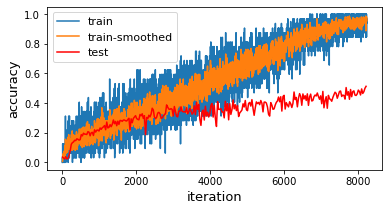

In [20]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),(len(test_accs)-1)*30+1)+1,30),test_accs,'red',label='test')
plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
plt.savefig('curves.png',dpi=200,bbox_inches='tight')